In [1]:
import pandas as pd
import tweepy
import requests
import datetime
import json
import matplotlib.pyplot as plt
from Classes import Data_crawl
from functions import *
import numpy as np

### My Access Keys for Tweepy

In [2]:
# sean19981002
api_key = 'AD9ZnCOeRDtYEiGe45WUtPS2j'
api_key_secret = '8YRO0UU9vAoLCOUn3FO96OXUdEBuJpRIzgyPCTHgyudmt2SZuh'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAF71jAEAAAAAKAm8%2BESJhS4ydqw1pSAd%2FXmL41Q%3DyY2fkJmdECatUXBWKk49JYzBjMFoovBtUn1VrHDiAiwQy3pwR7'

In [3]:
# s10627070
api_key = 'I3N75MY5qJxCvSrLWe0ZG4vQk'
api_key_secret = 'Q3GC8Vr6F2FNqwh7v8rWoDNnA1Qqnn4RjkJ6STVtAQLamw4qCs'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIPvbAEAAAAApt3kcfjyiVBOLVWMbi1Fu6CLL24%3DuIMwpFYplQqMd68VXXv4eU954tnOQu5vljRnV3xL292k4F5sFR' #old
access_token = '1467171706754453504-EJx2MzY1RtEGHXf3hqBZkANnsc4hA2'
access_token_secret = 'VpVdfP1WhID2nas76BXRTMdXXOTvx1BPO1J9LDYs9QM65'

In [4]:
token = list()
with open('tokens.txt', 'r') as f:
    for line in f:
        line = line.replace('\n', '')
        token.append(line)
token

['AAAAAAAAAAAAAAAAAAAAAJaOeQEAAAAAwwB4BH%2FBSUwJFsgWK1Ow3B2L7N8%3DKBHVX6eL8DqUOqnOllvzBsN3XlGWdE87o5AC9hvaGVGI0yTo1R',
 'AAAAAAAAAAAAAAAAAAAAAP72jAEAAAAA7DFjY0A3oGFlzNLO6bq9pMh2hU8%3DAX72OdeqqVlHYhYzwWU7aofc8EkKdZmujEjlFNiZAsG81gQhlW',
 'AAAAAAAAAAAAAAAAAAAAAIPvbAEAAAAAh3nRGhJ1HJjYHAwyxn7F5tm91js%3DpUaTtSLOgLxWFGdDaL2cDgHbJyiYQt8UMbWe8s9hfO8UIBK3xu',
 'AAAAAAAAAAAAAAAAAAAAAKkViAEAAAAAMh5Mzxxsa6pTshJUf1cTvjQIhFo%3DzO9GnsfJjH4LjOvV3PldqYkda3gyTTxBh1pEZGS3oQk7kdnX7i',
 'AAAAAAAAAAAAAAAAAAAAAOvxbAEAAAAAnL5kXJfdb%2Fa32z1iDgvi9lIqY58%3DvaL2jyG72R1kq7GTsmfOOMGjT5EJsvebYQGLc4Byko2j0WOe3w',
 'AAAAAAAAAAAAAAAAAAAAAJKnJgEAAAAAgpYwO66pBtdDUcwjHYnWbMY1ow8%3DJgCTSnmkqVE5M0ywnyoSvMX1Ywpz2ivYnONwQ0Aro7bgby6TUm',
 'AAAAAAAAAAAAAAAAAAAAAA0rhwEAAAAAwg6pSXd9zTPDUu70sBe7aA1x6SQ%3D4e492L05dARGO4yEj9LZ2POAjq4oGkwVQQBCPQKfc2ocoV8sth',
 'AAAAAAAAAAAAAAAAAAAAAF71jAEAAAAAKAm8%2BESJhS4ydqw1pSAd%2FXmL41Q%3DyY2fkJmdECatUXBWKk49JYzBjMFoovBtUn1VrHDiAiwQy3pwR7',
 'AAAAAAAAAAAAAAAAAAAAAAYGjQEAAAAAC74DT7oAQi5gv0bF9WdeU4

## <font color="pink">Biden tweets crawling </font> ##



In [5]:
download = False # 需不需要抓資料，FALSE 的話載入本地資料

today  = '2022-11-07' # date you wanna captured
file_path = 'Biden/' + today + '/'
dataset = Data_crawl(token=token, file_path=file_path)
query = 'from:POTUS -is:retweet' 
tweet_fields = ['author_id', 'created_at', 'retweeted', 'retweet_count', 'favorite_count']


if download:
    tweet_df = dataset.Get_Tweets_Dataframe(
        query=query,
        tweet_fields=tweet_fields
    )
else:
    tweet_df = pd.read_excel(file_path + 'Biden.xlsx')
    tweet_df = tweet_df[73:142] # selecting range you want of Biden's Tweets
    tweet_df[id] = tweet_df['id'].astype('int') # change 'id' from str into int
    tweet_df = tweet_df.reset_index() # reset index
    dataset.Get_Tweets_Dataframe(
        tweet_df=tweet_df, 
        wanna_download=download, 
        query=query, 
        tweet_fields=tweet_fields)

dataset.tweets_df

,index,id,created_at,text,retweeted,retweet_count,favorite_count,139965871847696
0,73,1586798846709227521,Sun Oct 30 19:15:01 +0000 2022,We’re making sure the biggest corporations beg...,False,5400,23297,1586798846709227521
1,74,1586787521920483331,Sun Oct 30 18:30:00 +0000 2022,We’re capping seniors’ out-of-pocket costs for...,False,7253,30591,1586787521920483331
2,75,1586773677869342724,Sun Oct 30 17:35:00 +0000 2022,Jill and I are devastated to learn that at lea...,False,4988,40074,1586773677869342724
3,76,1586719571574235144,Sun Oct 30 14:00:00 +0000 2022,We’re reducing the burden on working- and midd...,False,4120,17949,1586719571574235144
4,77,1586511955572973568,Sun Oct 30 00:15:00 +0000 2022,Oil companies made billions in profits this qu...,False,9393,35207,1586511955572973568
...,...,...,...,...,...,...,...,...
64,137,1584635840818515974,Mon Oct 24 20:00:00 +0000 2022,"Exactly one week ago, we launched our applicat...",False,5782,22305,1584635840818515974
65,138,1584620744624979969,Mon Oct 24 19:00:01 +0000 2022,We know what Republicans in Congress will do i...,False,9317,26758,1584620744624979969
66,139,1584613701176463382,Mon Oct 24 18:32:01 +0000 2022,Republican officials want to put America in de...,False,4678,13701,1584613701176463382
67,140,1584602542239105025,Mon Oct 24 17:47:41 +0000 2022,For two years the COVID virus has been evolvin...,False,2727,13800,1584602542239105025


## <font color="pink">依照 tweet ID 尋找每篇推文的 retweeters</font> 

> * 使用 JSON/XLSX 格式儲存 retweeters
> * 針對每篇 tweet 建立兩個 list，分別把抓到的 ID、UserName 存進 Retweeter_List
> * 將抓取的時間範圍寫在最前面
>
> * <font color=#FF6600> 要用 paginator 抓 retweeters，否則會抓不超過 100 個
> * 練習檔案讀寫務必記得拿 White House，否則複寫以後檔案會消失 (2022/10/06 )  </font>


In [6]:
retweeter_dict = dict() # keys:tweet id, value:list of retweeters
retweeters = set()

if download:
    retweeter_dict = dataset.Get_Retweeters_Multi()
else:
    for i in range(7):
        file = file_path + "retweeters/%d_retweeters.json" % i
        # loading files and combine
        if path.exists(file):
            with open(file, "r") as f:
                json_data = json.load(f)
                for j in json_data.keys():
                    retweeter_dict[j] = json_data[j]

## <font color="pink"> 分布圖 & Target User </font> 

- 依照每篇 tweet 看一下 retweet count ，畫成 bar chart.

- 依照每個 user 轉推的篇數畫出 bar chart，<font color=#FFD382> X軸為 轉推1,2,3... 的篇數，Y軸為人數 </font>
- 分布圖出來以後，設一個底線，把轉推篇數低於這個底線的 user 踢掉，留下的就是 target user

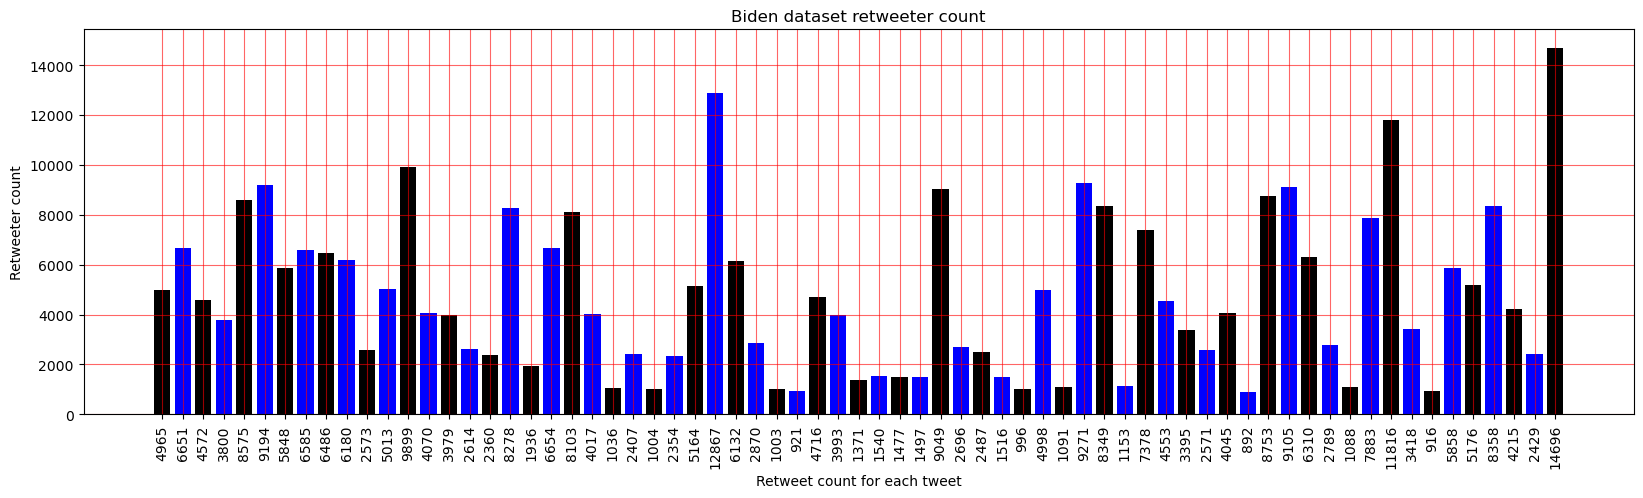

In [7]:
# retweet count for each tweet -- bar chart
count = list()
for id in retweeter_dict.keys():
    count.append(len(retweeter_dict[id]))
retweet_count = list(map(str, count))

plt.figure(figsize = (20,5))
plt.title('Biden dataset retweeter count')
plt.bar(retweet_count, count, color=['black', 'blue'], width=0.8, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.xlabel('Retweet count for each tweet')
plt.ylabel('Retweeter count')
plt.xticks(rotation='vertical')
plt.show()

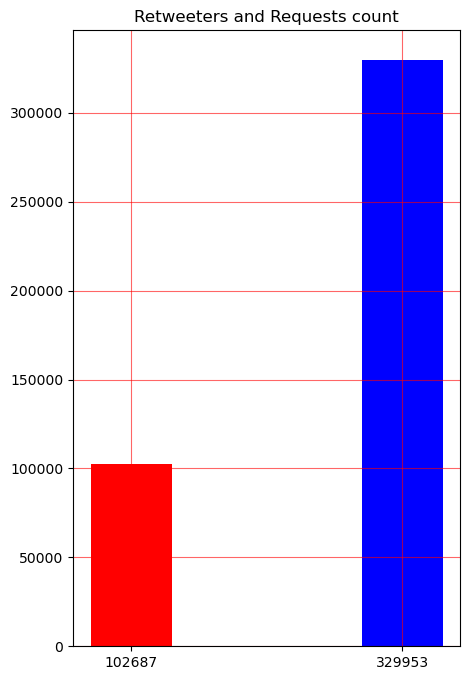

In [8]:
# Union the retweeter lists, filtering the repeated id

retweeters = set()
requests_count = 0
for i in retweeter_dict.keys():
    retweeter_list = set(retweeter_dict[i])
    requests_count += len(retweeter_list)
    retweeters |= retweeter_list # Union into retweeters

# And also, see the ratio of retweeters and requests count --> bar chart
plt.figure(figsize = (5,8))
plt.title('Retweeters and Requests count')
plt.bar([str(len(retweeters)), str(requests_count)], [len(retweeters), requests_count],color=['red', 'blue'], width=0.3, align='center')
plt.grid(True,color='r',alpha=0.6)
plt.show()

## Target User
- 踢掉 retweet 篇數過少的 users，剩下的對象就是 target users.
- 接著再用 target users 去蒐集相對應的 followers.
- Negative Sampling 可能要上.

In [9]:
# start finding retweets count of each user
user_retweet_count = dict()

if path.exists(file_path + "UserRetweetCount.json"):
    with open(file_path + "UserRetweetCount.json", "r") as f:
        user_retweet_count = json.load(f)

else:
    user_retweet_count = UserRetweetCount_MultiCore(
        retweeter_dict=retweeter_dict, 
        retweeters=list(retweeters), 
        parallelism=8, 
        requests_count=requests_count
    )
    with open(file_path + "UserRetweetCount.json", "w") as f:
        json.dump(user_retweet_count, f, indent=True)


In [10]:
# start statistics retweet count

"""
    Retweet count from 1 to len(how many tweets)
    show_list : first element represent 'how many users retweet 1 tweet', so are the rests.

"""
label = [str(i) for i in range(1,70,1)]
show_list = [0 for i in range(tweet_df.shape[0])]

for user in user_retweet_count.keys():
    index = user_retweet_count[user]
    show_list[index-1] += 1

Total users: 102687


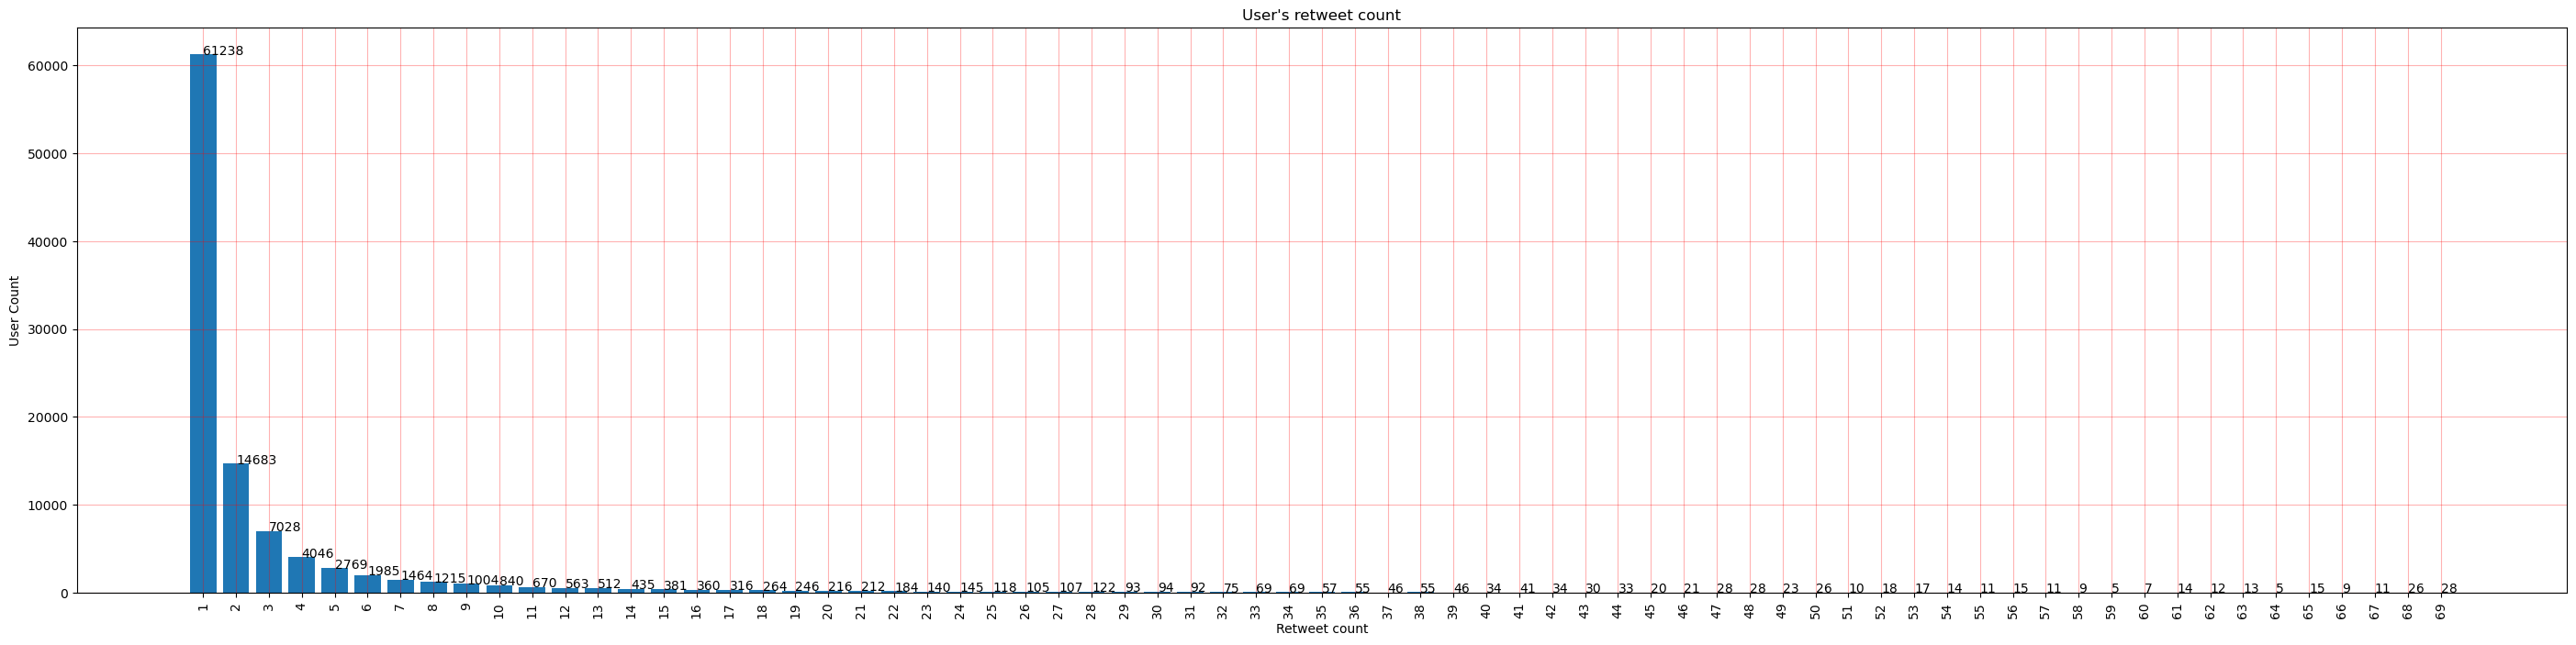

In [11]:
# Draw a bar plot to see
print("Total users: %d" % len(retweeters))
color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count")
plt.bar(label, show_list)
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Retweet count')
plt.ylabel('User Count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list):
    plt.text(index, value, str(value))
plt.show()

Total users : 102687
Deleting users of retweet counts lower than 5 : 89764
Total of target users : 12923


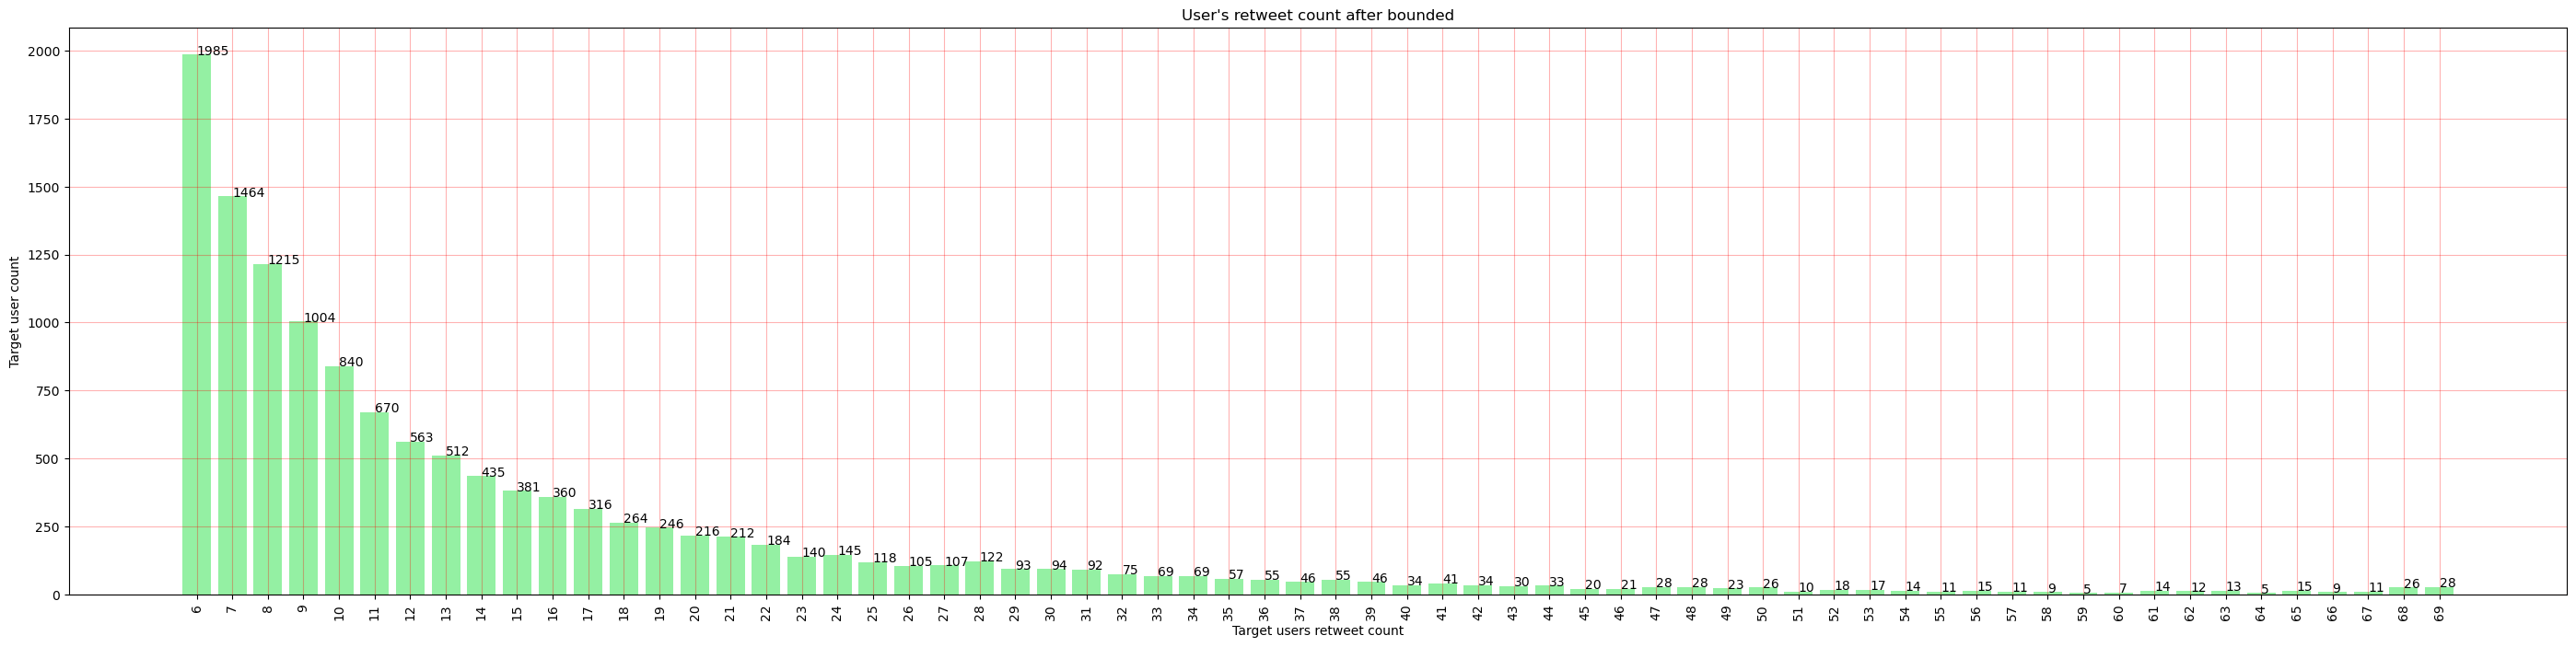

In [12]:
#   Draw a bar plot to see after bounded
"""
    Set bound after observing the user's retweet counts distributionns.
    Most of the users distributed in the range of 1 to 3.
"""


bound = 5
print("Total users :", len(retweeters))
print("Deleting users of retweet counts lower than %d : %d" % (bound, sum(show_list[0:bound])))
print("Total of target users : %d" % sum(show_list[bound:]))

color = (0.3, 0.9, 0.4, 0.6)
plt.figure(figsize = (35,8))
plt.title("User's retweet count after bounded")
plt.bar(label[bound:], show_list[bound:], color=color, width=0.8, align='center')
plt.grid(True,color='r',alpha=0.3)
plt.xlabel('Target users retweet count')
plt.ylabel('Target user count')
plt.xticks(rotation='vertical')
for index, value in enumerate(show_list[bound:]):
    plt.text(index, value, str(value))
plt.show()

In [13]:
wanna_find_target = False
target_users = list()

if path.exists(file_path + "target_users.json"):   # need to run the function to find target users
    with open(file_path + "target_users.json", "r") as f:
        json_file = json.load(f)
        target_users = list(json_file)

    
else: # load the file of target users
    target_users = FindTargetUser_MultiCore(
        bound = bound,
        retweeters = user_retweet_count,
    )
    target_users = sorted(target_users)
    print("Target users :", len(target_users))
    with open(file_path + "target_users.json", "w") as f:
        json.dump(target_users, f, indent=True)

### 將過濾非 target users 以後的貼文的轉推數以及他與 target users 的比例轉為 dataframe並畫圖表

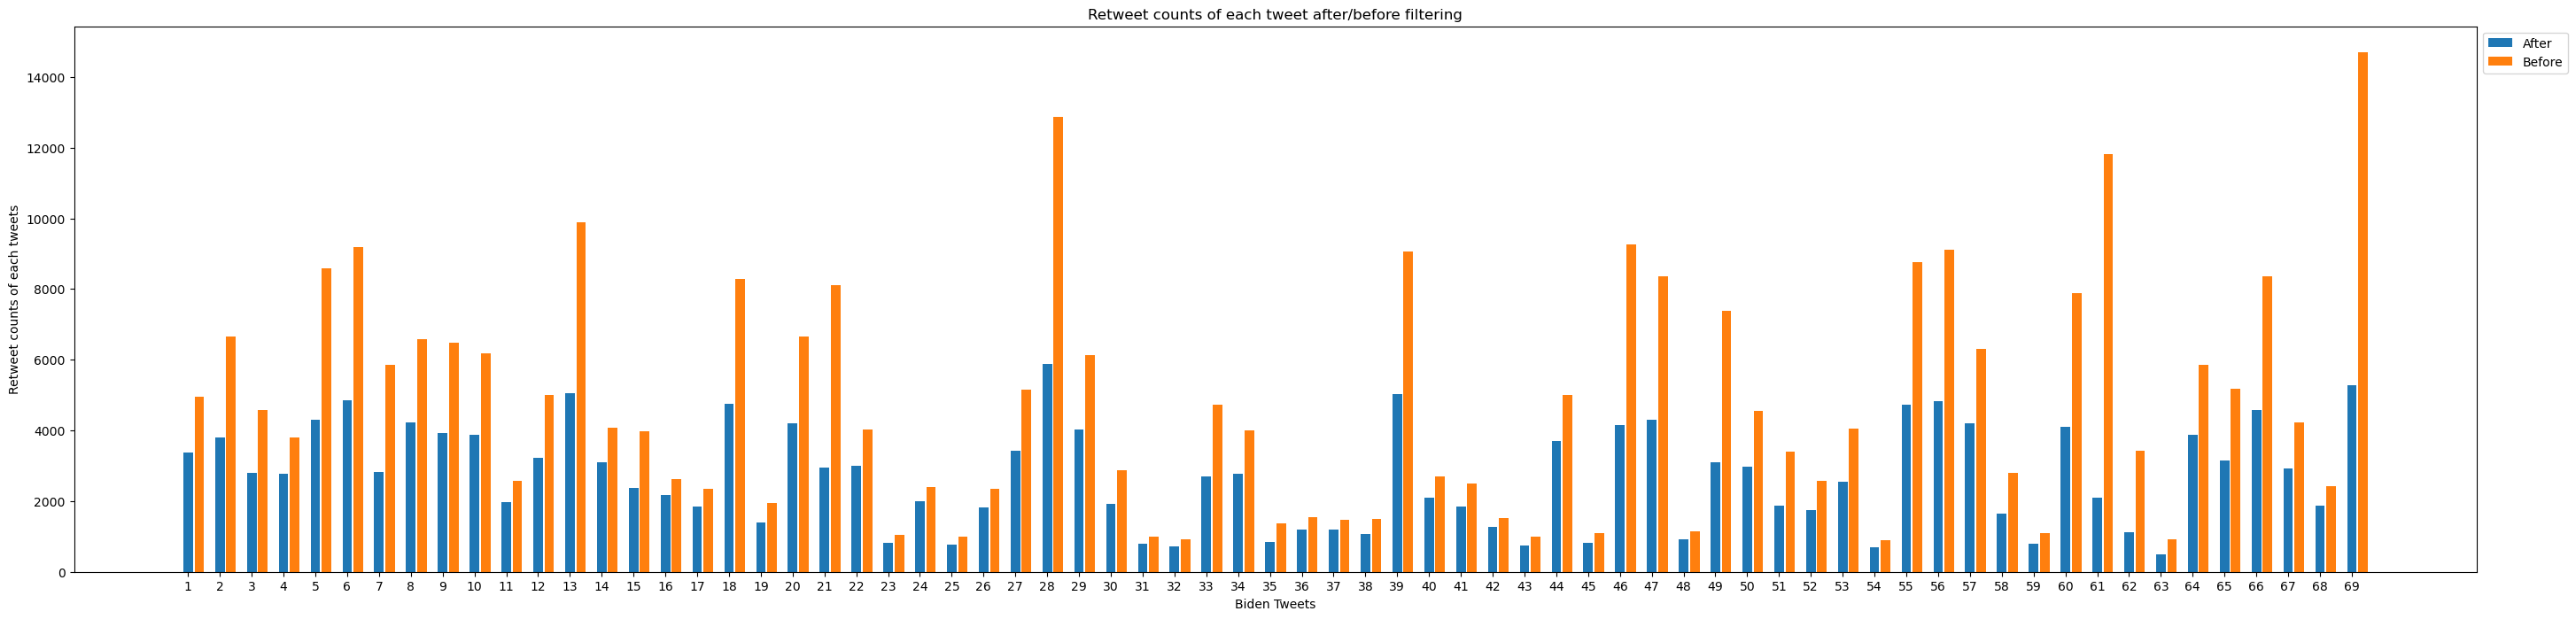

In [14]:
# retweet count for each tweet after filtering
count = [[], []]
tmp = dict()
for id in retweeter_dict.keys():
    tmp[id] = set(target_users) & set(retweeter_dict[id])
    count[0].append(len(tmp[id]))
    count[1].append(len(retweeter_dict[id]))
X = [str(i) for i in range(1, len(count[0])+1, 1)]
X_axis = np.arange(len(X))

plt.figure(figsize = (35,8))
plt.bar(X_axis, count[0], width=0.3,  label='After')
plt.bar(X_axis+0.35, count[1], width=0.3,  label='Before')
plt.xticks(X_axis, X)
plt.xlabel("Biden Tweets")
plt.ylabel("Retweet counts of each tweets")
plt.title("Retweet counts of each tweet after/before filtering")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [15]:
ori = [len(retweeter_dict[i]) for i in retweeter_dict.keys()]
aft = [len(tmp[i]) for i in retweeter_dict.keys()]
df_data = {
    "id" : list(retweeter_dict.keys()),
    "Original retweet count" : count[1],
    "After filtering" : count[0]
}
my_df = pd.DataFrame(df_data)
#my_df['id'] = my_df[id].astype('str')
my_df['Ratio of after/total'] = my_df['After filtering'].div(len(retweeters)).round(3)
my_df.to_excel(file_path + "compare%d.xlsx" % bound, index=False, header=True, sheet_name="Threshold=%d" % bound)

## <font color="pink"> 開始針對 Day 11 ~ Day 17 的 Biden tweet 蒐集轉推的時間 </font> 

> - #### 把 dataG.xlsx 裡面的 tweet id 拿出來(biden_tweets)，送進 dataset.Get_User_Tweets_Multi()，原本 type 為 str，須轉換成 int
> - #### crawling target user 的貼文牆，若有轉推這段時間內的貼文，寫進 txt file
>       * txt : target id, referenced id, tweet id, created at

In [16]:
type(target_users[0])

int

In [17]:
file_path

'Biden/2022-11-07/'

In [18]:
biden_tweets = list()
with open(file_path + "user_tweets/dataG.xlsx", "r") as f:
    df = pd.read_excel(file_path + "user_tweets/dataG.xlsx")
    biden_tweets = list(df['id'].astype('int'))

print("Tweets for data graph:")
print("  * Tweets count :", len(biden_tweets))
print("  * Element type :", type(biden_tweets[0]))

Tweets for data graph:
  * Tweets count : 71
  * Element type : <class 'int'>


In [19]:
"""
    get tweets from the post wall of each target user.
    and dont captured those target users who already been crawed.
"""

dataset.Get_User_Tweets_Multi(
    target_user=target_users,
    biden_tweets=biden_tweets
)


Already crawled : 12923
Target users : 12923
ALL data had already crawled !


In [20]:
# get follower list of every target users
target_users.remove(9624742) # followers too many, 6.3M

target_followers = dataset.Get_Followers_Multi(
    target_users = target_users,
)


Already crawled : 8158
Target users : 12922
Start collecting followers of target users...
2022-11-17 15:33:31.595253 Process 0 current : 9745602


Rate limit exceeded. Sleeping for 856 seconds.


2022-11-17 15:33:32.613234 Process 1 current : 71151452


Rate limit exceeded. Sleeping for 220 seconds.


2022-11-17 15:33:33.626898 Process 2 current : 126450712


Rate limit exceeded. Sleeping for 390 seconds.


2022-11-17 15:33:34.641147 Process 3 current : 315625544


Rate limit exceeded. Sleeping for 855 seconds.


2022-11-17 15:33:35.676580 Process 4 current : 600055511
2022-11-17 15:33:36.688665 Process 5 current : 1532947802
2022-11-17 15:33:36.790413 Process 4 current : 600648807
2022-11-17 15:33:37.718479 Process 6 current : 2796863405
2022-11-17 15:33:37.849527 Process 5 current : 1536796285


Rate limit exceeded. Sleeping for 850 seconds.
Rate limit exceeded. Sleeping for 215 seconds.


2022-11-17 15:33:38.701300 Process 7 current : 703321989239447553
2022-11-17 15:33:38.819908 Process 4 current : 601459279
2022-11-17 15:33:39.715051 Process 8 current : 825127941507944448


Rate limit exceeded. Sleeping for 853 seconds.


2022-11-17 15:33:40.712616 Process 9 current : 960995321672294400
2022-11-17 15:33:41.565878 Process 4 current : 938717942
2022-11-17 15:33:41.720934 Process 10 current : 1177652811800051712
2022-11-17 15:33:42.748188 Process 11 current : 1358617820712607744


Rate limit exceeded. Sleeping for 394 seconds.


2022-11-17 15:33:43.536524 Process 7 current : 704013051314372609
2022-11-17 15:33:43.725116 Process 4 current : 940448438
2022-11-17 15:33:43.732515 Process 12 current : 1446420307238178819
2022-11-17 15:33:44.067222 Process 7 current : 704029128647798784
2022-11-17 15:33:44.213871 Process 12 current : 1446423908035465217
2022-11-17 15:33:44.438587 Process 4 current : 942447002
2022-11-17 15:33:44.572917 Process 12 current : 1446524506303078431
2022-11-17 15:33:44.617970 Process 7 current : 704342738012078080
Wait for all process....
2022-11-17 15:33:45.043269 Process 12 current : 1446783666026266624
2022-11-17 15:33:45.397146 Process 12 current : 1446938825213812737
2022-11-17 15:33:45.461729 Process 10 current : 1177728617025064961
2022-11-17 15:33:45.764965 Process 10 current : 1177773004228571136
2022-11-17 15:33:45.819283 Process 12 current : 1447198923379068937
2022-11-17 15:33:46.751089 Process 7 current : 704428571939336192


Rate limit exceeded. Sleeping for 843 seconds.


2022-11-17 15:33:47.171279 Process 12 current : 1447243054369308674
2022-11-17 15:33:47.547217 Process 12 current : 1447245527658156032
2022-11-17 15:33:47.579281 Process 10 current : 1178022762411184128
2022-11-17 15:33:48.014040 Process 12 current : 1447403355618304003
2022-11-17 15:33:48.403854 Process 10 current : 1178453431754752000
2022-11-17 15:33:48.902359 Process 10 current : 1178793548222566401
2022-11-17 15:33:48.932529 Process 12 current : 1447594125931470857


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 15:33:49.363789 Process 12 current : 1447656852272005121
2022-11-17 15:33:50.307484 Process 10 current : 1178822573897011201
2022-11-17 15:33:50.660330 Process 10 current : 1179095011457196034
2022-11-17 15:33:51.174743 Process 10 current : 1179124044752404482
2022-11-17 15:33:54.532264 Process 9 current : 961113478718246912


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 172 seconds.


2022-11-17 15:37:14.074711 Process 6 current : 2798807857
2022-11-17 15:37:16.024460 Process 6 current : 2800591331
2022-11-17 15:37:16.473060 Process 6 current : 2802250017
2022-11-17 15:37:24.456517 Process 6 current : 2802308323


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 15:40:04.835822 Process 2 current : 247487559
2022-11-17 15:40:06.496958 Process 2 current : 247513550
2022-11-17 15:40:06.843203 Process 2 current : 247642500
2022-11-17 15:40:12.823960 Process 2 current : 247744426


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 15:40:22.168834 Process 11 current : 1358899343378550799
2022-11-17 15:40:22.433653 Process 11 current : 1358998034735112195
2022-11-17 15:40:23.363408 Process 11 current : 1359024248245862402


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 15:47:48.746552 Process 0 current : 9874942
2022-11-17 15:47:49.731797 Process 0 current : 10001212
2022-11-17 15:47:50.695586 Process 7 current : 704501696525787136
2022-11-17 15:47:51.101567 Process 3 current : 315990434
2022-11-17 15:47:51.200161 Process 7 current : 789088712143409152
2022-11-17 15:47:51.619688 Process 5 current : 1537157346
2022-11-17 15:47:51.646393 Process 7 current : 789134823885418496
2022-11-17 15:47:51.667905 Process 3 current : 484153762
2022-11-17 15:47:51.983092 Process 7 current : 789146002393563136
2022-11-17 15:47:52.189056 Process 3 current : 484286254
2022-11-17 15:47:52.467769 Process 7 current : 789558747190394880
2022-11-17 15:47:52.622048 Process 3 current : 484418111
2022-11-17 15:47:53.258520 Process 7 current : 789722813355601920
2022-11-17 15:47:53.342439 Process 5 current : 2022-11-17 15:47:53.3449011537307496
 Process 0 current : 11586452
2022-11-17 15:47:53.645535 Process 7 current : 789884562310631424
2022-11-17 15:47:54.034395 

Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 15:47:55.599399 Process 3 current : 485860936
2022-11-17 15:47:55.710064 Process 8 current : 825136470662975488


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 15:47:56.100292 Process 3 current : 486081900
2022-11-17 15:47:56.191102 Process 8 current : 825146425721905152


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 15:48:40.196818 Process 4 current : 942698893
2022-11-17 15:48:40.649858 Process 4 current : 943389476
2022-11-17 15:48:42.412890 Process 4 current : 944653086
2022-11-17 15:48:42.935751 Process 4 current : 946119746
2022-11-17 15:48:43.388516 Process 4 current : 946259028
2022-11-17 15:48:43.399431 Process 9 current : 961255438049333249
2022-11-17 15:48:43.925818 Process 9 current : 961277402813956096
2022-11-17 15:48:44.132803 Process 4 current : 946344888
2022-11-17 15:48:44.463328 Process 9 current : 961359893910425600
2022-11-17 15:48:44.816829 Process 9 current : 961633209590145025
2022-11-17 15:48:45.111871 Process 9 current : 961860755690696704
2022-11-17 15:48:45.494994 Process 9 current : 962381519024095232
2022-11-17 15:48:46.763896 Process 9 current : 1073690437620260865
2022-11-17 15:48:47.144105 Process 9 current : 1074276408535511040


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 15:52:16.725062 Process 6 current : 4269803603
2022-11-17 15:52:17.455259 Process 6 current : 4273097474
2022-11-17 15:52:18.374665 Process 6 current : 4278039155
2022-11-17 15:52:20.976943 Process 6 current : 4281570916


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 16:02:50.055605 Process 0 current : 12008902
2022-11-17 16:02:50.550228 Process 0 current : 12613032
2022-11-17 16:02:50.968481 Process 5 current : 2297119045
2022-11-17 16:02:51.694786 Process 5 current : 2297446780
2022-11-17 16:02:52.188939 Process 5 current : 2298289777
2022-11-17 16:02:52.461181 Process 0 current : 12879202
2022-11-17 16:02:53.229708 Process 0 current : 12901492
2022-11-17 16:02:53.325881 Process 3 current : 486219797
2022-11-17 16:02:54.481499 Process 0 current : 12959802
2022-11-17 16:02:54.939570 Process 0 current : 12978042


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 16:02:56.576935 Process 3 current : 486252487
2022-11-17 16:02:56.943206 Process 3 current : 486288432
2022-11-17 16:02:57.392135 Process 3 current : 486316267


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 16:02:58.858021 Process 3 current : 486604083


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 16:03:01.147531 Process 8 current : 825155032462921729
2022-11-17 16:03:01.615984 Process 8 current : 825164378215432192
2022-11-17 16:03:02.168479 Process 8 current : 825181652120788993
2022-11-17 16:03:02.743604 Process 8 current : 825271813462585345
2022-11-17 16:03:03.677123 Process 8 current : 919042632801771520
2022-11-17 16:03:04.054528 Process 8 current : 919634578276601856
2022-11-17 16:03:04.491388 Process 8 current : 920134096956936192


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 16:03:48.281468 Process 9 current : 1074356871174209536
2022-11-17 16:03:48.636334 Process 9 current : 1074426324545097729
2022-11-17 16:03:49.523800 Process 9 current : 1074729218632806401


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 16:03:53.520497 Process 9 current : 1074751613586284544
2022-11-17 16:03:55.200896 Process 9 current : 1074780816864149505


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 16:07:17.718449 Process 6 current : 4281996913
2022-11-17 16:07:19.549535 Process 6 current : 4284893477
2022-11-17 16:07:19.958315 Process 6 current : 4285787714
2022-11-17 16:07:20.468943 Process 6 current : 4289447063
2022-11-17 16:07:22.980030 Process 6 current : 4291563924
2022-11-17 16:07:23.760907 Process 6 current : 4324505358
2022-11-17 16:07:24.286625 Process 6 current : 4325736022
2022-11-17 16:07:24.683063 Process 6 current : 4330089263
2022-11-17 16:07:25.446543 Process 6 current : 4330986263


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 16:10:23.519119 Process 11 current : 1359169839999447042
2022-11-17 16:10:23.902779 Process 11 current : 1359209281359282176
2022-11-17 16:10:24.232325 Process 11 current : 1359620851952418826
2022-11-17 16:10:24.941856 Process 11 current : 1360051439951745024
2022-11-17 16:10:25.692747 Process 11 current : 1360399724344442881
2022-11-17 16:10:26.474005 Process 11 current : 1360631013215526915


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 16:17:52.860248 Process 7 current : 790889950250164224
2022-11-17 16:17:53.188924 Process 3 current : 4867384182022-11-17 16:17:53.191705
 Process 7 current : 790964547494506496
2022-11-17 16:17:55.291906 Process 0 current : 13568912
2022-11-17 16:17:55.956709 Process 3 current : 486908878
2022-11-17 16:17:56.404449 Process 8 current : 920382898812997634


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 16:17:58.095085 Process 8 current : 920642810788925440
2022-11-17 16:17:58.156882 Process 7 current : 791699585223712768
2022-11-17 16:17:58.600715 Process 7 current : 791911915077439488
2022-11-17 16:17:59.031118 Process 7 current : 792398794059026435
2022-11-17 16:17:59.437840 Process 7 current : 792403496825974786


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 16:18:00.773849 Process 7 current : 792797789927378944


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 16:22:20.616307 Process 6 current : 4332284595
2022-11-17 16:22:21.477958 Process 6 current : 4332709972
2022-11-17 16:22:21.917991 Process 6 current : 4333302880
2022-11-17 16:22:22.388451 Process 6 current : 4337074513
2022-11-17 16:22:23.315029 Process 6 current : 4339608079
2022-11-17 16:22:24.701235 Process 6 current : 4350479772


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 16:32:53.767042 Process 7 current : 793271243810234368
2022-11-17 16:32:54.212974 Process 7 current : 793367160341094400
2022-11-17 16:32:55.991537 Process 3 current : 487197564
2022-11-17 16:32:58.120865 Process 7 current : 793513080428822528
2022-11-17 16:32:58.322186 Process 3 current : 487228241
2022-11-17 16:32:58.583441 Process 7 current : 793528147102818304


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 16:32:59.662246 Process 3 current : 487642650
2022-11-17 16:33:00.837785 Process 7 current : 793560323609460736


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 16:33:01.474303 Process 7 current : 793586145254748160
2022-11-17 16:33:01.817552 Process 7 current : 793600604283305984


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 16:33:03.941613 Process 8 current : 921246007077175296
2022-11-17 16:33:04.346825 Process 8 current : 921398887541121024
2022-11-17 16:33:06.220302 Process 8 current : 921464207312289793


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 16:37:22.276229 Process 6 current : 4351263087
2022-11-17 16:37:24.589703 Process 6 current : 4351318152
2022-11-17 16:37:27.365788 Process 6 current : 4352202027
2022-11-17 16:37:27.763263 Process 6 current : 4352212707
2022-11-17 16:37:28.166592 Process 6 current : 4363085188
2022-11-17 16:37:28.718939 Process 6 current : 4367035762


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 16:40:11.101308 Process 2 current : 247889672
2022-11-17 16:40:12.565898 Process 2 current : 247961366
2022-11-17 16:40:13.164635 Process 2 current : 248432782
2022-11-17 16:40:13.539473 Process 2 current : 248616212
2022-11-17 16:40:13.947352 Process 2 current : 248688460
2022-11-17 16:40:15.440853 Process 2 current : 248695826
2022-11-17 16:40:15.903093 Process 2 current : 248825254


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 16:47:53.496342 Process 0 current : 13753532
2022-11-17 16:47:53.800289 Process 5 current : 2299327182
2022-11-17 16:47:54.665459 Process 5 current : 2300104914
2022-11-17 16:47:55.047741 Process 5 current : 2301659114
2022-11-17 16:47:56.251194 Process 5 current : 2302272980
2022-11-17 16:47:56.861125 Process 7 current : 793971883616124929
2022-11-17 16:47:57.492435 Process 5 current : 2304058364
2022-11-17 16:47:57.764766 Process 5 current : 2304220740
2022-11-17 16:47:58.516339 Process 0 current : 14049972
2022-11-17 16:47:59.011345 Process 0 current : 14063008


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 16:48:02.928229 Process 8 current : 921746390656671744
2022-11-17 16:48:03.389328 Process 8 current : 921869201782042625
2022-11-17 16:48:03.774395 Process 8 current : 921886547124858880
2022-11-17 16:48:04.165354 Process 8 current : 921931517093400576
2022-11-17 16:48:04.587297 Process 8 current : 921947460863344642
2022-11-17 16:48:05.550025 Process 8 current : 922471070552215553


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 16:48:58.976027 Process 9 current : 1075555660916514817
2022-11-17 16:48:59.375872 Process 9 current : 1075862747315810305
2022-11-17 16:48:59.803545 Process 9 current : 1075917574741856256


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 16:52:21.862268 Process 6 current : 4373109794
2022-11-17 16:52:22.651724 Process 6 current : 4375520925
2022-11-17 16:52:26.421043 Process 6 current : 4382804954
2022-11-17 16:52:29.399846 Process 6 current : 4386243922
2022-11-17 16:52:29.767969 Process 6 current : 4392756681


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 16:55:11.012250 Process 2 current : 248896092


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 16:55:25.387259 Process 11 current : 1360693131671343108
2022-11-17 16:55:25.762845 Process 11 current : 1360946951454404615
2022-11-17 16:55:27.654495 Process 11 current : 1361097544676311041
2022-11-17 16:55:28.176166 Process 11 current : 1361133918389436416
2022-11-17 16:55:29.035999 Process 11 current : 1361416296672464902
2022-11-17 16:55:29.581140 Process 11 current : 1361496222301757444
2022-11-17 16:55:31.406631 Process 11 current : 1361709432942583809


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 17:02:56.058649 Process 7 current : 794619537559814144
2022-11-17 17:02:56.911613 Process 7 current : 794923583143149568
2022-11-17 17:02:57.055178 Process 0 current : 14070906
2022-11-17 17:02:57.846271 Process 0 current : 14135426
2022-11-17 17:02:58.296154 Process 5 current : 2304855368
2022-11-17 17:02:59.032429 Process 3 current : 488024510
2022-11-17 17:02:59.396373 Process 7 current : 794938549451759616
2022-11-17 17:02:59.416239 Process 3 current : 488056864
2022-11-17 17:02:59.973473 Process 7 current : 795419057487024129
2022-11-17 17:02:59.996875 Process 3 current : 488080732
2022-11-17 17:03:00.426989 Process 3 current : 489691285
2022-11-17 17:03:00.457442 Process 8 current : 922606499888758787


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 17:03:00.964885 Process 8 current : 922613656667422722
2022-11-17 17:03:01.357111 Process 7 current : 795629889663762432


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 17:03:02.904916 Process 7 current : 795742382411157504


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 17:03:50.053243 Process 9 current : 1075982724958175232
2022-11-17 17:03:50.343830 Process 9 current : 1076142148502859776
2022-11-17 17:03:51.797312 Process 9 current : 1076641621352034306
2022-11-17 17:03:52.224098 Process 9 current : 1076847120143925251
2022-11-17 17:03:54.814963 Process 9 current : 1076972630635274240
2022-11-17 17:03:57.090441 Process 9 current : 1076973002045177856
2022-11-17 17:03:57.557098 Process 9 current : 1077033312722530304


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 17:03:57.937996 Process 9 current : 1077062362836815872
2022-11-17 17:03:58.438157 Process 9 current : 1077225059939467266
2022-11-17 17:03:58.821584 Process 9 current : 1077505055345922048


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 17:07:23.000896 Process 6 current : 4398387029
2022-11-17 17:07:23.495821 Process 6 current : 4403491572
2022-11-17 17:07:25.778109 Process 6 current : 4403932461
2022-11-17 17:07:26.204543 Process 6 current : 4407038333
2022-11-17 17:07:26.732617 Process 6 current : 4410959969
2022-11-17 17:07:27.150454 Process 6 current : 4411102649
2022-11-17 17:07:30.788180 Process 6 current : 4412143822


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 17:10:25.338995 Process 11 current : 1361912669070970881
2022-11-17 17:10:25.799271 Process 11 current : 1362032884538834947
2022-11-17 17:10:26.668938 Process 11 current : 1362447067440951302
2022-11-17 17:10:27.431490 Process 11 current : 1362478499186016259
2022-11-17 17:10:28.016371 Process 11 current : 1362607921020952580


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 17:18:03.733122 Process 5 current : 2307213114
2022-11-17 17:18:04.085697 Process 3 current : 489840309
2022-11-17 17:18:04.162263 Process 5 current : 2307669031
2022-11-17 17:18:04.883731 Process 3 current : 490366025


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 17:18:09.304509 Process 3 current : 490384585


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 17:18:10.979880 Process 3 current : 490393163


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 17:18:50.552818 Process 9 current : 1078270075847802882
2022-11-17 17:18:51.332553 Process 9 current : 1078286231182692352
2022-11-17 17:18:52.170728 Process 9 current : 1078640776513548289
2022-11-17 17:18:52.569216 Process 9 current : 1078747118804832256
2022-11-17 17:18:53.465695 Process 9 current : 1079044640974737408
2022-11-17 17:18:54.179743 Process 9 current : 1079075425819680769
2022-11-17 17:18:58.327900 Process 9 current : 1079083358146064384
2022-11-17 17:18:58.773622 Process 9 current : 1079107164143276034
2022-11-17 17:18:59.541765 Process 9 current : 1079132387605266432


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 17:22:25.010326 Process 6 current : 4416121001
2022-11-17 17:22:25.438830 Process 6 current : 4417145253
2022-11-17 17:22:25.775327 Process 6 current : 4418940743
2022-11-17 17:22:26.603793 Process 6 current : 4420001009
2022-11-17 17:22:27.534576 Process 6 current : 4433296940
2022-11-17 17:22:28.002055 Process 6 current : 4435673712
2022-11-17 17:22:28.888805 Process 6 current : 4440909147
2022-11-17 17:22:29.715365 Process 6 current : 4452187707
2022-11-17 17:22:30.153450 Process 6 current : 4466733072
2022-11-17 17:22:30.562821 Process 6 current : 4476084275


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 17:25:31.062294 Process 11 current : 1362773037368692743
2022-11-17 17:25:31.374869 Process 11 current : 1362911757237424129
2022-11-17 17:25:31.879973 Process 11 current : 1363198042581524482
2022-11-17 17:25:32.349105 Process 11 current : 1363298622440357888
2022-11-17 17:25:32.845286 Process 11 current : 1363568080652181504
2022-11-17 17:25:34.570913 Process 11 current : 1363912931151384588
2022-11-17 17:25:35.449257 Process 11 current : 1364091261171339266
2022-11-17 17:25:35.952460 Process 11 current : 1364097628829405189


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 17:33:00.841370 Process 3 current : 490636475
2022-11-17 17:33:01.753352 Process 5 current : 2308345490
2022-11-17 17:33:02.535647 Process 5 current : 2308769400
2022-11-17 17:33:02.925107 Process 5 current : 2310553686
2022-11-17 17:33:03.141280 Process 3 current : 490731852
2022-11-17 17:33:03.735411 Process 3 current : 490764827


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 17:33:04.771878 Process 5 current : 2310756072
2022-11-17 17:33:05.277234 Process 5 current : 2311063720
2022-11-17 17:33:05.564122 Process 8 current : 922859147686764544
2022-11-17 17:33:06.024358 Process 8 current : 923233322582585344
2022-11-17 17:33:06.198331 Process 7 current : 795953364681064448
2022-11-17 17:33:06.397406 Process 8 current : 923336277268844550


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 17:33:07.062665 Process 3 current : 490782345
2022-11-17 17:33:07.146727 Process 8 current : 923344316503818240


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 17:33:07.672935 Process 3 current : 490946441


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 17:40:15.172053 Process 2 current : 248920752
2022-11-17 17:40:15.998914 Process 2 current : 248927428
2022-11-17 17:40:16.547159 Process 2 current : 249687228
2022-11-17 17:40:17.989113 Process 2 current : 249856675
2022-11-17 17:40:18.909113 Process 2 current : 250044015
2022-11-17 17:40:19.851931 Process 2 current : 250176982
2022-11-17 17:40:20.395781 Process 2 current : 250395671


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 17:47:59.105043 Process 7 current : 796092456236437504
2022-11-17 17:48:00.036291 Process 7 current : 796122768765022209
2022-11-17 17:48:01.785892 Process 7 current : 796143502937690118
2022-11-17 17:48:03.218682 Process 5 current : 2311116235
2022-11-17 17:48:05.327996 Process 3 current : 490990946


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 17:48:07.639156 Process 3 current : 491511680


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 17:48:08.609572 Process 5 current : 2312293558


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 17:48:09.010101 Process 3 current : 491737821
2022-11-17 17:48:09.542522 Process 3 current : 492466348
2022-11-17 17:48:09.954524 Process 3 current : 492542346
2022-11-17 17:48:10.408597 Process 3 current : 492599666


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 17:49:04.234319 Process 9 current : 1079143069038059520


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 17:52:35.033093 Process 6 current : 4477563313
2022-11-17 17:52:35.841844 Process 6 current : 4481687056
2022-11-17 17:52:36.365530 Process 6 current : 4481861534
2022-11-17 17:52:36.815959 Process 6 current : 4486336013
2022-11-17 17:52:37.353344 Process 6 current : 4488303807


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 17:55:14.724098 Process 2 current : 250604662
2022-11-17 17:55:15.666762 Process 2 current : 250616216
2022-11-17 17:55:16.142937 Process 2 current : 250684785
2022-11-17 17:55:16.926198 Process 2 current : 250691621
2022-11-17 17:55:20.365323 Process 2 current : 250695242
2022-11-17 17:55:20.733966 Process 2 current : 250753823


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 17:55:40.654650 Process 11 current : 1364412373885411328


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 18:03:05.885886 Process 3 current : 492702708
2022-11-17 18:03:06.313515 Process 3 current : 493117643


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 18:03:07.053715 Process 5 current : 2312685979
2022-11-17 18:03:07.439288 Process 5 current : 2312698814
2022-11-17 18:03:08.032417 Process 3 current : 493351539
2022-11-17 18:03:08.348313 Process 5 current : 2313348246


Rate limit exceeded. Sleeping for 896 seconds.


2022-11-17 18:03:08.602976 Process 3 current : 493754515
2022-11-17 18:03:09.035875 Process 3 current : 494138234
2022-11-17 18:03:09.044428 Process 8 current : 923346582908661761
2022-11-17 18:03:09.583233 Process 8 current : 923704345362759680
2022-11-17 18:03:09.837147 Process 3 current : 494391088


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 18:03:12.846870 Process 8 current : 923818590435917824
2022-11-17 18:03:12.876792 Process 3 current : 494659555
2022-11-17 18:03:13.274169 Process 8 current : 924038023167307777
2022-11-17 18:03:13.773630 Process 8 current : 924325113666965504


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 18:07:32.242925 Process 6 current : 4488769523
2022-11-17 18:07:35.146334 Process 6 current : 4492042880
2022-11-17 18:07:35.612476 Process 6 current : 4494507141
2022-11-17 18:07:36.035285 Process 6 current : 4495558277
2022-11-17 18:07:36.518558 Process 6 current : 4497632855
2022-11-17 18:07:37.315743 Process 6 current : 4500236833


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:10:30.585990 Process 11 current : 1364534792365211648
2022-11-17 18:10:31.039314 Process 11 current : 1364579275387592712
2022-11-17 18:10:31.586870 Process 11 current : 1364690140984139781
2022-11-17 18:10:33.487612 Process 11 current : 1364830342570532867
2022-11-17 18:10:33.949154 Process 11 current : 1364961043362045960
2022-11-17 18:10:34.373017 Process 11 current : 1365092108017823751
2022-11-17 18:10:34.707612 Process 11 current : 1365281507711938560
2022-11-17 18:10:35.067452 Process 11 current : 1365290254295584770
2022-11-17 18:10:35.479689 Process 11 current : 1365399022987399168
2022-11-17 18:10:35.913061 Process 11 current : 1365434922710818822


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:18:04.818364 Process 3 current : 495206895
2022-11-17 18:18:05.267192 Process 5 current : 2313795272
2022-11-17 18:18:05.298979 Process 3 current : 495339130
2022-11-17 18:18:05.753658 Process 5 current : 2316540020
2022-11-17 18:18:05.804929 Process 3 current : 495387895
2022-11-17 18:18:06.746236 Process 3 current : 495396554
2022-11-17 18:18:07.257997 Process 3 current : 495415177
2022-11-17 18:18:07.366946 Process 5 current : 2317864212


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:18:08.635854 Process 3 current : 495918203


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:18:09.423511 Process 3 current : 496306338
2022-11-17 18:18:09.957620 Process 8 current : 924925992270938112
2022-11-17 18:18:09.985782 Process 3 current : 497025230
2022-11-17 18:18:10.269287 Process 8 current : 925018780752928768
2022-11-17 18:18:10.482416 Process 3 current : 497027776
2022-11-17 18:18:10.753548 Process 8 current : 925028387122327552
2022-11-17 18:18:11.223827 Process 8 current : 925338281658736640


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:18:11.585415 Process 8 current : 925408498761940992


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:18:14.121300 Process 8 current : 925414928659501056


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:18:58.365893 Process 9 current : 1079382152163160064
2022-11-17 18:19:03.432950 Process 4 current : 946882993


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 18:22:29.136455 Process 6 current : 4510032132
2022-11-17 18:22:30.042454 Process 6 current : 4513983378
2022-11-17 18:22:38.500698 Process 6 current : 4516173496
2022-11-17 18:22:39.983606 Process 6 current : 4518610392


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 18:25:17.531783 Process 2 current : 250776493
2022-11-17 18:25:19.032944 Process 2 current : 250893905
2022-11-17 18:25:22.151456 Process 2 current : 251068809
2022-11-17 18:25:22.158063 Process 1 current : 71387958
2022-11-17 18:25:23.164373 Process 2 current : 251174491
2022-11-17 18:25:23.610815 Process 2 current : 251341054


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:25:26.028387 Process 1 current : 71469143
2022-11-17 18:25:28.572756 Process 1 current : 71642639


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:25:38.406147 Process 11 current : 1366110449276706822
2022-11-17 18:25:38.891918 Process 11 current : 1366164057938616321
2022-11-17 18:25:39.368786 Process 11 current : 1366358249155399681
2022-11-17 18:25:39.720770 Process 11 current : 1366484647106985987
2022-11-17 18:25:40.116373 Process 11 current : 1366551611733114881
2022-11-17 18:25:40.447692 Process 11 current : 1366580389825961984
2022-11-17 18:25:40.912419 Process 11 current : 1366807524637372422


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 18:33:07.103799 Process 3 current : 498077600
2022-11-17 18:33:08.168250 Process 5 current : 2318914404
2022-11-17 18:33:08.680434 Process 5 current : 2318997476
2022-11-17 18:33:09.084321 Process 8 current : 925524832179113995
2022-11-17 18:33:09.588137 Process 8 current : 926197208403279873
2022-11-17 18:33:09.635999 Process 5 current : 2319219266
2022-11-17 18:33:10.169053 Process 5 current : 2320850868


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:33:10.655517 Process 5 current : 2321563844
2022-11-17 18:33:11.871520 Process 8 current : 926550611155472384
2022-11-17 18:33:12.330416 Process 8 current : 926561761246846976
2022-11-17 18:33:13.340236 Process 8 current : 926960947234607104


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:33:13.756173 Process 8 current : 926963082320072704


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 18:33:54.133204 Process 4 current : 948708523
2022-11-17 18:33:54.847075 Process 4 current : 950426113
2022-11-17 18:33:57.616265 Process 4 current : 950572518
2022-11-17 18:33:58.110269 Process 4 current : 950883344
2022-11-17 18:34:03.332954 Process 9 current : 1079565934254276616
2022-11-17 18:34:03.366209 Process 4 current : 952167072
2022-11-17 18:34:03.873137 Process 4 current : 952829508


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 18:34:05.084691 Process 9 current : 1079808440275517444
2022-11-17 18:34:06.903789 Process 9 current : 1079880936819445760
2022-11-17 18:34:08.340851 Process 9 current : 1079884470927409152
2022-11-17 18:34:08.696086 Process 9 current : 1080150091825061888


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 18:37:32.960716 Process 6 current : 4519368256
2022-11-17 18:37:34.812996 Process 6 current : 4520486415
2022-11-17 18:37:35.371453 Process 6 current : 4529382444
2022-11-17 18:37:37.394625 Process 6 current : 4529960717
2022-11-17 18:37:37.789928 Process 6 current : 4531390125
2022-11-17 18:37:38.279298 Process 6 current : 4544016208


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 18:40:22.651401 Process 2 current : 251377054
2022-11-17 18:40:22.817951 Process 1 current : 71654435
2022-11-17 18:40:23.268741 Process 1 current : 71664307
2022-11-17 18:40:24.363915 Process 2 current : 251435647
2022-11-17 18:40:24.754201 Process 1 current : 71706877
2022-11-17 18:40:26.808415 Process 2 current : 251438342
2022-11-17 18:40:27.212427 Process 2 current : 252229421
2022-11-17 18:40:27.416749 Process 1 current : 71902263


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 18:40:34.246635 Process 11 current : 1366819248694325253
2022-11-17 18:40:34.720509 Process 11 current : 1366881071162216448
2022-11-17 18:40:35.126748 Process 11 current : 1366921123229761542
2022-11-17 18:40:35.469358 Process 11 current : 1366943874820759553
2022-11-17 18:40:37.466974 Process 11 current : 1366944226727059458
2022-11-17 18:40:37.989026 Process 11 current : 1366968666974158850
2022-11-17 18:40:38.333041 Process 11 current : 1366985553112014851
2022-11-17 18:40:39.091828 Process 11 current : 1367126379414880258


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 18:48:04.531393 Process 7 current : 796211978935144449
2022-11-17 18:48:05.359030 Process 7 current : 796367969328758784
2022-11-17 18:48:07.988662 Process 3 current : 498111221
2022-11-17 18:48:08.256960 Process 3 current : 498194298
2022-11-17 18:48:09.041557 Process 3 current : 498443358
2022-11-17 18:48:10.978424 Process 8 current : 927494086625513473


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 18:48:11.503701 Process 8 current : 927609590245556224


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 18:48:17.118841 Process 8 current : 927622184125657088
2022-11-17 18:48:18.603632 Process 8 current : 927753084922662912
2022-11-17 18:48:19.472381 Process 8 current : 928054018731053056


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 18:48:56.555273 Process 4 current : 952988827
2022-11-17 18:48:58.960647 Process 9 current : 1080165556567846915
2022-11-17 18:48:59.383981 Process 9 current : 1080484080104427520
2022-11-17 18:48:59.760617 Process 9 current : 1080644225186914305
2022-11-17 18:49:00.333822 Process 9 current : 1080908005913358336
2022-11-17 18:49:04.572167 Process 9 current : 1080921150060933121
2022-11-17 18:49:05.519133 Process 9 current : 1081273978272940032
2022-11-17 18:49:05.929534 Process 9 current : 1081647932242305025


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 18:49:06.825344 Process 9 current : 1081733708972023808
2022-11-17 18:49:07.755697 Process 9 current : 1083048107577954305
2022-11-17 18:49:08.146802 Process 9 current : 1083439627799674880
2022-11-17 18:49:08.667092 Process 9 current : 1083870112984162304


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 18:52:30.965027 Process 6 current : 4560567675
2022-11-17 18:52:31.892620 Process 6 current : 4560761905
2022-11-17 18:52:33.656302 Process 6 current : 4568936352
2022-11-17 18:52:36.064751 Process 6 current : 4571702295


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 18:55:22.858116 Process 2 current : 252353889
2022-11-17 18:55:25.544222 Process 1 current : 71934826
2022-11-17 18:55:27.159673 Process 2 current : 252681980
2022-11-17 18:55:27.336957 Process 1 current : 71969051
2022-11-17 18:55:28.136947 Process 2 current : 252985252
2022-11-17 18:55:29.063814 Process 2 current : 253110749
2022-11-17 18:55:31.328582 Process 2 current : 253647516
2022-11-17 18:55:31.610096 Process 1 current : 71977357
2022-11-17 18:55:33.359808 Process 1 current : 72070979


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 18:55:37.420909 Process 11 current : 1367128803181547521
2022-11-17 18:55:38.145242 Process 11 current : 1367147446405648385
2022-11-17 18:55:38.606982 Process 11 current : 1367217098468958209
2022-11-17 18:55:38.940907 Process 11 current : 1367242454387339269
2022-11-17 18:55:39.369542 Process 11 current : 1367298094816260097


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 19:03:04.214153 Process 7 current : 796377107148447744
2022-11-17 19:03:05.003001 Process 7 current : 796378903409491970
2022-11-17 19:03:05.906834 Process 7 current : 796455753984987139
2022-11-17 19:03:06.479297 Process 7 current : 796461123738497026
2022-11-17 19:03:08.925033 Process 3 current : 499690112
2022-11-17 19:03:10.216444 Process 7 current : 796473629617819652
2022-11-17 19:03:10.303576 Process 5 current : 2322726146
2022-11-17 19:03:10.708625 Process 3 current : 500468818
2022-11-17 19:03:11.070569 Process 5 current : 2323604950
2022-11-17 19:03:11.182165 Process 3 current : 500773568
2022-11-17 19:03:11.652901 Process 3 current : 501397421
2022-11-17 19:03:11.938448 Process 7 current : 796508892679274496


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 19:03:12.436388 Process 5 current : 2324322164
2022-11-17 19:03:13.827830 Process 5 current : 2324379750


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:03:15.414036 Process 8 current : 928095560783093762
2022-11-17 19:03:16.246184 Process 8 current : 928173146502463488
2022-11-17 19:03:17.060429 Process 8 current : 929557683304361985
2022-11-17 19:03:18.744672 Process 8 current : 929573638507917312


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 19:03:22.101594 Process 8 current : 929777583817928704


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 19:03:59.720280 Process 4 current : 954481765
2022-11-17 19:04:00.490660 Process 9 current : 1084169956584030210
2022-11-17 19:04:00.584180 Process 4 current : 954540156
2022-11-17 19:04:01.273388 Process 9 current : 1084438080315117568
2022-11-17 19:04:01.411399 Process 4 current : 956482158
2022-11-17 19:04:01.799436 Process 9 current : 1084526637956227072
2022-11-17 19:04:02.344849 Process 9 current : 1084565021068279808
2022-11-17 19:04:03.636289 Process 4 current : 956566580
2022-11-17 19:04:04.496752 Process 4 current : 956724517
2022-11-17 19:04:04.818632 Process 9 current : 1084984854096289793


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 19:04:11.172192 Process 9 current : 1085018411585945605


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:07:36.484709 Process 6 current : 4584067461
2022-11-17 19:07:38.223291 Process 6 current : 4585173374
2022-11-17 19:07:38.717208 Process 6 current : 4585400173
2022-11-17 19:07:39.126928 Process 6 current : 4589147716
2022-11-17 19:07:39.573503 Process 6 current : 4606518792


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 19:10:25.291273 Process 2 current : 253830702
2022-11-17 19:10:26.768475 Process 1 current : 72143828
2022-11-17 19:10:27.309718 Process 1 current : 72356948
2022-11-17 19:10:28.918867 Process 1 current : 72578711
2022-11-17 19:10:29.816155 Process 1 current : 72708013
2022-11-17 19:10:30.334611 Process 1 current : 72717049
2022-11-17 19:10:30.880359 Process 2 current : 253862503
2022-11-17 19:10:31.265965 Process 2 current : 254316768
2022-11-17 19:10:31.551875 Process 2 current : 254406180
2022-11-17 19:10:31.967475 Process 2 current : 254782044


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 19:18:06.263532 Process 7 current : 796517072079638528
2022-11-17 19:18:06.765063 Process 7 current : 796545680806449152
2022-11-17 19:18:07.617937 Process 7 current : 796749575675609088
2022-11-17 19:18:08.378113 Process 7 current : 796807918121259010
2022-11-17 19:18:10.719462 Process 5 current : 2326080877
2022-11-17 19:18:11.160718 Process 5 current : 2327171521
2022-11-17 19:18:11.601889 Process 5 current : 2327404376
2022-11-17 19:18:12.887261 Process 8 current : 929868173184323584


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 19:18:13.787415 Process 8 current : 929891291911151618
2022-11-17 19:18:14.811372 Process 5 current : 2327603924
2022-11-17 19:18:15.227820 Process 7 current : 796828641556594688
2022-11-17 19:18:15.300972 Process 5 current : 2328126524


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 19:18:19.174937 Process 8 current : 929919099303530497
2022-11-17 19:18:19.699164 Process 3 current : 502339347


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 19:18:20.012428 Process 8 current : 930282753756749824
2022-11-17 19:18:20.905402 Process 8 current : 930415257176170496
2022-11-17 19:18:21.370733 Process 8 current : 930437667879374849
2022-11-17 19:18:21.788576 Process 8 current : 930546152830840832
2022-11-17 19:18:23.538359 Process 8 current : 930909207318188037


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 19:18:58.838151 Process 4 current : 958523863
2022-11-17 19:19:00.566190 Process 4 current : 959128364
2022-11-17 19:19:01.292095 Process 4 current : 960464432
2022-11-17 19:19:01.651181 Process 4 current : 961307053
2022-11-17 19:19:02.019254 Process 9 current : 1085280016320073731
2022-11-17 19:19:02.040884 Process 4 current : 961387592
2022-11-17 19:19:02.413163 Process 9 current : 1085348698308005888
2022-11-17 19:19:02.870661 Process 4 current : 961820048
2022-11-17 19:19:03.266752 Process 4 current : 962567604
2022-11-17 19:19:03.766156 Process 4 current : 962654210
2022-11-17 19:19:03.997223 Process 9 current : 1085570818875289600
2022-11-17 19:19:04.737344 Process 9 current : 1085597531168522241
2022-11-17 19:19:05.029507 Process 9 current : 1085610572685737984
2022-11-17 19:19:05.489119 Process 9 current : 1085679674544541703


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 19:19:05.879875 Process 9 current : 1086299312156536834
2022-11-17 19:19:06.400702 Process 9 current : 1086456339193196544
2022-11-17 19:19:07.242846 Process 9 current : 1086658787371597825
2022-11-17 19:19:07.587825 Process 9 current : 1086678538219147264
2022-11-17 19:19:08.043160 Process 9 current : 1086707588916527104
2022-11-17 19:19:09.021327 Process 9 current : 1086777310152482817
2022-11-17 19:19:09.874896 Process 9 current : 1086835054376976384


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 19:22:35.419731 Process 6 current : 4628794878
2022-11-17 19:22:35.896141 Process 6 current : 4633933514


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 19:25:24.706233 Process 2 current : 254871020
2022-11-17 19:25:25.303438 Process 2 current : 255238781
2022-11-17 19:25:28.060762 Process 2 current : 255369302
2022-11-17 19:25:29.533048 Process 2 current : 255576985
2022-11-17 19:25:29.986512 Process 2 current : 255584407


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:25:39.248203 Process 1 current : 72731772


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 19:33:06.068089 Process 7 current : 796886964997853184
2022-11-17 19:33:10.406208 Process 7 current : 796908651697029120
2022-11-17 19:33:11.909943 Process 3 current : 502659401
2022-11-17 19:33:12.377586 Process 3 current : 503279480


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 19:33:15.042324 Process 8 current : 931685875280482305
2022-11-17 19:33:15.057432 Process 3 current : 503415347


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 19:33:15.841950 Process 3 current : 503789953
2022-11-17 19:33:18.932900 Process 8 current : 931691625885175809
2022-11-17 19:33:19.151162 Process 5 current : 2328427459


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 19:33:19.390541 Process 8 current : 931884565446131712
2022-11-17 19:33:19.924742 Process 8 current : 931960226345095168
2022-11-17 19:33:20.313253 Process 3 current : 503832892
2022-11-17 19:33:20.727476 Process 3 current : 503890730
2022-11-17 19:33:20.740188 Process 8 current : 932104233469562880


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 19:33:23.695497 Process 8 current : 932720717392687105
2022-11-17 19:33:24.231190 Process 8 current : 933062019225391105
2022-11-17 19:33:24.868340 Process 8 current : 933399041576116224
2022-11-17 19:33:25.829570 Process 8 current : 934193565449752576


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:34:04.874133 Process 9 current : 1086976130819809280
2022-11-17 19:34:05.949827 Process 4 current : 962836140
2022-11-17 19:34:06.398164 Process 4 current : 963460488
2022-11-17 19:34:06.818894 Process 4 current : 964708969
2022-11-17 19:34:07.674013 Process 4 current : 968616252
2022-11-17 19:34:08.167271 Process 4 current : 968675821


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 19:37:40.605375 Process 6 current : 4636567715
2022-11-17 19:37:43.257375 Process 6 current : 4644170814


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 19:40:26.814956 Process 2 current : 255667282
2022-11-17 19:40:27.224644 Process 1 current : 72740030
2022-11-17 19:40:27.761506 Process 2 current : 256285408
2022-11-17 19:40:28.152115 Process 1 current : 72846479


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:40:36.398328 Process 1 current : 72852231
2022-11-17 19:40:36.819630 Process 1 current : 72866190
2022-11-17 19:40:37.345200 Process 1 current : 73124948


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:40:47.288138 Process 11 current : 1367364196711694338


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 19:48:08.053751 Process 7 current : 796924524860153856
2022-11-17 19:48:10.969063 Process 7 current : 796930492486430720
2022-11-17 19:48:12.622930 Process 5 current : 2328637353
2022-11-17 19:48:12.807813 Process 7 current : 796943042943086592
2022-11-17 19:48:13.268678 Process 7 current : 796945841407885313
2022-11-17 19:48:13.610202 Process 3 current : 505114929
2022-11-17 19:48:13.641372 Process 7 current : 796959288879120384
2022-11-17 19:48:13.908961 Process 3 current : 505947492


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 19:48:16.107358 Process 7 current : 797081348267798528
2022-11-17 19:48:16.323902 Process 5 current : 2328829518


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 19:48:18.523106 Process 3 current : 506309482
2022-11-17 19:48:19.007000 Process 3 current : 506905283
2022-11-17 19:48:19.048634 Process 8 current : 934458085778886656


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 19:48:19.905290 Process 8 current : 934626289004167168
2022-11-17 19:48:20.775073 Process 8 current : 934775802868256768
2022-11-17 19:48:21.743139 Process 8 current : 934934273559289857


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 19:48:57.983510 Process 4 current : 968892402
2022-11-17 19:48:59.480895 Process 4 current : 969126109
2022-11-17 19:49:00.863032 Process 4 current : 969132404
2022-11-17 19:49:01.703187 Process 4 current : 970357369
2022-11-17 19:49:02.575029 Process 4 current : 972238189
2022-11-17 19:49:07.466260 Process 9 current : 1086995199199531008
2022-11-17 19:49:07.659747 Process 4 current : 973893878
2022-11-17 19:49:08.334818 Process 9 current : 1087056017039544321
2022-11-17 19:49:09.055805 Process 4 current : 974379740
2022-11-17 19:49:09.120259 Process 9 current : 1087119417878687746


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:49:09.536255 Process 9 current : 1087477086363832320
2022-11-17 19:49:13.127304 Process 9 current : 1087835114032246784
2022-11-17 19:49:13.419979 Process 9 current : 1087904778586411009
2022-11-17 19:49:13.848934 Process 9 current : 1088019121445445633
2022-11-17 19:49:14.176654 Process 9 current : 1088096065558102017


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 19:55:30.056220 Process 1 current : 73227909
2022-11-17 19:55:30.923462 Process 1 current : 73243173
2022-11-17 19:55:31.435995 Process 1 current : 73279373
2022-11-17 19:55:31.917536 Process 1 current : 73484048
2022-11-17 19:55:32.437161 Process 1 current : 73537202


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 19:55:39.167286 Process 11 current : 1367474651467833348
2022-11-17 19:55:39.620049 Process 11 current : 1367524106149785602
2022-11-17 19:55:39.940253 Process 11 current : 1368035227969318914
2022-11-17 19:55:40.326782 Process 11 current : 1368212810245750788
2022-11-17 19:55:40.669945 Process 11 current : 1368235399953313797
2022-11-17 19:55:45.535620 Process 11 current : 1368370312493080578
2022-11-17 19:55:45.962942 Process 11 current : 1368453123811999745
2022-11-17 19:55:46.378087 Process 11 current : 1368784818608214020


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 20:03:08.404750 Process 7 current : 797149631725633536
2022-11-17 20:03:08.807393 Process 7 current : 797154187905761280
2022-11-17 20:03:09.371304 Process 7 current : 797167239615184896
2022-11-17 20:03:10.917840 Process 7 current : 797442530438692864
2022-11-17 20:03:12.371851 Process 7 current : 797443878781587456
2022-11-17 20:03:13.176268 Process 7 current : 797586997409943553
2022-11-17 20:03:13.637128 Process 7 current : 797608760109694976


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 20:03:15.079074 Process 3 current : 507026819
2022-11-17 20:03:16.930696 Process 3 current : 507502253
2022-11-17 20:03:17.381888 Process 3 current : 508114128


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 20:03:18.222347 Process 3 current : 508300996
2022-11-17 20:03:18.960717 Process 3 current : 509519125
2022-11-17 20:03:19.124432 Process 5 current : 2329071189
2022-11-17 20:03:19.841958 Process 3 current : 509798276
2022-11-17 20:03:19.959243 Process 5 current : 2330682637


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:04:00.926212 Process 4 current : 974633478
2022-11-17 20:04:07.313925 Process 9 current : 1088503948842029057
2022-11-17 20:04:07.817592 Process 4 current : 976369614
2022-11-17 20:04:08.012702 Process 9 current : 1088576824915812352
2022-11-17 20:04:08.321057 Process 4 current : 977619834
2022-11-17 20:04:10.071408 Process 4 current : 977746172
2022-11-17 20:04:11.570510 Process 9 current : 1088653099814801408
2022-11-17 20:04:12.031815 Process 9 current : 1088940438290132992


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 20:04:17.780883 Process 9 current : 1089766324887265280
2022-11-17 20:04:18.646743 Process 9 current : 1091480400868843521


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:07:43.539990 Process 6 current : 4644285188
2022-11-17 20:07:43.957649 Process 6 current : 4644757823
2022-11-17 20:07:44.351729 Process 6 current : 4650231256


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 20:10:29.267547 Process 2 current : 256343422
2022-11-17 20:10:30.101605 Process 2 current : 257086746
2022-11-17 20:10:33.776800 Process 2 current : 257131489
2022-11-17 20:10:34.226280 Process 2 current : 257231249
2022-11-17 20:10:34.820322 Process 2 current : 257244522
2022-11-17 20:10:36.270524 Process 2 current : 257357266
2022-11-17 20:10:36.797527 Process 2 current : 257442482


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 20:10:43.768960 Process 11 current : 1368799567190237188


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:18:13.725674 Process 5 current : 2332366470
2022-11-17 20:18:16.624634 Process 5 current : 2332793078
2022-11-17 20:18:16.959399 Process 5 current : 2333599362
2022-11-17 20:18:17.307326 Process 5 current : 2334260190
2022-11-17 20:18:18.092438 Process 3 current : 510783329
2022-11-17 20:18:18.128436 Process 5 current : 2334534529
2022-11-17 20:18:18.482599 Process 5 current : 2335134282
2022-11-17 20:18:18.794035 Process 5 current : 2335665432
2022-11-17 20:18:19.626671 Process 5 current : 2336674833


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:18:20.541322 Process 3 current : 512169624
2022-11-17 20:18:21.959345 Process 3 current : 512467606


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 20:18:23.928586 Process 8 current : 934949407996362752
2022-11-17 20:18:24.384788 Process 8 current : 935077986436599808
2022-11-17 20:18:24.883315 Process 8 current : 935379386286723073
2022-11-17 20:18:25.297546 Process 8 current : 935506095778516992
2022-11-17 20:18:29.954823 Process 8 current : 935616702745804800


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 20:19:03.028797 Process 4 current : 978355454
2022-11-17 20:19:03.582150 Process 4 current : 978956582
2022-11-17 20:19:05.301579 Process 4 current : 979020416
2022-11-17 20:19:05.683187 Process 4 current : 980841944
2022-11-17 20:19:06.484310 Process 4 current : 981105529
2022-11-17 20:19:06.979923 Process 4 current : 981670711
2022-11-17 20:19:07.510423 Process 9 current : 1091729695056515072
2022-11-17 20:19:08.926715 Process 9 current : 1091904027317678085
2022-11-17 20:19:10.361699 Process 9 current : 1092237107249274880
2022-11-17 20:19:11.332391 Process 4 current : 981688074


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 20:19:13.222363 Process 9 current : 1092242415790899200
2022-11-17 20:19:15.199617 Process 9 current : 1092520670121152513
2022-11-17 20:19:17.869079 Process 9 current : 1092863863370833920


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:25:28.978747 Process 2 current : 257760604
2022-11-17 20:25:30.866052 Process 2 current : 258290848
2022-11-17 20:25:31.761895 Process 2 current : 258510719
2022-11-17 20:25:33.189237 Process 2 current : 258616024
2022-11-17 20:25:33.608208 Process 2 current : 258741909


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:25:46.390636 Process 11 current : 1368890185598054401
2022-11-17 20:25:46.833214 Process 11 current : 1369428689306402822
2022-11-17 20:25:47.436152 Process 11 current : 1369484013140901888
2022-11-17 20:25:47.782241 Process 11 current : 1370046545903689729


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:33:15.832611 Process 5 current : 2337154618
2022-11-17 20:33:16.259454 Process 5 current : 2337375098
2022-11-17 20:33:16.560556 Process 5 current : 2337446900
2022-11-17 20:33:17.247515 Process 7 current : 797664322612645888
2022-11-17 20:33:17.695218 Process 7 current : 797788753062461440
2022-11-17 20:33:18.839418 Process 3 current : 512608908
2022-11-17 20:33:19.137601 Process 5 current : 2337797882
2022-11-17 20:33:19.508178 Process 5 current : 2339922402
2022-11-17 20:33:20.080297 Process 7 current : 797845766089875456
2022-11-17 20:33:20.493407 Process 7 current : 797894544448692224
2022-11-17 20:33:20.783518 Process 8 current : 935686561362010112


Rate limit exceeded. Sleeping for 896 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:33:24.327623 Process 8 current : 935858964415373312
2022-11-17 20:33:24.696489 Process 8 current : 935916564490178560
2022-11-17 20:33:25.544927 Process 8 current : 935930506973151232


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 20:33:26.173881 Process 8 current : 935984731249938432
2022-11-17 20:33:26.628933 Process 8 current : 936015884685942784
2022-11-17 20:33:27.384861 Process 8 current : 936259546456006656


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 20:34:01.235326 Process 4 current : 982623739
2022-11-17 20:34:02.229619 Process 4 current : 983062994
2022-11-17 20:34:03.572875 Process 4 current : 985359865
2022-11-17 20:34:04.179945 Process 4 current : 985779272
2022-11-17 20:34:04.620848 Process 4 current : 986723371
2022-11-17 20:34:06.479041 Process 4 current : 986787018
2022-11-17 20:34:07.316399 Process 4 current : 987085602
2022-11-17 20:34:07.789625 Process 4 current : 987252752


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 20:34:13.004752 Process 9 current : 1092871881655488515
2022-11-17 20:34:13.518127 Process 9 current : 1092999122527895552
2022-11-17 20:34:14.074647 Process 9 current : 1093216882046300160


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:37:43.763936 Process 6 current : 4653525972
2022-11-17 20:37:44.194951 Process 6 current : 4653654021
2022-11-17 20:37:45.035935 Process 6 current : 4657622112
2022-11-17 20:37:45.520543 Process 6 current : 4669021332
2022-11-17 20:37:46.439880 Process 6 current : 4672007292
2022-11-17 20:37:46.808321 Process 6 current : 4675263566
2022-11-17 20:37:50.010151 Process 6 current : 4683536953


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:40:34.174038 Process 2 current : 258788589
2022-11-17 20:40:37.034692 Process 2 current : 258852792
2022-11-17 20:40:37.502224 Process 2 current : 258921238
2022-11-17 20:40:38.081276 Process 2 current : 258965682


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:40:50.673647 Process 11 current : 1370207429896601600
2022-11-17 20:40:51.121430 Process 11 current : 1370412669300215814
2022-11-17 20:40:51.616147 Process 11 current : 1370713862513729537
2022-11-17 20:40:52.461534 Process 11 current : 1371154399293214722
2022-11-17 20:40:53.375786 Process 11 current : 1371217780293394433
2022-11-17 20:40:53.678590 Process 11 current : 1371297580781608961
2022-11-17 20:40:54.173527 Process 11 current : 1371569830910861313


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 20:48:12.792704 Process 7 current : 797912217714913280
2022-11-17 20:48:15.558871 Process 7 current : 797932204168876032
2022-11-17 20:48:17.454366 Process 5 current : 2340477589
2022-11-17 20:48:18.568981 Process 7 current : 797961378149650432
2022-11-17 20:48:18.768985 Process 3 current : 512764218
2022-11-17 20:48:18.847862 Process 7 current : 797995330428174336
2022-11-17 20:48:19.206095 Process 7 current : 797999688456740864
2022-11-17 20:48:19.334368 Process 3 current : 512830524
2022-11-17 20:48:21.099686 Process 5 current : 2340642072


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 20:48:21.517783 Process 5 current : 2341044211
2022-11-17 20:48:22.632353 Process 3 current : 513045568
2022-11-17 20:48:22.830409 Process 5 current : 2342750647
2022-11-17 20:48:22.909745 Process 3 current : 513051520


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 20:48:23.286205 Process 5 current : 2347804910
2022-11-17 20:48:23.610780 Process 5 current : 2349018425


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 20:48:24.506509 Process 8 current : 936593675563470849
2022-11-17 20:48:26.224959 Process 3 current : 513309961
2022-11-17 20:48:28.243327 Process 8 current : 936624174067433472


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 20:48:28.729476 Process 8 current : 936672230821462017
2022-11-17 20:48:29.328955 Process 8 current : 936685568242737153


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 20:49:12.827323 Process 4 current : 987633210
2022-11-17 20:49:13.338302 Process 4 current : 987698184


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:49:21.587930 Process 9 current : 1093243963467857933
2022-11-17 20:49:22.440657 Process 9 current : 1093646391509901312
2022-11-17 20:49:23.293238 Process 9 current : 1093717891180941312


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 20:55:32.477038 Process 2 current : 258974455
2022-11-17 20:55:34.057279 Process 2 current : 259082423
2022-11-17 20:55:34.622217 Process 2 current : 259446371
2022-11-17 20:55:36.647399 Process 2 current : 259462741


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 20:55:52.243190 Process 11 current : 1372345408761044992
2022-11-17 20:55:52.596660 Process 11 current : 1372640972849381376
2022-11-17 20:55:54.007233 Process 11 current : 1372741945215291394
2022-11-17 20:55:54.576188 Process 11 current : 1373041290397421568
2022-11-17 20:55:55.422458 Process 11 current : 1373647643545583624


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 21:03:14.480528 Process 7 current : 798019437278461952
2022-11-17 21:03:14.959209 Process 7 current : 798248575448793088
2022-11-17 21:03:15.361057 Process 7 current : 798300135277154304
2022-11-17 21:03:17.368173 Process 7 current : 798307092947931136
2022-11-17 21:03:18.130628 Process 7 current : 798333767492333568
2022-11-17 21:03:18.466909 Process 7 current : 798365442603503616
2022-11-17 21:03:19.049206 Process 7 current : 798571397085855744
2022-11-17 21:03:19.386719 Process 7 current : 798598268888481792
2022-11-17 21:03:19.697293 Process 5 current : 2351164724
2022-11-17 21:03:19.770355 Process 7 current : 798710201226555396
2022-11-17 21:03:20.099185 Process 3 current : 513326424
2022-11-17 21:03:20.170696 Process 7 current : 798747248167223297
2022-11-17 21:03:20.990735 Process 3 current : 513340316
2022-11-17 21:03:21.055897 Process 5 current : 2353721839
2022-11-17 21:03:21.090603 Process 7 current : 798761112917262336
2022-11-17 21:03:21.552836 Process 7 current

Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:03:24.092699 Process 3 current : 513734825


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:03:25.052837 Process 3 current : 513813366


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 21:03:26.959586 Process 3 current : 514453109
2022-11-17 21:03:26.997870 Process 8 current : 936774070552498181
2022-11-17 21:03:27.412964 Process 3 current : 515098734
2022-11-17 21:03:29.389842 Process 8 current : 936802800083898368


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:03:30.340969 Process 3 current : 515594603


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:04:04.166170 Process 4 current : 988130365
2022-11-17 21:04:04.563622 Process 4 current : 988226695
2022-11-17 21:04:09.970471 Process 4 current : 988988929
2022-11-17 21:04:12.341828 Process 4 current : 991432225
2022-11-17 21:04:12.917167 Process 4 current : 991539960
2022-11-17 21:04:13.707487 Process 4 current : 991783146
2022-11-17 21:04:14.118620 Process 4 current : 991824054


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 21:04:16.235893 Process 9 current : 1093876249011867649
2022-11-17 21:04:17.866343 Process 9 current : 1093939600328929280
2022-11-17 21:04:18.277804 Process 9 current : 1093940100923191296
2022-11-17 21:04:18.788924 Process 9 current : 1094027680138313728
2022-11-17 21:04:22.495705 Process 9 current : 1094211006270713856
2022-11-17 21:04:24.401692 Process 9 current : 1094703368986013696


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 21:10:36.257460 Process 2 current : 259509146
2022-11-17 21:10:36.695863 Process 2 current : 259920872
2022-11-17 21:10:38.369991 Process 2 current : 260016950


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 21:10:47.316247 Process 11 current : 1374041962823700481
2022-11-17 21:10:47.791537 Process 11 current : 1374485289217892352
2022-11-17 21:10:48.159031 Process 11 current : 1375162959081562114
2022-11-17 21:10:48.511689 Process 11 current : 1375226773097623553
2022-11-17 21:10:49.466550 Process 11 current : 1375543444609847298
2022-11-17 21:10:50.533480 Process 11 current : 1375680707981422593
2022-11-17 21:10:50.915364 Process 11 current : 1375782356376780803
2022-11-17 21:10:51.441696 Process 11 current : 1375799909220298753
2022-11-17 21:10:52.176493 Process 11 current : 1376149476684001284
2022-11-17 21:10:53.012807 Process 11 current : 1376174417533800448


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 21:18:15.883245 Process 7 current : 798885441344774144
2022-11-17 21:18:16.433446 Process 7 current : 798914402451943424
2022-11-17 21:18:17.324354 Process 7 current : 798932221142790144
2022-11-17 21:18:20.227160 Process 7 current : 799016726574661633
2022-11-17 21:18:21.692862 Process 3 current : 515663946
2022-11-17 21:18:22.015415 Process 7 current : 799137152865079296
2022-11-17 21:18:22.203324 Process 3 current : 516868876
2022-11-17 21:18:22.473861 Process 7 current : 799259312828850178
2022-11-17 21:18:23.733107 Process 8 current : 937138207098994688
2022-11-17 21:18:24.867266 Process 5 current : 2353971600
2022-11-17 21:18:25.125905 Process 8 current : 937151090901925888
2022-11-17 21:18:25.521051 Process 8 current : 937341487133573121
2022-11-17 21:18:25.635407 Process 5 current : 2355260054


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 21:18:26.033926 Process 8 current : 937396788851441666
2022-11-17 21:18:26.073466 Process 3 current : 516913440
2022-11-17 21:18:26.410085 Process 3 current : 517163481


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:18:26.897970 Process 8 current : 937412110090424321
2022-11-17 21:18:27.285104 Process 3 current : 2022-11-17 21:18:27.287349517895696
 Process 5 current : 2355326888
2022-11-17 21:18:27.540313 Process 8 current : 937420641212526597
2022-11-17 21:18:27.810569 Process 5 current : 2357131388


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:18:29.128584 Process 3 current : 518087018
2022-11-17 21:18:29.631940 Process 3 current : 518248468


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:19:07.066293 Process 4 current : 991862588
2022-11-17 21:19:07.872453 Process 4 current : 991992463
2022-11-17 21:19:08.639574 Process 4 current : 992108550
2022-11-17 21:19:09.059402 Process 4 current : 994025486
2022-11-17 21:19:09.947345 Process 4 current : 996028028
2022-11-17 21:19:13.524787 Process 9 current : 1095351065158008833
2022-11-17 21:19:13.940367 Process 9 current : 1095425102848634880
2022-11-17 21:19:14.348741 Process 9 current : 1095434411376562181
2022-11-17 21:19:14.766383 Process 9 current : 1095750300353417216
2022-11-17 21:19:14.801940 Process 4 current : 996626748
2022-11-17 21:19:15.270446 Process 9 current : 1096193019907194880
2022-11-17 21:19:15.637972 Process 9 current : 1096565844312678400
2022-11-17 21:19:17.116733 Process 4 current : 999418970


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 21:19:19.134865 Process 9 current : 1096702146643443712
2022-11-17 21:19:19.573240 Process 9 current : 1097666417585999872


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:22:53.470821 Process 6 current : 4685858534
2022-11-17 21:22:54.790431 Process 6 current : 4686763100
2022-11-17 21:22:55.267244 Process 6 current : 4690107504


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:25:36.971459 Process 2 current : 260090357
2022-11-17 21:25:37.560066 Process 2 current : 260399410
2022-11-17 21:25:37.858887 Process 2 current : 260511256
2022-11-17 21:25:38.288107 Process 2 current : 260511975


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 21:25:47.306603 Process 11 current : 1376197618049675271


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:33:21.698787 Process 5 current : 2358299761
2022-11-17 21:33:22.350249 Process 5 current : 2358357278
2022-11-17 21:33:22.799582 Process 5 current : 2358618762
2022-11-17 21:33:23.280591 Process 5 current : 2358789079
2022-11-17 21:33:24.828633 Process 5 current : 2359180352


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:33:25.943319 Process 8 current : 937474183486775296
2022-11-17 21:33:26.587296 Process 5 current : 2359537176


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:33:38.199228 Process 8 current : 937477308956528642
2022-11-17 21:33:38.553514 Process 8 current : 937553000129740800


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:34:06.106064 Process 4 current : 1004425142
2022-11-17 21:34:08.398596 Process 4 current : 1004965908
2022-11-17 21:34:09.948043 Process 4 current : 1005675566
2022-11-17 21:34:12.921934 Process 4 current : 1006335829
2022-11-17 21:34:13.452167 Process 4 current : 1006366477
2022-11-17 21:34:13.961824 Process 4 current : 1007432814
2022-11-17 21:34:14.429876 Process 4 current : 1010326561
2022-11-17 21:34:17.211314 Process 4 current : 1010463242


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 21:34:20.841314 Process 9 current : 1098215656665812994
2022-11-17 21:34:21.279172 Process 9 current : 1099360767663579136
2022-11-17 21:34:24.748696 Process 9 current : 1099412704291377153
2022-11-17 21:34:25.552640 Process 9 current : 1099450872784797696


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:37:52.376911 Process 6 current : 4696370132
2022-11-17 21:37:52.869824 Process 6 current : 4698913274
2022-11-17 21:37:53.226656 Process 6 current : 4700419050
2022-11-17 21:37:55.148648 Process 6 current : 4700669963
2022-11-17 21:37:57.001172 Process 6 current : 4707468799


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:40:36.902954 Process 2 current : 260634501
2022-11-17 21:40:48.304113 Process 1 current : 73576055


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:40:48.906154 Process 1 current : 73694027


Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:48:26.422406 Process 3 current : 518889840
2022-11-17 21:48:26.788203 Process 3 current : 519208070
2022-11-17 21:48:26.961439 Process 8 current : 938191874711588864


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 21:48:27.499407 Process 8 current : 938479923467087872


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 21:48:32.777768 Process 3 current : 519750535
2022-11-17 21:48:33.399399 Process 3 current : 519864996


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 21:48:34.417359 Process 8 current : 938574887802802176
2022-11-17 21:48:35.275129 Process 8 current : 938807633183629312
2022-11-17 21:48:35.706390 Process 8 current : 938879160910602240
2022-11-17 21:48:37.227085 Process 8 current : 938986117398872065
2022-11-17 21:48:37.690389 Process 8 current : 939485563282972674


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 21:49:07.130104 Process 4 current : 1010807215
2022-11-17 21:49:09.326053 Process 4 current : 1014525721
2022-11-17 21:49:09.934622 Process 4 current : 1016020430
2022-11-17 21:49:10.793200 Process 4 current : 1016240815
2022-11-17 21:49:11.097332 Process 4 current : 1017962856
2022-11-17 21:49:13.764969 Process 4 current : 1018037413
2022-11-17 21:49:14.720966 Process 4 current : 1018143415
2022-11-17 21:49:15.902632 Process 9 current : 1099485578289135616
2022-11-17 21:49:16.338803 Process 9 current : 1099489652719996928
2022-11-17 21:49:16.418490 Process 4 current : 1020564176
2022-11-17 21:49:17.288873 Process 9 current : 1099759302137372673
2022-11-17 21:49:19.216826 Process 9 current : 1100033629198184448
2022-11-17 21:49:19.662230 Process 9 current : 1100218578501095426


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:49:20.633664 Process 9 current : 1100425713008676866
2022-11-17 21:49:27.502377 Process 9 current : 1100441995015741440
2022-11-17 21:49:27.857236 Process 9 current : 1100485183713665024


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 21:55:38.119517 Process 1 current : 74153712
2022-11-17 21:55:38.544786 Process 1 current : 74169610
2022-11-17 21:55:38.998150 Process 1 current : 74247064
2022-11-17 21:55:39.628799 Process 1 current : 74476167


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 885 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 22:03:25.372560 Process 3 current : 520018112
2022-11-17 22:03:28.669605 Process 8 current : 939571170365591552


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 22:03:33.423581 Process 3 current : 520592476
2022-11-17 22:03:33.895580 Process 3 current : 520779141
2022-11-17 22:03:34.066773 Process 8 current : 939769330337804288
2022-11-17 22:03:34.609261 Process 8 current : 939975720444579840


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 22:03:35.016398 Process 8 current : 940142567047532544
2022-11-17 22:03:35.499121 Process 3 current : 520857798


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 22:04:20.222833 Process 9 current : 1100661687697342465
2022-11-17 22:04:20.719017 Process 9 current : 1100808652871659524
2022-11-17 22:04:21.571177 Process 9 current : 1100914498574143488


Rate limit exceeded. Sleeping for 885 seconds.


2022-11-17 22:04:26.170236 Process 9 current : 1101484425588736000
2022-11-17 22:04:29.739560 Process 9 current : 1101602163795677185


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 22:07:50.541811 Process 6 current : 4711179674
2022-11-17 22:07:51.006819 Process 6 current : 4713575707
2022-11-17 22:07:55.226114 Process 6 current : 4716024562
2022-11-17 22:07:55.662415 Process 6 current : 4716230311
2022-11-17 22:07:56.488795 Process 6 current : 4735036513
2022-11-17 22:07:57.149322 Process 6 current : 4739018516


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 885 seconds.


2022-11-17 22:10:54.880770 Process 11 current : 1376222270713122817
2022-11-17 22:10:56.753609 Process 11 current : 1376311004200644626
2022-11-17 22:10:57.747736 Process 11 current : 1376531968096108552
2022-11-17 22:10:58.178933 Process 11 current : 1376660818583027712
2022-11-17 22:10:58.721807 Process 11 current : 1376944019561971713
2022-11-17 22:11:05.698638 Process 11 current : 1376999280666423296


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 22:18:21.128210 Process 7 current : 799608443355144192
2022-11-17 22:18:22.177920 Process 7 current : 799650796199694336
2022-11-17 22:18:25.335086 Process 7 current : 799668799012122624
2022-11-17 22:18:26.701099 Process 7 current : 799753953697099777
2022-11-17 22:18:27.463535 Process 7 current : 799873725441024000
2022-11-17 22:18:27.909336 Process 7 current : 799992957571047424


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 22:18:31.121164 Process 5 current : 2360117222


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 22:19:20.605619 Process 9 current : 1101644879950737408
2022-11-17 22:19:21.193970 Process 9 current : 1101964070385844225
2022-11-17 22:19:21.708271 Process 9 current : 1102232108259516416
2022-11-17 22:19:22.177920 Process 9 current : 1102249083610251264
2022-11-17 22:19:22.625394 Process 9 current : 1102412395262156800
2022-11-17 22:19:23.049134 Process 9 current : 1102427900303892480
2022-11-17 22:19:23.539081 Process 9 current : 1102429203453173761
2022-11-17 22:19:23.981134 Process 9 current : 1102840387977207808
2022-11-17 22:19:25.271648 Process 9 current : 1102891297457623040
2022-11-17 22:19:25.649293 Process 9 current : 1102983978464825345


Rate limit exceeded. Sleeping for 884 seconds.


2022-11-17 22:19:26.076855 Process 9 current : 1103199807445913601
2022-11-17 22:19:26.944176 Process 9 current : 1103297391501955072
2022-11-17 22:19:27.310577 Process 9 current : 1103379190504599557


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 22:22:51.332822 Process 6 current : 4750473576
2022-11-17 22:22:51.923406 Process 6 current : 4768830455
2022-11-17 22:22:52.269623 Process 6 current : 4771610420
2022-11-17 22:22:55.258228 Process 6 current : 4771801823
2022-11-17 22:22:55.600850 Process 6 current : 4779274581
2022-11-17 22:22:56.462966 Process 6 current : 4779406304
2022-11-17 22:22:58.151245 Process 6 current : 4786609514
2022-11-17 22:22:58.667719 Process 6 current : 4789918822


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 22:25:48.655140 Process 2 current : 260721998
2022-11-17 22:25:50.475339 Process 1 current : 74524361
2022-11-17 22:25:51.061002 Process 1 current : 74543849


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-17 22:25:51.908535 Process 1 current : 74750311


Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 22:25:53.532780 Process 11 current : 1377107812321357826
2022-11-17 22:25:53.966518 Process 11 current : 1377272773224071171
2022-11-17 22:25:55.012885 Process 11 current : 1377448363675721729
2022-11-17 22:25:55.466080 Process 11 current : 1377589502949031936
2022-11-17 22:25:55.886369 Process 11 current : 1377598601094967296
2022-11-17 22:25:56.926923 Process 11 current : 1377695532915728385
2022-11-17 22:25:57.350739 Process 11 current : 1377761386340696064
2022-11-17 22:25:58.390471 Process 11 current : 1378356290351738884
2022-11-17 22:26:01.378646 Process 11 current : 1378468103147950080
2022-11-17 22:26:01.670932 Process 11 current : 1378755235418681344
2022-11-17 22:26:02.271102 Process 11 current : 1378756785905930240
2022-11-17 22:26:02.757965 Process 11 current : 1378819749782687752


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 22:33:23.425094 Process 7 current : 800038832443891712
2022-11-17 22:33:23.737608 Process 7 current : 800041033161703424
2022-11-17 22:33:25.149336 Process 7 current : 800194642977271808
2022-11-17 22:33:28.430672 Process 5 current : 2361000704


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 22:33:30.326047 Process 5 current : 2361481063
2022-11-17 22:33:30.888147 Process 3 current : 521343911


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 22:33:31.910325 Process 3 current : 521742408


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 22:33:36.048115 Process 3 current : 522318494
2022-11-17 22:33:36.676305 Process 3 current : 522598789
2022-11-17 22:33:37.158497 Process 3 current : 522711762
2022-11-17 22:33:37.769964 Process 3 current : 522808717
2022-11-17 22:33:39.004474 Process 3 current : 523791976


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 22:34:20.310175 Process 9 current : 1103393680021434368
2022-11-17 22:34:21.259340 Process 9 current : 1103423340411318273
2022-11-17 22:34:21.888522 Process 9 current : 1103840046380142592
2022-11-17 22:34:22.354015 Process 9 current : 1104445950439968773
2022-11-17 22:34:22.884360 Process 9 current : 1104494971950751745
2022-11-17 22:34:23.452173 Process 9 current : 1104639513530232832
2022-11-17 22:34:23.922883 Process 9 current : 1104767178086195200
2022-11-17 22:34:24.446153 Process 9 current : 1104843098234998784
2022-11-17 22:34:24.863089 Process 9 current : 1105494869462544385
2022-11-17 22:34:25.287557 Process 9 current : 1105872747463364610


Rate limit exceeded. Sleeping for 885 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 22:37:52.690836 Process 6 current : 4790363794
2022-11-17 22:37:54.265299 Process 6 current : 4799092515
2022-11-17 22:37:59.183678 Process 6 current : 4819843066
2022-11-17 22:38:02.401367 Process 6 current : 4824127323
2022-11-17 22:38:02.927836 Process 6 current : 4824293398


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 22:40:40.816067 Process 1 current : 74772716
2022-11-17 22:40:43.030211 Process 2 current : 260730469
2022-11-17 22:40:43.619287 Process 2 current : 260828564
2022-11-17 22:40:44.456675 Process 2 current : 260885616
2022-11-17 22:40:47.529318 Process 2 current : 260887564


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 22:40:55.644917 Process 11 current : 1379144882095280128
2022-11-17 22:41:00.140927 Process 11 current : 1379427506235834370
2022-11-17 22:41:00.588148 Process 11 current : 1379683554276298759
2022-11-17 22:41:01.013318 Process 11 current : 1380310349765877767
2022-11-17 22:41:01.716052 Process 11 current : 1380376516933128193
2022-11-17 22:41:02.091231 Process 11 current : 1381050581905719298


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 22:48:23.975924 Process 7 current : 800353829858353152
2022-11-17 22:48:27.191050 Process 7 current : 800398566153854976
2022-11-17 22:48:28.431433 Process 7 current : 800464303887237120
2022-11-17 22:48:29.342845 Process 5 current : 2361623269
2022-11-17 22:48:29.627633 Process 7 current : 800528971649560576
2022-11-17 22:48:30.627875 Process 7 current : 800543430455660544
2022-11-17 22:48:31.273102 Process 7 current : 800570658929262592


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 22:48:35.195482 Process 3 current : 523841218


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 22:49:23.579936 Process 9 current : 1105889401018580992
2022-11-17 22:49:25.818442 Process 9 current : 1105998534220894210
2022-11-17 22:49:26.188841 Process 4 current : 1020590508
2022-11-17 22:49:26.203010 Process 9 current : 1107143226664910849
2022-11-17 22:49:26.700914 Process 9 current : 1107703088079687680


Rate limit exceeded. Sleeping for 885 seconds.


2022-11-17 22:49:28.564708 Process 9 current : 1107805439591354368
2022-11-17 22:49:29.178128 Process 9 current : 1107992860404707328
2022-11-17 22:49:29.702489 Process 9 current : 1108409631334793216
2022-11-17 22:49:31.655324 Process 9 current : 1108675035886170112
2022-11-17 22:49:33.354413 Process 9 current : 1109111430257823744


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 22:52:51.837349 Process 6 current : 4824717933
2022-11-17 22:52:52.379688 Process 6 current : 4826806872
2022-11-17 22:52:52.844103 Process 6 current : 4826849096
2022-11-17 22:52:53.387880 Process 6 current : 4827705102
2022-11-17 22:52:57.933873 Process 6 current : 4827935894
2022-11-17 22:52:59.033289 Process 6 current : 4829781017
2022-11-17 22:52:59.542701 Process 6 current : 4833240020
2022-11-17 22:53:01.204043 Process 6 current : 4833738532


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 22:55:42.509019 Process 1 current : 74933567
2022-11-17 22:55:42.830876 Process 2 current : 260936473
2022-11-17 22:55:43.375817 Process 2 current : 260981899
2022-11-17 22:55:43.491714 Process 1 current : 75006506
2022-11-17 22:55:43.916136 Process 1 current : 75118422
2022-11-17 22:55:44.859551 Process 1 current : 75157962
2022-11-17 22:55:45.806730 Process 1 current : 75208108
2022-11-17 22:55:46.345093 Process 1 current : 75388406
2022-11-17 22:55:46.804891 Process 1 current : 75397833
2022-11-17 22:55:47.409244 Process 1 current : 75649353


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-17 22:55:57.587476 Process 11 current : 1381055448418295810
2022-11-17 22:56:00.173850 Process 11 current : 1381238814337863683
2022-11-17 22:56:00.799255 Process 11 current : 1381650043950800898
2022-11-17 22:56:01.168080 Process 11 current : 1381699931698823169
2022-11-17 22:56:01.801381 Process 11 current : 1381760269681102850
2022-11-17 22:56:02.271057 Process 11 current : 1382014754969976836
2022-11-17 22:56:02.780174 Process 11 current : 1382060484325691395


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 23:03:31.012985 Process 5 current : 2361735703
2022-11-17 23:03:31.462003 Process 5 current : 2361964183
2022-11-17 23:03:31.891603 Process 5 current : 2363281723
2022-11-17 23:03:31.966251 Process 3 current : 524241076
2022-11-17 23:03:32.300396 Process 5 current : 2363677627
2022-11-17 23:03:33.032630 Process 5 current : 2364766740
2022-11-17 23:03:33.084183 Process 3 current : 524515818


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:03:34.019689 Process 3 current : 525349174
2022-11-17 23:03:34.779066 Process 3 current : 525582601


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 23:03:35.653551 Process 3 current : 525738895
2022-11-17 23:03:36.169379 Process 3 current : 525979603


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:03:36.732637 Process 3 current : 525995067
2022-11-17 23:03:37.392673 Process 8 current : 940361293701287938
2022-11-17 23:03:37.789635 Process 3 current : 526453706
2022-11-17 23:03:37.882409 Process 8 current : 940461862218375168
2022-11-17 23:03:38.287263 Process 3 current : 526780652
2022-11-17 23:03:38.770726 Process 3 current : 527696658
2022-11-17 23:03:39.229152 Process 3 current : 528098872


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 23:03:42.723030 Process 8 current : 940639255373721600


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 23:04:13.597075 Process 4 current : 1021335715
2022-11-17 23:04:14.087767 Process 4 current : 1022513226
2022-11-17 23:04:14.864759 Process 4 current : 1022962176
2022-11-17 23:04:16.256110 Process 4 current : 1023270758
2022-11-17 23:04:16.851726 Process 4 current : 1023330984
2022-11-17 23:04:17.374920 Process 4 current : 1024502700
2022-11-17 23:04:18.281895 Process 4 current : 1024744160
2022-11-17 23:04:20.204755 Process 4 current : 1025364470
2022-11-17 23:04:21.952829 Process 4 current : 1027414980
2022-11-17 23:04:22.859713 Process 9 current : 1109155924722085888
2022-11-17 23:04:24.802812 Process 4 current : 1027443792


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:04:28.604271 Process 9 current : 1109285243100516352
2022-11-17 23:04:29.103975 Process 9 current : 1109461342111571968
2022-11-17 23:04:29.956961 Process 9 current : 1109875612381052929
2022-11-17 23:04:30.377447 Process 9 current : 1109894199032328192
2022-11-17 23:04:30.873505 Process 9 current : 1110417447859838976
2022-11-17 23:04:31.387697 Process 9 current : 1110428503009198082
2022-11-17 23:04:31.923676 Process 9 current : 1110498895514218497
2022-11-17 23:04:33.555690 Process 9 current : 1110661720995815425


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:10:42.239323 Process 1 current : 75651331
2022-11-17 23:10:43.417386 Process 2 current : 261054799
2022-11-17 23:10:43.876676 Process 2 current : 261134811
2022-11-17 23:10:43.978935 Process 1 current : 75916306
2022-11-17 23:10:45.411386 Process 1 current : 76366495
2022-11-17 23:10:45.953611 Process 1 current : 76387825
2022-11-17 23:10:47.332219 Process 2 current : 261422694
2022-11-17 23:10:49.616460 Process 2 current : 261434036


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 23:10:50.535456 Process 2 current : 261452510
2022-11-17 23:10:50.970368 Process 2 current : 261879201


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:10:58.148788 Process 11 current : 1382074929735163912
2022-11-17 23:10:58.667778 Process 11 current : 1382527928680935426
2022-11-17 23:10:59.065993 Process 11 current : 1382548899802468354
2022-11-17 23:11:04.358667 Process 11 current : 1382655215535599620
2022-11-17 23:11:05.229536 Process 11 current : 1382756953231872000
2022-11-17 23:11:05.647010 Process 11 current : 1382897080415363072
2022-11-17 23:11:05.982208 Process 11 current : 1382983397572755456
2022-11-17 23:11:06.343553 Process 11 current : 1383043646367395840
2022-11-17 23:11:06.839126 Process 11 current : 1383119035022282753


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 23:18:33.201283 Process 5 current : 2365160321


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:18:35.419450 Process 5 current : 2367458396
2022-11-17 23:18:36.002344 Process 5 current : 2367642810
2022-11-17 23:18:36.435968 Process 5 current : 2369285449
2022-11-17 23:18:36.627681 Process 3 current : 528967949
2022-11-17 23:18:36.818280 Process 5 current : 2369658721


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:18:37.219518 Process 3 current : 528990081
2022-11-17 23:18:37.732791 Process 3 current : 529735441
2022-11-17 23:18:40.671678 Process 3 current : 529847529


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 23:18:41.966642 Process 8 current : 940702792775229440
2022-11-17 23:18:42.407422 Process 8 current : 940951044971937794
2022-11-17 23:18:43.339472 Process 8 current : 940970571889823745
2022-11-17 23:18:43.786431 Process 8 current : 941059751302938624
2022-11-17 23:18:44.167253 Process 8 current : 941097879040610305
2022-11-17 23:18:44.520862 Process 8 current : 941106853035077633


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 23:19:13.689564 Process 4 current : 1027539745
2022-11-17 23:19:16.354400 Process 4 current : 1029396254
2022-11-17 23:19:17.141929 Process 4 current : 1031358764
2022-11-17 23:19:17.576070 Process 4 current : 1033500907
2022-11-17 23:19:17.931514 Process 4 current : 1033943323
2022-11-17 23:19:19.616553 Process 4 current : 1036276542
2022-11-17 23:19:21.042005 Process 4 current : 1036315393
2022-11-17 23:19:21.466694 Process 4 current : 1038112380
2022-11-17 23:19:21.843702 Process 4 current : 1038313206
2022-11-17 23:19:22.405706 Process 4 current : 1038823279
2022-11-17 23:19:23.235902 Process 9 current : 1111224867129483265
2022-11-17 23:19:23.352940 Process 4 current : 1041167624


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 23:19:23.637383 Process 9 current : 1111320399583731712
2022-11-17 23:19:24.476317 Process 9 current : 1111353379807072256
2022-11-17 23:19:24.914154 Process 9 current : 1111354011406475264
2022-11-17 23:19:26.646045 Process 9 current : 1111390831150284800
2022-11-17 23:19:29.304043 Process 9 current : 1111419488308736000
2022-11-17 23:19:31.533935 Process 9 current : 1111434851079675904
2022-11-17 23:19:32.815236 Process 9 current : 1111469567828807680


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-17 23:22:57.267267 Process 6 current : 4833750077
2022-11-17 23:22:57.762558 Process 6 current : 4835168615
2022-11-17 23:22:58.628100 Process 6 current : 4835533666
2022-11-17 23:23:02.723873 Process 6 current : 4837060487
2022-11-17 23:23:04.239298 Process 6 current : 4838743006


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:25:42.077751 Process 2 current : 262172683
2022-11-17 23:25:42.553386 Process 2 current : 262379551
2022-11-17 23:25:43.018827 Process 2 current : 262445219
2022-11-17 23:25:43.461092 Process 2 current : 262759653
2022-11-17 23:25:45.361272 Process 1 current : 76471879
2022-11-17 23:25:51.122542 Process 2 current : 262845489


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:25:53.351190 Process 1 current : 76713592


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 23:25:58.574577 Process 11 current : 1383128071524421632
2022-11-17 23:26:00.026975 Process 11 current : 1383133816060010504
2022-11-17 23:26:01.400330 Process 11 current : 1383179810806059010
2022-11-17 23:26:02.923033 Process 11 current : 1384128760895606789
2022-11-17 23:26:03.375412 Process 11 current : 1384507887398146050
2022-11-17 23:26:03.702394 Process 11 current : 1384645400502673409
2022-11-17 23:26:04.173438 Process 11 current : 1384846752734384131
2022-11-17 23:26:04.489692 Process 11 current : 1384998271861460993
2022-11-17 23:26:04.987436 Process 11 current : 1385007985701830656


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-17 23:33:31.605327 Process 5 current : 2369800783
2022-11-17 23:33:32.437272 Process 7 current : 800592312610889728
2022-11-17 23:33:32.510359 Process 5 current : 2370026108
2022-11-17 23:33:33.361887 Process 5 current : 2370214398


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-17 23:33:33.779771 Process 5 current : 2371064395
2022-11-17 23:33:34.534039 Process 3 current : 531343630
2022-11-17 23:33:35.051743 Process 3 current : 531578411
2022-11-17 23:33:35.502535 Process 3 current : 531640269
2022-11-17 23:33:35.952280 Process 3 current : 532494575
2022-11-17 23:33:36.442593 Process 3 current : 532629146


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:33:37.023402 Process 3 current : 532722125
2022-11-17 23:33:37.384736 Process 3 current : 533348309
2022-11-17 23:33:37.753811 Process 3 current : 533495194


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 896 seconds.


2022-11-17 23:33:39.927653 Process 8 current : 941140933583585280
2022-11-17 23:33:43.620529 Process 8 current : 941363983952613382
2022-11-17 23:33:44.011111 Process 8 current : 941495409050046465
2022-11-17 23:33:49.946246 Process 8 current : 941692523193311232
2022-11-17 23:33:50.446154 Process 8 current : 941714418391535616


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:34:16.288209 Process 4 current : 1045053296
2022-11-17 23:34:16.610239 Process 4 current : 1045127893
2022-11-17 23:34:16.964676 Process 4 current : 1045554716
2022-11-17 23:34:17.409924 Process 4 current : 1045713782


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:34:26.987710 Process 9 current : 1111474909992140800


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:38:07.442339 Process 6 current : 4839351859


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:40:45.911791 Process 2 current : 263098174
2022-11-17 23:40:47.285873 Process 1 current : 76726287
2022-11-17 23:40:47.666686 Process 2 current : 263164345
2022-11-17 23:40:47.726153 Process 1 current : 76735153
2022-11-17 23:40:48.298751 Process 1 current : 76946779
2022-11-17 23:40:48.653125 Process 2 current : 263228479
2022-11-17 23:40:48.757200 Process 1 current : 77007129
2022-11-17 23:40:49.053576 Process 2 current : 263267726
2022-11-17 23:40:49.310417 Process 1 current : 77007257
2022-11-17 23:40:49.666376 Process 2 current : 263504949
2022-11-17 23:40:50.507752 Process 2 current : 263906698
2022-11-17 23:40:53.442251 Process 2 current : 263908469
2022-11-17 23:40:53.855744 Process 2 current : 263939135


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-17 23:40:54.978430 Process 1 current : 77024058


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:48:30.627559 Process 7 current : 800733495744032768
2022-11-17 23:48:31.024722 Process 7 current : 800783792428302336
2022-11-17 23:48:32.587897 Process 7 current : 800835736144662534
2022-11-17 23:48:35.336512 Process 7 current : 801065214267523072


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:48:37.167077 Process 3 current : 533645813


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-17 23:48:37.730822 Process 3 current : 534587420
2022-11-17 23:48:38.511681 Process 3 current : 534630009


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 23:48:47.532870 Process 8 current : 941791585448218624
2022-11-17 23:48:50.219265 Process 8 current : 941815081784020993
2022-11-17 23:48:50.723744 Process 8 current : 941846643573477382


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-17 23:49:19.817461 Process 4 current : 1046648216
2022-11-17 23:49:20.534778 Process 4 current : 1049212730


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:49:32.885797 Process 9 current : 1112128377153093632
2022-11-17 23:49:33.225433 Process 9 current : 1112150395307073538
2022-11-17 23:49:33.983819 Process 9 current : 1112461305250643968
2022-11-17 23:49:34.777690 Process 9 current : 1112533464941805570
2022-11-17 23:49:35.203056 Process 9 current : 1112845655842701312
2022-11-17 23:49:35.751018 Process 9 current : 1113159183946452993
2022-11-17 23:49:36.496060 Process 9 current : 1113450409056645120


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 23:53:00.134209 Process 6 current : 4841179036
2022-11-17 23:53:01.590048 Process 6 current : 4842389406
2022-11-17 23:53:01.972010 Process 6 current : 4843459366
2022-11-17 23:53:03.230616 Process 6 current : 4843940806


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-17 23:55:43.795894 Process 2 current : 263944134
2022-11-17 23:55:44.231572 Process 2 current : 264026647
2022-11-17 23:55:45.087728 Process 2 current : 264203612
2022-11-17 23:55:45.952662 Process 1 current : 77244409
2022-11-17 23:55:47.512412 Process 2 current : 264261919
2022-11-17 23:55:47.981636 Process 2 current : 264327172
2022-11-17 23:55:48.385025 Process 2 current : 264343007
2022-11-17 23:55:50.305061 Process 1 current : 77458093
2022-11-17 23:55:50.335255 Process 2 current : 264389283
2022-11-17 23:55:51.961674 Process 2 current : 264451340


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-17 23:56:06.901121 Process 11 current : 1385041147278643207
2022-11-17 23:56:07.468932 Process 11 current : 1385278105367900165
2022-11-17 23:56:08.210620 Process 11 current : 1385409410248232961
2022-11-17 23:56:08.981699 Process 11 current : 1385432502894940161
2022-11-17 23:56:09.523906 Process 11 current : 1385664812068257796
2022-11-17 23:56:12.939621 Process 11 current : 1386011909770596358


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 00:03:30.788579 Process 7 current : 801146726954442752
2022-11-18 00:03:33.237713 Process 7 current : 801178821172920320


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 00:03:41.542166 Process 3 current : 534720794


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 00:03:43.718484 Process 8 current : 941956434459275266
2022-11-18 00:03:46.064438 Process 3 current : 534813331
2022-11-18 00:03:46.646841 Process 8 current : 942163383079407616
2022-11-18 00:03:47.541926 Process 8 current : 942512521336053761
2022-11-18 00:03:48.360477 Process 3 current : 534870442


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 00:03:49.355337 Process 8 current : 942602546379722752
2022-11-18 00:03:50.927917 Process 8 current : 942766261888577536
2022-11-18 00:03:51.254134 Process 8 current : 942919627511881729
2022-11-18 00:03:51.679663 Process 8 current : 942951967982276608
2022-11-18 00:03:52.696000 Process 8 current : 943269805083189248


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 00:04:27.777068 Process 4 current : 1049560369


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 00:04:36.056577 Process 9 current : 1113464672152358913
2022-11-18 00:04:38.700310 Process 9 current : 1113867279371055106
2022-11-18 00:04:39.014939 Process 9 current : 1113894301816250369
2022-11-18 00:04:39.780211 Process 9 current : 1114244750121398272
2022-11-18 00:04:40.150203 Process 9 current : 1114316620409835521
2022-11-18 00:04:40.512487 Process 9 current : 1114481686828462080


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 00:08:00.009135 Process 6 current : 4846211980
2022-11-18 00:08:00.843142 Process 6 current : 4848929877
2022-11-18 00:08:02.207309 Process 6 current : 4849115746
2022-11-18 00:08:02.669997 Process 6 current : 4849401974
2022-11-18 00:08:03.057457 Process 6 current : 4851261952


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 00:10:46.880558 Process 2 current : 264558228
2022-11-18 00:10:47.785899 Process 2 current : 264644898
2022-11-18 00:10:48.156676 Process 2 current : 264673317
2022-11-18 00:10:48.691219 Process 2 current : 264861120
2022-11-18 00:10:51.990346 Process 1 current : 77481782
2022-11-18 00:10:53.465666 Process 1 current : 77538832
2022-11-18 00:10:54.342030 Process 1 current : 77751388
2022-11-18 00:10:54.441666 Process 2 current : 264912061


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 00:10:55.811982 Process 2 current : 264935358


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 00:18:36.590309 Process 7 current : 801229034470440962
2022-11-18 00:18:37.012287 Process 7 current : 801242439885422593
2022-11-18 00:18:37.676962 Process 5 current : 2371284973
2022-11-18 00:18:38.419952 Process 7 current : 801245571466067968
2022-11-18 00:18:38.468231 Process 5 current : 2372162220
2022-11-18 00:18:38.850301 Process 7 current : 801311070254170112


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 00:18:39.339769 Process 7 current : 801467965019488256


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 00:18:39.811734 Process 3 current : 535584647
2022-11-18 00:18:40.141850 Process 3 current : 535674843
2022-11-18 00:18:40.476259 Process 3 current : 535837061
2022-11-18 00:18:42.407538 Process 3 current : 536944479
2022-11-18 00:18:42.790154 Process 3 current : 537005382
2022-11-18 00:18:43.254083 Process 3 current : 537442146
2022-11-18 00:18:43.719984 Process 3 current : 537837123


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 00:18:55.699285 Process 8 current : 943300458470260736


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 00:19:23.299562 Process 4 current : 1053274502
2022-11-18 00:19:23.656929 Process 4 current : 1055279328
2022-11-18 00:19:24.479046 Process 4 current : 1055956190
2022-11-18 00:19:25.321144 Process 4 current : 1056072667
2022-11-18 00:19:27.527224 Process 4 current : 1056632036
2022-11-18 00:19:28.028750 Process 4 current : 1056650696
2022-11-18 00:19:30.811910 Process 9 current : 1114761930818895872


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 00:19:31.289600 Process 9 current : 1114906616011350018
2022-11-18 00:19:35.236566 Process 9 current : 1116846852228419584
2022-11-18 00:19:38.384917 Process 9 current : 1117545887155146753
2022-11-18 00:19:38.898500 Process 9 current : 1117779728839192577
2022-11-18 00:19:39.361844 Process 9 current : 1118148802433683457
2022-11-18 00:19:40.558514 Process 9 current : 1118633617389957120


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 00:23:00.575856 Process 6 current : 4852429895


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 00:25:45.754226 Process 2 current : 265108546
2022-11-18 00:25:47.216322 Process 1 current : 77826056
2022-11-18 00:25:47.737182 Process 1 current : 77908436
2022-11-18 00:25:48.008238 Process 1 current : 78001994
2022-11-18 00:25:50.148086 Process 2 current : 265176960
2022-11-18 00:25:52.319283 Process 2 current : 265198656
2022-11-18 00:25:52.761735 Process 2 current : 265384380


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 00:26:07.278477 Process 11 current : 1386085658993774594
2022-11-18 00:26:07.781126 Process 11 current : 1386586380399087618
2022-11-18 00:26:08.132016 Process 11 current : 1386671144770621442
2022-11-18 00:26:08.558081 Process 11 current : 1386674019454365700
2022-11-18 00:26:09.113787 Process 11 current : 1386722091165159429
2022-11-18 00:26:10.625332 Process 11 current : 1386735681326702600


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 00:33:32.665543 Process 7 current : 801468014285754368
2022-11-18 00:33:33.553282 Process 7 current : 801527731275976704
2022-11-18 00:33:33.994028 Process 7 current : 801900879393660928
2022-11-18 00:33:34.367614 Process 7 current : 802000177544515584


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 00:33:39.372151 Process 5 current : 2372352906


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 00:33:41.074926 Process 3 current : 538202974
2022-11-18 00:33:42.525139 Process 3 current : 538467434


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 00:33:47.678629 Process 8 current : 943360129449316352
2022-11-18 00:33:50.447597 Process 8 current : 943589089244319744


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 00:33:51.773202 Process 8 current : 943721934239485952
2022-11-18 00:33:52.206862 Process 8 current : 943869816045277186
2022-11-18 00:33:53.107192 Process 8 current : 943949821718675456
2022-11-18 00:33:54.168628 Process 8 current : 944307684739862530
2022-11-18 00:33:54.652719 Process 8 current : 945494109858525184


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 00:34:22.684748 Process 4 current : 1056716616
2022-11-18 00:34:32.518186 Process 9 current : 1118927625043320832


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 00:34:34.352169 Process 9 current : 1118948943914782721
2022-11-18 00:34:34.735717 Process 9 current : 1119005558223273985
2022-11-18 00:34:37.322625 Process 9 current : 1119014143590305797


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 00:38:03.440744 Process 6 current : 4854701547
2022-11-18 00:38:03.819440 Process 6 current : 4857438269
2022-11-18 00:38:05.466051 Process 6 current : 4857537145
2022-11-18 00:38:07.926683 Process 6 current : 4861249686
2022-11-18 00:38:08.706176 Process 6 current : 4864321997
2022-11-18 00:38:10.312720 Process 6 current : 4866773151
2022-11-18 00:38:11.598434 Process 6 current : 4867094525


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 00:40:48.083214 Process 2 current : 265568924
2022-11-18 00:40:50.610281 Process 2 current : 265897633
2022-11-18 00:40:51.461088 Process 2 current : 265930460
2022-11-18 00:40:54.376709 Process 2 current : 266090930
2022-11-18 00:40:54.978548 Process 2 current : 266326338


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 00:41:09.133943 Process 11 current : 1386774198656376833
2022-11-18 00:41:09.696210 Process 11 current : 1387084955436470275
2022-11-18 00:41:10.111481 Process 11 current : 1387143248465047554
2022-11-18 00:41:13.336926 Process 11 current : 1387452259718492161
2022-11-18 00:41:13.760600 Process 11 current : 1387491895220256771
2022-11-18 00:41:14.071612 Process 11 current : 1387888643025551362
2022-11-18 00:41:14.475480 Process 11 current : 1388215142895194115
2022-11-18 00:41:14.945765 Process 11 current : 1388321817169993730


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 00:48:33.815558 Process 7 current : 802014200457412608
2022-11-18 00:48:34.698993 Process 7 current : 802275837319880704
2022-11-18 00:48:36.130835 Process 7 current : 802285783063392260


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 00:48:49.607604 Process 8 current : 945739553633009664


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 00:48:50.348698 Process 8 current : 945750692068765697
2022-11-18 00:48:51.325192 Process 8 current : 946094039283089411
2022-11-18 00:48:51.910043 Process 8 current : 946292250669142017
2022-11-18 00:48:52.478125 Process 8 current : 946403628692180993
2022-11-18 00:48:53.244092 Process 8 current : 946522099178405888
2022-11-18 00:48:55.026361 Process 8 current : 946542248883380224
2022-11-18 00:48:56.807043 Process 8 current : 946557196740960257
2022-11-18 00:48:57.710999 Process 8 current : 947040306213535744
2022-11-18 00:48:59.159579 Process 8 current : 947554938271469568


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 00:49:22.178717 Process 4 current : 1058005226
2022-11-18 00:49:24.346064 Process 4 current : 1058015808
2022-11-18 00:49:26.718084 Process 4 current : 1059064171
2022-11-18 00:49:27.130694 Process 4 current : 1063810429
2022-11-18 00:49:27.629529 Process 4 current : 1064780736
2022-11-18 00:49:28.407569 Process 4 current : 1069289706
2022-11-18 00:49:31.072606 Process 4 current : 1072651464


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 00:49:40.541549 Process 9 current : 1119237475837325314
2022-11-18 00:49:43.094411 Process 9 current : 1119318824975831040
2022-11-18 00:49:43.606817 Process 9 current : 1119378291121475584
2022-11-18 00:49:43.958827 Process 9 current : 1120505236559409154
2022-11-18 00:49:45.667649 Process 9 current : 1120513798048292864


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 00:53:02.575408 Process 6 current : 4868688743


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 00:56:10.151088 Process 11 current : 1389000105613615104
2022-11-18 00:56:10.627517 Process 11 current : 1389089402287050752
2022-11-18 00:56:11.189603 Process 11 current : 1389403141859201025
2022-11-18 00:56:11.902521 Process 11 current : 1389612908120887300
2022-11-18 00:56:14.842971 Process 11 current : 1389740270632128512
2022-11-18 00:56:15.303667 Process 11 current : 1390336876742066176
2022-11-18 00:56:15.714772 Process 11 current : 1390677032317693954
2022-11-18 00:56:16.147856 Process 11 current : 1390732471965085700


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:03:38.913116 Process 7 current : 802325442682355712
2022-11-18 01:03:40.274024 Process 7 current : 802516986504695808


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 01:03:46.693099 Process 5 current : 2372973380


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 01:03:53.043362 Process 8 current : 947580333175791617
2022-11-18 01:03:53.495400 Process 8 current : 947588165782654976
2022-11-18 01:03:54.291736 Process 8 current : 947589047588982785
2022-11-18 01:03:56.754241 Process 8 current : 947605809596334080
2022-11-18 01:03:59.164610 Process 8 current : 947671356623040512
2022-11-18 01:03:59.669531 Process 8 current : 947955321493786624
2022-11-18 01:04:01.416916 Process 8 current : 948183540222578688


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:04:23.199631 Process 4 current : 1072693081
2022-11-18 01:04:23.641109 Process 4 current : 1074649698
2022-11-18 01:04:25.058042 Process 4 current : 1075357561
2022-11-18 01:04:25.542978 Process 4 current : 1078621903
2022-11-18 01:04:26.114975 Process 4 current : 1079939678
2022-11-18 01:04:31.908865 Process 4 current : 1080500190


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:04:37.435138 Process 9 current : 1120757476016709632
2022-11-18 01:04:39.698868 Process 9 current : 1120867089575743494
2022-11-18 01:04:40.101528 Process 9 current : 1121132559914631170
2022-11-18 01:04:40.625228 Process 9 current : 1121299391816654848
2022-11-18 01:04:42.272139 Process 9 current : 1121362688423100416
2022-11-18 01:04:43.036974 Process 9 current : 1121365340733227008
2022-11-18 01:04:44.348932 Process 9 current : 1121425371763761152


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:08:14.119438 Process 6 current : 4868844340


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 01:10:53.258724 Process 2 current : 266373518
2022-11-18 01:10:57.110842 Process 1 current : 78054961
2022-11-18 01:10:57.592253 Process 1 current : 78293409
2022-11-18 01:10:58.043278 Process 1 current : 78391688


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 01:11:09.842331 Process 11 current : 1390774823907901446
2022-11-18 01:11:13.439213 Process 11 current : 1390814785541971972
2022-11-18 01:11:14.225615 Process 11 current : 1390839747401109515
2022-11-18 01:11:14.491068 Process 11 current : 1391069765624471552
2022-11-18 01:11:15.279985 Process 11 current : 1391540576651157505


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 01:18:37.272362 Process 7 current : 802579152364650496
2022-11-18 01:18:37.631315 Process 7 current : 802609024332140544
2022-11-18 01:18:38.477383 Process 7 current : 802649176299466752


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 01:18:42.900531 Process 5 current : 2375147314


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 01:18:52.222251 Process 8 current : 948309516038307841


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 01:18:55.961257 Process 8 current : 948354755600019456
2022-11-18 01:18:58.956676 Process 8 current : 948528037674569728
2022-11-18 01:19:00.097537 Process 8 current : 948534726351925248
2022-11-18 01:19:00.861298 Process 8 current : 948717082836963329
2022-11-18 01:19:01.419282 Process 8 current : 948740944614100992
2022-11-18 01:19:01.802428 Process 8 current : 948982348657385477


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:19:28.993090 Process 4 current : 1081819903


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:19:38.365288 Process 9 current : 1121892911208108032
2022-11-18 01:19:46.280890 Process 9 current : 1122337995594653696
2022-11-18 01:19:50.207000 Process 9 current : 1122907600465608706


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:23:05.861521 Process 6 current : 4870478255


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 01:25:53.827823 Process 1 current : 78444488
2022-11-18 01:25:54.665466 Process 1 current : 78455847
2022-11-18 01:25:56.544048 Process 1 current : 78778106
2022-11-18 01:25:59.859348 Process 1 current : 78960026
2022-11-18 01:26:00.635159 Process 1 current : 79072972
2022-11-18 01:26:02.055780 Process 1 current : 79569980
2022-11-18 01:26:02.331701 Process 1 current : 79591327


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 01:26:09.152067 Process 11 current : 1391827449952964608
2022-11-18 01:26:10.475788 Process 11 current : 1391877727288918019
2022-11-18 01:26:10.843750 Process 11 current : 1392462430899515395
2022-11-18 01:26:11.360502 Process 11 current : 1392485395397480451
2022-11-18 01:26:11.836651 Process 11 current : 1392534879141781506
2022-11-18 01:26:12.187135 Process 11 current : 1392622228081160193
2022-11-18 01:26:12.888715 Process 11 current : 1393004763097223174
2022-11-18 01:26:13.264445 Process 11 current : 1393105077792124931


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 01:33:46.196029 Process 5 current : 2376072049
2022-11-18 01:33:50.709769 Process 5 current : 2376573780


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 01:33:54.203754 Process 8 current : 949014038285037570
2022-11-18 01:33:55.003349 Process 8 current : 949022565665787909
2022-11-18 01:33:55.917456 Process 8 current : 949247274735022080
2022-11-18 01:33:56.701076 Process 8 current : 949481353791221760
2022-11-18 01:34:00.103764 Process 8 current : 949692936614285312


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:34:26.732645 Process 4 current : 1084139348
2022-11-18 01:34:30.203561 Process 4 current : 1090729710
2022-11-18 01:34:31.580769 Process 4 current : 1090825045
2022-11-18 01:34:32.071724 Process 4 current : 1095704359
2022-11-18 01:34:32.492106 Process 4 current : 1095901676
2022-11-18 01:34:35.043296 Process 4 current : 1096509752


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 01:34:41.246604 Process 9 current : 1122951720940789760
2022-11-18 01:34:42.117403 Process 9 current : 1123578316735299584
2022-11-18 01:34:42.530171 Process 9 current : 1123719719851298816
2022-11-18 01:34:42.923603 Process 9 current : 1124318440821600256
2022-11-18 01:34:43.725156 Process 9 current : 1124513489710723072
2022-11-18 01:34:48.794310 Process 9 current : 1124666744507858945
2022-11-18 01:34:49.087359 Process 9 current : 1124782534217191424
2022-11-18 01:34:49.536360 Process 9 current : 1125418890656247808


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 01:40:53.437118 Process 1 current : 79597075
2022-11-18 01:40:55.030701 Process 1 current : 79598071
2022-11-18 01:40:55.402304 Process 1 current : 79628884
2022-11-18 01:40:56.332683 Process 1 current : 79666189
2022-11-18 01:40:56.837313 Process 1 current : 79794924
2022-11-18 01:41:02.747074 Process 1 current : 80097292


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 01:41:03.536148 Process 1 current : 80113567


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:41:09.988234 Process 11 current : 1393219747018264577
2022-11-18 01:41:10.368272 Process 11 current : 1393329615318433794
2022-11-18 01:41:11.249986 Process 11 current : 1393926783695822856
2022-11-18 01:41:13.942891 Process 11 current : 1394102598458765313
2022-11-18 01:41:14.419508 Process 11 current : 1394620561263718401
2022-11-18 01:41:14.833523 Process 11 current : 1394720874603896836
2022-11-18 01:41:15.214063 Process 11 current : 1395118187226750979
2022-11-18 01:41:15.729691 Process 11 current : 1395254219213615105
2022-11-18 01:41:16.195183 Process 11 current : 1395386306071498768


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 01:48:45.698739 Process 5 current : 2377832484


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 01:48:46.036455 Process 5 current : 2377892710
2022-11-18 01:48:46.827230 Process 5 current : 2378324935


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 01:48:57.166178 Process 8 current : 949799855530041349


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:48:58.760648 Process 8 current : 949868074328641536
2022-11-18 01:48:59.352180 Process 8 current : 950031923988127745
2022-11-18 01:48:59.742949 Process 8 current : 950036178773987329
2022-11-18 01:49:02.108297 Process 8 current : 950069407530668033


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 01:49:25.916753 Process 4 current : 1098787968
2022-11-18 01:49:28.138527 Process 4 current : 1102234586
2022-11-18 01:49:28.507302 Process 4 current : 1102296601
2022-11-18 01:49:29.837438 Process 4 current : 1102519453
2022-11-18 01:49:30.242226 Process 4 current : 1103718276
2022-11-18 01:49:30.757401 Process 4 current : 1104187718
2022-11-18 01:49:31.239032 Process 4 current : 1104310938
2022-11-18 01:49:31.615746 Process 4 current : 1104772680
2022-11-18 01:49:32.088523 Process 4 current : 1104959191


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 01:49:40.449145 Process 9 current : 1125770911116922880
2022-11-18 01:49:41.190050 Process 9 current : 1125938864097460224
2022-11-18 01:49:43.724817 Process 9 current : 1125946437261512704
2022-11-18 01:49:45.935741 Process 9 current : 1125976653488742400
2022-11-18 01:49:49.190774 Process 9 current : 1126825725284241408
2022-11-18 01:49:49.597271 Process 9 current : 1126958241097895936
2022-11-18 01:49:50.419395 Process 9 current : 1126979828035440640


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:53:07.749431 Process 6 current : 4870822997
2022-11-18 01:53:08.138599 Process 6 current : 4872463871
2022-11-18 01:53:08.630324 Process 6 current : 4872635380
2022-11-18 01:53:16.504753 Process 6 current : 4883691221


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 01:56:04.759414 Process 1 current : 80149583
2022-11-18 01:56:05.321392 Process 1 current : 80883208
2022-11-18 01:56:05.722958 Process 1 current : 80901413


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 01:56:11.063113 Process 11 current : 1396233338222952448
2022-11-18 01:56:12.153651 Process 11 current : 1396420074899083268
2022-11-18 01:56:12.594600 Process 11 current : 1396904268427264004
2022-11-18 01:56:12.944452 Process 11 current : 1397358089758781443
2022-11-18 01:56:13.774630 Process 11 current : 1397857559017529344
2022-11-18 01:56:16.476398 Process 11 current : 1397980097156550663


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 02:03:56.297627 Process 8 current : 950380857545646080
2022-11-18 02:03:56.793583 Process 8 current : 950421583063023618


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 02:03:59.145949 Process 8 current : 950447005301485569
2022-11-18 02:03:59.606922 Process 8 current : 950909285734801408


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:04:27.911699 Process 4 current : 1106321251
2022-11-18 02:04:28.730194 Process 4 current : 1107363032
2022-11-18 02:04:29.551673 Process 4 current : 1107601056
2022-11-18 02:04:29.944661 Process 4 current : 1108193156
2022-11-18 02:04:30.664181 Process 4 current : 1110037842
2022-11-18 02:04:31.109081 Process 4 current : 1111269409
2022-11-18 02:04:33.631996 Process 4 current : 1112486646
2022-11-18 02:04:37.612182 Process 4 current : 1113241537


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 02:04:46.166124 Process 9 current : 1127347059676385280
2022-11-18 02:04:52.197650 Process 9 current : 1127899815684317184
2022-11-18 02:04:52.523002 Process 9 current : 1128399637197406208
2022-11-18 02:04:52.875518 Process 9 current : 1128461218186956802


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:08:12.773625 Process 6 current : 4883706370
2022-11-18 02:08:14.459080 Process 6 current : 4885465670
2022-11-18 02:08:15.787195 Process 6 current : 4885765338
2022-11-18 02:08:18.102387 Process 6 current : 4896504503
2022-11-18 02:08:18.853327 Process 6 current : 4898071876


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 02:11:14.762042 Process 11 current : 1397981052145123333
2022-11-18 02:11:16.175979 Process 11 current : 1398007766690770948
2022-11-18 02:11:16.709027 Process 11 current : 1398116358643240963
2022-11-18 02:11:17.102690 Process 11 current : 1398324611654336513
2022-11-18 02:11:17.532698 Process 11 current : 1398358267454136323


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 02:18:53.194318 Process 5 current : 2378611644


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 02:19:28.339446 Process 4 current : 1113259788


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:19:46.785609 Process 9 current : 1128984849543507969
2022-11-18 02:19:47.622283 Process 9 current : 1129116049117523969
2022-11-18 02:19:50.242758 Process 9 current : 1129204655777603585
2022-11-18 02:19:50.931352 Process 9 current : 1129351184962248704
2022-11-18 02:19:53.712637 Process 9 current : 1129496285415919616
2022-11-18 02:19:54.601449 Process 9 current : 1129810854466248709
2022-11-18 02:19:55.002966 Process 9 current : 1129848229963681792
2022-11-18 02:19:55.386863 Process 9 current : 1129892544291196929


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:23:11.900686 Process 6 current : 4899093045
2022-11-18 02:23:13.065806 Process 6 current : 4900890843
2022-11-18 02:23:16.488532 Process 6 current : 4904183289
2022-11-18 02:23:17.227169 Process 6 current : 4904828950
2022-11-18 02:23:17.685106 Process 6 current : 4915718896
2022-11-18 02:23:19.094499 Process 6 current : 4917335678
2022-11-18 02:23:19.595871 Process 6 current : 4918513802


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 02:26:00.806385 Process 2 current : 266427904
2022-11-18 02:26:01.261793 Process 2 current : 266603641
2022-11-18 02:26:01.714508 Process 2 current : 266775348
2022-11-18 02:26:03.757051 Process 2 current : 266867338


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 02:26:15.912605 Process 11 current : 1398387144809500673
2022-11-18 02:26:16.660378 Process 11 current : 1398472272835457025
2022-11-18 02:26:17.535409 Process 11 current : 1399036333855760390
2022-11-18 02:26:19.042812 Process 11 current : 1399095901663211522
2022-11-18 02:26:19.969120 Process 11 current : 1399141615055343617
2022-11-18 02:26:20.400668 Process 11 current : 1399347333263921158
2022-11-18 02:26:21.197699 Process 11 current : 1399623491159199744
2022-11-18 02:26:21.553921 Process 11 current : 1399885182971351042


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 02:33:51.736144 Process 5 current : 2378933798
2022-11-18 02:33:52.199847 Process 5 current : 2381603959


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 02:33:57.663701 Process 8 current : 951424135736975360
2022-11-18 02:33:58.000739 Process 8 current : 951479298283651072
2022-11-18 02:33:58.838197 Process 8 current : 952194271746158596
2022-11-18 02:34:03.046084 Process 8 current : 952204842080112640


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:34:46.489246 Process 9 current : 1130157807486087173
2022-11-18 02:34:47.193626 Process 9 current : 1130647042253045761
2022-11-18 02:34:47.660942 Process 9 current : 1130688711820079106
2022-11-18 02:34:48.546741 Process 9 current : 1130930169764429824
2022-11-18 02:34:52.266375 Process 9 current : 1131157876901318656
2022-11-18 02:34:52.647600 Process 9 current : 1131851043350798336
2022-11-18 02:34:53.499829 Process 9 current : 1131893401220190208
2022-11-18 02:34:53.945083 Process 9 current : 1132055364365574144
2022-11-18 02:34:54.685716 Process 9 current : 1132078157966659586
2022-11-18 02:34:55.525652 Process 9 current : 1132178790761869312


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 02:38:12.353832 Process 6 current : 4920185501
2022-11-18 02:38:12.741032 Process 6 current : 4920815799
2022-11-18 02:38:13.155640 Process 6 current : 4921143381
2022-11-18 02:38:16.132230 Process 6 current : 4924646211
2022-11-18 02:38:16.516280 Process 6 current : 698708621056552960
2022-11-18 02:38:21.688588 Process 6 current : 700310109306523649


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 02:41:04.259241 Process 2 current : 266983946
2022-11-18 02:41:06.593696 Process 2 current : 266999028
2022-11-18 02:41:07.358409 Process 2 current : 267331713
2022-11-18 02:41:08.153152 Process 2 current : 268761792


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:48:52.596755 Process 5 current : 2381634200


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 02:48:59.466138 Process 8 current : 952325603641847808
2022-11-18 02:48:59.881926 Process 8 current : 952597573491154944


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:49:09.551516 Process 8 current : 952603438432555009
2022-11-18 02:49:10.067708 Process 8 current : 952618262294159361


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 02:49:46.402417 Process 9 current : 1133482315902930945
2022-11-18 02:49:47.202706 Process 9 current : 1133574386215280641
2022-11-18 02:49:51.508716 Process 9 current : 1134072870995447808
2022-11-18 02:49:51.864868 Process 9 current : 1134152253353447424


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 02:53:13.468114 Process 6 current : 700462359672819713
2022-11-18 02:53:14.351889 Process 6 current : 700857938324254720
2022-11-18 02:53:16.525942 Process 6 current : 701070097918648326
2022-11-18 02:53:16.828436 Process 6 current : 701074879278407681
2022-11-18 02:53:17.431875 Process 6 current : 701087495262490631
2022-11-18 02:53:20.005680 Process 6 current : 701566043374940161


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 02:56:04.330065 Process 2 current : 268794479
2022-11-18 02:56:05.696055 Process 2 current : 268808422
2022-11-18 02:56:07.408070 Process 2 current : 268995887
2022-11-18 02:56:08.066405 Process 1 current : 81106832
2022-11-18 02:56:09.034719 Process 1 current : 81120503


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 02:56:09.760974 Process 2 current : 268998600


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 02:56:27.634564 Process 11 current : 1400378807446650882
2022-11-18 02:56:28.550810 Process 11 current : 1400597756054487045
2022-11-18 02:56:29.382239 Process 11 current : 1400770229907636224


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 03:03:55.643193 Process 5 current : 2382387968
2022-11-18 03:03:57.305928 Process 5 current : 2382985722
2022-11-18 03:03:57.978678 Process 5 current : 2383532915


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 03:03:59.065294 Process 8 current : 953573644122447877
2022-11-18 03:04:01.297990 Process 8 current : 953680019620028416
2022-11-18 03:04:02.143532 Process 8 current : 953959712655118337


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 03:04:02.993171 Process 8 current : 954117910657667073
2022-11-18 03:04:03.566489 Process 8 current : 954126001780518914
2022-11-18 03:04:04.427769 Process 8 current : 954679116069994496
2022-11-18 03:04:04.800940 Process 8 current : 954751635124727808
2022-11-18 03:04:05.243533 Process 8 current : 954929399379480576
2022-11-18 03:04:08.251873 Process 8 current : 955117333659430912
2022-11-18 03:04:08.662539 Process 8 current : 955125455031484416


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 03:08:17.583310 Process 6 current : 701776759692386307
2022-11-18 03:08:18.009592 Process 6 current : 701851916876251137


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 03:11:01.175704 Process 2 current : 269129754
2022-11-18 03:11:01.682356 Process 2 current : 269581983
2022-11-18 03:11:02.480654 Process 2 current : 270068926
2022-11-18 03:11:07.265827 Process 1 current : 81180865
2022-11-18 03:11:08.816563 Process 1 current : 81193820


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 03:11:19.535917 Process 11 current : 1401550806873149443
2022-11-18 03:11:23.675798 Process 11 current : 1401680947993530372
2022-11-18 03:11:24.160441 Process 11 current : 1402061529550360579
2022-11-18 03:11:24.971304 Process 11 current : 1402068706361069576
2022-11-18 03:11:26.347937 Process 11 current : 1402927176828305408
2022-11-18 03:11:28.721585 Process 11 current : 1402983088217485316
2022-11-18 03:11:29.136232 Process 11 current : 1403037273738842112


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 03:18:52.806566 Process 5 current : 2384589829
2022-11-18 03:18:53.592899 Process 5 current : 2386059399


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 03:19:00.519503 Process 8 current : 955174472083849216


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 03:23:16.165284 Process 6 current : 702484163597770753
2022-11-18 03:23:17.010475 Process 6 current : 702579908522987520
2022-11-18 03:23:17.464684 Process 6 current : 702619269339717632
2022-11-18 03:23:17.931604 Process 6 current : 702925612848062465
2022-11-18 03:23:21.663608 Process 6 current : 703056298359783424
2022-11-18 03:23:22.424810 Process 6 current : 703075116326871040


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 03:26:05.425538 Process 1 current : 81222876
2022-11-18 03:26:07.386951 Process 1 current : 81263152
2022-11-18 03:26:07.771121 Process 1 current : 81266405
2022-11-18 03:26:10.149546 Process 1 current : 81417217
2022-11-18 03:26:10.582789 Process 1 current : 81624524


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 03:26:20.274862 Process 11 current : 1403086946520473605
2022-11-18 03:26:20.748695 Process 11 current : 1403540780111831042
2022-11-18 03:26:22.606609 Process 11 current : 1403763771617660932
2022-11-18 03:26:25.001170 Process 11 current : 1405268334485065731
2022-11-18 03:26:26.472068 Process 11 current : 1405526667041202184
2022-11-18 03:26:27.231324 Process 11 current : 1405837522006122496
2022-11-18 03:26:27.595696 Process 11 current : 1405966426205196290
2022-11-18 03:26:28.404836 Process 11 current : 1405989060427096067
2022-11-18 03:26:28.765626 Process 11 current : 1406012982971219970


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 03:34:04.026343 Process 8 current : 955415052147920896
2022-11-18 03:34:05.551924 Process 8 current : 955443367747317760
2022-11-18 03:34:07.741343 Process 8 current : 955450873823416322


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 03:38:17.411698 Process 6 current : 703197196963827712
2022-11-18 03:41:05.334524 Process 1 current : 81721136
2022-11-18 03:41:06.101595 Process 1 current : 81723137
2022-11-18 03:41:07.555289 Process 1 current : 81821096


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 03:41:21.681998 Process 11 current : 1406208139230257152
2022-11-18 03:41:22.100981 Process 11 current : 1406290116419719177
2022-11-18 03:41:22.580313 Process 11 current : 1406510370236338177
2022-11-18 03:41:22.971013 Process 11 current : 1406606112846233602
2022-11-18 03:41:23.788064 Process 11 current : 1406686368965795851
2022-11-18 03:41:25.508946 Process 11 current : 1406949339822497795
2022-11-18 03:41:25.848273 Process 11 current : 1407571124150472705
2022-11-18 03:41:26.180793 Process 11 current : 1407830986218524680
2022-11-18 03:41:27.190154 Process 11 current : 1408068712960167947
2022-11-18 03:41:27.666943 Process 11 current : 1408088734776582151
2022-11-18 03:41:28.130702 Process 11 current : 1408248857079664645
2022-11-18 03:41:28.527629 Process 11 current : 1408589484246011909
2022-11-18 03:41:28.845829 Process 11 current : 1408813335399727105


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 03:49:00.868937 Process 5 current : 2387140830
2022-11-18 03:49:02.557290 Process 5 current : 2389183325


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 03:49:05.524359 Process 8 current : 955520994118119426


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 03:49:46.082111 Process 4 current : 1113993134
2022-11-18 03:49:49.098810 Process 4 current : 1114746523


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 03:49:57.337122 Process 9 current : 1134279894383374337
2022-11-18 03:49:59.521874 Process 9 current : 1134399264422027265
2022-11-18 03:49:59.849339 Process 9 current : 1134489443002454018
2022-11-18 03:50:00.189235 Process 9 current : 1134593639546609664
2022-11-18 03:50:00.707046 Process 9 current : 1135020167661006849
2022-11-18 03:50:01.188833 Process 9 current : 1135148083598188544


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 03:56:22.674337 Process 11 current : 1408830634542485510
2022-11-18 03:56:24.218356 Process 11 current : 1409171016224550922
2022-11-18 03:56:25.837337 Process 11 current : 1409643877213028354


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:03:58.336046 Process 5 current : 2389271474
2022-11-18 04:03:58.735718 Process 5 current : 2389738746


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 04:04:01.740383 Process 5 current : 2391479712


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:04:07.845874 Process 8 current : 955977506388979712
2022-11-18 04:04:08.646388 Process 8 current : 956179261903089664
2022-11-18 04:04:08.998127 Process 8 current : 956209593398546433
2022-11-18 04:04:12.186536 Process 8 current : 956605642369888256


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 04:04:39.806283 Process 4 current : 1114886305
2022-11-18 04:04:50.612126 Process 4 current : 1114913286
2022-11-18 04:04:50.915396 Process 4 current : 1115137584


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:04:53.486108 Process 9 current : 1135191897423732736
2022-11-18 04:04:54.296995 Process 9 current : 1135305925596725248
2022-11-18 04:04:55.093927 Process 9 current : 1135323173870755840
2022-11-18 04:04:55.505458 Process 9 current : 1135574630985543683
2022-11-18 04:04:56.004721 Process 9 current : 1136001576517152768
2022-11-18 04:05:03.273746 Process 9 current : 1136017534405111808


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:11:11.154901 Process 1 current : 82114401
2022-11-18 04:11:12.053035 Process 1 current : 82374201
2022-11-18 04:11:13.365687 Process 1 current : 82448827
2022-11-18 04:11:13.897822 Process 1 current : 82754730
2022-11-18 04:11:14.764729 Process 1 current : 82766376
2022-11-18 04:11:15.288749 Process 1 current : 82825318


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 04:18:59.759918 Process 5 current : 2391614580
2022-11-18 04:19:01.499724 Process 5 current : 2392428215


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 04:19:01.949738 Process 5 current : 2392922635
2022-11-18 04:19:02.309078 Process 5 current : 2393001308


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 04:19:09.387312 Process 8 current : 956736588368637953
2022-11-18 04:19:09.739172 Process 8 current : 957048155014443008


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 04:19:10.316660 Process 8 current : 957295800773574656
2022-11-18 04:19:10.746807 Process 8 current : 957392807961952256
2022-11-18 04:19:11.573810 Process 8 current : 957404878606880769
2022-11-18 04:19:13.916056 Process 8 current : 957520045399314433
2022-11-18 04:19:14.330441 Process 8 current : 957644130611531776
2022-11-18 04:19:16.227799 Process 8 current : 957707510051467264


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 04:19:40.833560 Process 4 current : 1117494560
2022-11-18 04:19:41.217863 Process 4 current : 1117969862
2022-11-18 04:19:44.339935 Process 4 current : 1119413712
2022-11-18 04:19:44.864858 Process 4 current : 1120323655
2022-11-18 04:19:46.438372 Process 4 current : 1120537310
2022-11-18 04:19:48.919241 Process 4 current : 1122139278
2022-11-18 04:19:49.731512 Process 4 current : 1122156056
2022-11-18 04:19:50.133939 Process 4 current : 1122859796
2022-11-18 04:19:50.560766 Process 4 current : 1125134418


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 04:19:56.692943 Process 9 current : 1136166056609796096
2022-11-18 04:19:57.181260 Process 9 current : 1136283799447322624
2022-11-18 04:19:58.572916 Process 9 current : 1136709925567180805
2022-11-18 04:19:59.087541 Process 9 current : 1136929287011880961
2022-11-18 04:20:00.463073 Process 9 current : 1136997917816791040
2022-11-18 04:20:00.900130 Process 9 current : 1137123597431037954
2022-11-18 04:20:02.693424 Process 9 current : 1137207180032061440
2022-11-18 04:20:03.019844 Process 9 current : 1137570248532647936
2022-11-18 04:20:03.862011 Process 9 current : 1137713455891460096


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:26:31.651471 Process 11 current : 1409770461098020864
2022-11-18 04:26:32.445879 Process 11 current : 1410023965339312131
2022-11-18 04:26:32.856472 Process 11 current : 1410047890702151685
2022-11-18 04:26:35.090722 Process 11 current : 1410393278298603521


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:33:58.643417 Process 7 current : 802868663095279616
2022-11-18 04:34:03.655820 Process 7 current : 802997335580024832
2022-11-18 04:34:03.746998 Process 5 current : 2395029378
2022-11-18 04:34:04.086716 Process 7 current : 803009244924624896


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 04:34:04.163876 Process 5 current : 2395739449


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 04:34:06.344581 Process 5 current : 2396861304


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 04:34:06.689401 Process 5 current : 2397134131
2022-11-18 04:34:07.084061 Process 5 current : 2397396445


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 04:34:08.401892 Process 8 current : 957730223243583489
2022-11-18 04:34:10.301443 Process 8 current : 957808962983755776
2022-11-18 04:34:10.845449 Process 8 current : 957831788293836800
2022-11-18 04:34:11.822401 Process 8 current : 958027161193115648
2022-11-18 04:34:12.213313 Process 8 current : 958052745130446848
2022-11-18 04:34:12.665983 Process 8 current : 958710124830384128
2022-11-18 04:34:14.321716 Process 8 current : 959204855192702976


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 04:34:42.568209 Process 4 current : 1125341580
2022-11-18 04:34:43.856011 Process 4 current : 1129476228
2022-11-18 04:34:45.204727 Process 4 current : 1134354048
2022-11-18 04:34:45.610357 Process 4 current : 1135261376
2022-11-18 04:34:47.759071 Process 4 current : 1135452404
2022-11-18 04:34:48.539706 Process 4 current : 1139893699
2022-11-18 04:34:48.978611 Process 4 current : 1144214172
2022-11-18 04:34:50.300638 Process 4 current : 1145856668


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 04:34:54.693947 Process 9 current : 1139329079302377472
2022-11-18 04:34:55.061963 Process 9 current : 1139412187573673986
2022-11-18 04:34:55.954035 Process 9 current : 1139509812901941249
2022-11-18 04:34:58.472533 Process 9 current : 1139586981447553025
2022-11-18 04:34:58.873805 Process 9 current : 1139918116538978304
2022-11-18 04:34:59.255473 Process 9 current : 1139928426683469824
2022-11-18 04:35:01.736809 Process 9 current : 1140040607911616513
2022-11-18 04:35:02.147389 Process 9 current : 1140725219050577922


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 04:41:10.260332 Process 1 current : 83257754
2022-11-18 04:41:10.799331 Process 1 current : 83279220
2022-11-18 04:41:11.229335 Process 1 current : 83289018
2022-11-18 04:41:11.555465 Process 1 current : 83366598
2022-11-18 04:41:12.005176 Process 1 current : 83679311
2022-11-18 04:41:13.871947 Process 1 current : 83810350
2022-11-18 04:41:16.615949 Process 1 current : 83950543


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 04:41:35.587926 Process 11 current : 1410421074785886213
2022-11-18 04:41:37.416692 Process 11 current : 1410452418865860608


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 04:48:58.038730 Process 7 current : 803034471616364544
2022-11-18 04:48:58.846147 Process 7 current : 803074388031631360
2022-11-18 04:48:59.272479 Process 7 current : 803091707361251328
2022-11-18 04:49:02.119403 Process 7 current : 803422101923196928
2022-11-18 04:49:02.387634 Process 5 current : 2397641382
2022-11-18 04:49:03.154501 Process 5 current : 2400621848
2022-11-18 04:49:03.428129 Process 7 current : 803632522592555009
2022-11-18 04:49:03.934985 Process 5 current : 2403403360
2022-11-18 04:49:04.321006 Process 5 current : 2403746399


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 04:49:04.703596 Process 5 current : 2405600349


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 04:49:11.015027 Process 3 current : 538682413


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 04:49:51.694878 Process 4 current : 1146303572
2022-11-18 04:49:53.265123 Process 4 current : 1148385722


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:49:57.208470 Process 9 current : 1141011406239752193
2022-11-18 04:49:57.744128 Process 9 current : 1141107075289948162
2022-11-18 04:50:05.584310 Process 9 current : 1141469098020364294
2022-11-18 04:50:08.131880 Process 9 current : 1141886020281085953


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 04:56:11.437657 Process 1 current : 83960345
2022-11-18 04:56:13.723625 Process 2 current : 270191230
2022-11-18 04:56:14.307642 Process 2 current : 270717589


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 04:56:29.664866 Process 11 current : 1410755996046217217
2022-11-18 04:56:30.004146 Process 11 current : 1410921455135514626
2022-11-18 04:56:30.447307 Process 11 current : 1411052140328624129
2022-11-18 04:56:30.845966 Process 11 current : 1411739764252975104
2022-11-18 04:56:31.398369 Process 11 current : 1412099221029724165
2022-11-18 04:56:34.698036 Process 11 current : 1412165220387147777
2022-11-18 04:56:35.218577 Process 11 current : 1412459182758916098
2022-11-18 04:56:35.546944 Process 11 current : 1412626677335683072
2022-11-18 04:56:35.983696 Process 11 current : 1412780141093306372


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 05:03:58.131645 Process 7 current : 803645967043940352
2022-11-18 05:03:58.912755 Process 7 current : 803717167611080704
2022-11-18 05:03:59.340276 Process 7 current : 803748518301007872
2022-11-18 05:03:59.809702 Process 7 current : 803962332317556737
2022-11-18 05:04:00.515204 Process 7 current : 803990517516222464
2022-11-18 05:04:03.916399 Process 7 current : 804044976871112710
2022-11-18 05:04:04.303250 Process 7 current : 804047193707606016


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 05:04:07.031210 Process 3 current : 539142666


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 05:04:12.812840 Process 8 current : 959305093802729472
2022-11-18 05:04:13.702998 Process 8 current : 959344946322051072
2022-11-18 05:04:15.097064 Process 8 current : 959910611068047360
2022-11-18 05:04:15.471528 Process 8 current : 960235544168009728
2022-11-18 05:04:16.021922 Process 8 current : 960249131821387777


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 05:04:57.223233 Process 4 current : 1148408072


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:05:01.683260 Process 9 current : 1141887278819577856
2022-11-18 05:05:02.390333 Process 9 current : 1141903590425948160
2022-11-18 05:05:03.070338 Process 9 current : 1142527337344512001
2022-11-18 05:05:05.202369 Process 9 current : 1143256193001033734
2022-11-18 05:05:06.481913 Process 9 current : 1143296723638337536


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:11:14.250874 Process 1 current : 83965075
2022-11-18 05:11:14.659582 Process 1 current : 83967276
2022-11-18 05:11:15.666969 Process 2 current : 270725238
2022-11-18 05:11:17.163789 Process 2 current : 270728306
2022-11-18 05:11:17.530377 Process 2 current : 271211110
2022-11-18 05:11:17.967072 Process 2 current : 271243110
2022-11-18 05:11:18.408705 Process 2 current : 271554334
2022-11-18 05:11:18.706659 Process 2 current : 271639768
2022-11-18 05:11:19.557248 Process 2 current : 271811467
2022-11-18 05:11:19.973024 Process 2 current : 271926412
2022-11-18 05:11:20.524970 Process 2 current : 272046568


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 05:11:27.868405 Process 11 current : 1414043794526425098


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 05:18:58.502363 Process 7 current : 804076373362941952
2022-11-18 05:18:58.993270 Process 7 current : 804110391903223812
2022-11-18 05:18:59.312676 Process 7 current : 804136622153498624
2022-11-18 05:19:00.181379 Process 7 current : 804159853484769280
2022-11-18 05:19:00.582602 Process 7 current : 804162663785730048
2022-11-18 05:19:01.501216 Process 7 current : 804333872523739140
2022-11-18 05:19:01.818374 Process 7 current : 804395535989952513
2022-11-18 05:19:02.272705 Process 7 current : 804658401351450624
2022-11-18 05:19:02.745721 Process 7 current : 805492078490873861
2022-11-18 05:19:03.525092 Process 7 current : 805514415860633600
2022-11-18 05:19:03.957321 Process 3 current : 539699081
2022-11-18 05:19:06.137530 Process 7 current : 805526198163935232


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 05:19:09.818499 Process 5 current : 2407610924
2022-11-18 05:19:10.156109 Process 5 current : 2408302898
2022-11-18 05:19:10.550498 Process 5 current : 2409414559


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 05:19:11.525832 Process 3 current : 540166083


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:19:18.042477 Process 8 current : 960758882007068672
2022-11-18 05:19:18.847620 Process 8 current : 960909140985024513


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:19:52.993390 Process 4 current : 1149747295
2022-11-18 05:19:54.779837 Process 4 current : 1152381547
2022-11-18 05:19:55.583418 Process 4 current : 1155192156


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 05:26:14.596894 Process 2 current : 272076230
2022-11-18 05:26:14.867245 Process 1 current : 84076903
2022-11-18 05:26:17.174463 Process 2 current : 272105233
2022-11-18 05:26:18.106934 Process 2 current : 272143974
2022-11-18 05:26:18.646145 Process 2 current : 272152883


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 05:26:22.805256 Process 2 current : 272505552
2022-11-18 05:26:23.307345 Process 2 current : 272688720


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 05:26:30.168539 Process 11 current : 1414257577064419332
2022-11-18 05:26:30.719671 Process 11 current : 1414595899683008519
2022-11-18 05:26:31.073278 Process 11 current : 1414670761424420866
2022-11-18 05:26:32.148660 Process 11 current : 1415081999266566145
2022-11-18 05:26:32.688202 Process 11 current : 1415520461098823680
2022-11-18 05:26:33.035790 Process 11 current : 1415880652302344193
2022-11-18 05:26:33.426603 Process 11 current : 1415912432451694599
2022-11-18 05:26:33.860557 Process 11 current : 1416506592334340099
2022-11-18 05:26:34.358335 Process 11 current : 1416550766924288000
2022-11-18 05:26:34.868373 Process 11 current : 1416645926874140673
2022-11-18 05:26:35.319380 Process 11 current : 1416882310473916416


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 05:34:00.333143 Process 7 current : 805528640184287238
2022-11-18 05:34:03.523627 Process 0 current : 14160558
2022-11-18 05:34:03.531049 Process 7 current : 805561209403637760
2022-11-18 05:34:03.885680 Process 7 current : 805597485498593280
2022-11-18 05:34:04.398545 Process 0 current : 14184492
2022-11-18 05:34:04.730083 Process 0 current : 14204921


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 05:34:06.368116 Process 0 current : 14206286
2022-11-18 05:34:06.848418 Process 0 current : 14229632
2022-11-18 05:34:07.365496 Process 3 current : 540869067


Rate limit exceeded. Sleeping for 896 seconds.


2022-11-18 05:34:08.389506 Process 5 current : 2409576158
2022-11-18 05:34:09.794133 Process 5 current : 2409793477
2022-11-18 05:34:11.315939 Process 5 current : 2410955018


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 05:34:14.762280 Process 3 current : 541192334


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:34:47.787165 Process 4 current : 1155402679
2022-11-18 05:34:56.952678 Process 4 current : 1155445662
2022-11-18 05:34:57.298216 Process 4 current : 1155948366
2022-11-18 05:34:58.064125 Process 4 current : 1160001120
2022-11-18 05:34:58.464942 Process 4 current : 1160351922


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 05:41:15.760026 Process 2 current : 272766130
2022-11-18 05:41:16.600948 Process 1 current : 84324212
2022-11-18 05:41:18.416122 Process 1 current : 84649463
2022-11-18 05:41:18.874318 Process 1 current : 85014108
2022-11-18 05:41:19.724459 Process 1 current : 85143600
2022-11-18 05:41:21.664908 Process 2 current : 273052690
2022-11-18 05:41:21.668850 Process 1 current : 85219527
2022-11-18 05:41:22.508644 Process 2 current : 273158526
2022-11-18 05:41:22.851005 Process 2 current : 273465530
2022-11-18 05:41:24.039468 Process 1 current : 85291311


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 05:41:25.721812 Process 2 current : 273571402
2022-11-18 05:41:27.147457 Process 2 current : 273602996


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 05:41:32.370892 Process 11 current : 1417137406629847047
2022-11-18 05:41:32.820372 Process 11 current : 1417291166224207872
2022-11-18 05:41:39.791611 Process 11 current : 1417577133652811785
2022-11-18 05:41:40.526650 Process 11 current : 1417887351838322694
2022-11-18 05:41:40.878624 Process 11 current : 1417895286882504704
2022-11-18 05:41:41.748902 Process 11 current : 1418535365887987712


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 05:49:01.012212 Process 7 current : 805790503652511744
2022-11-18 05:49:01.364642 Process 7 current : 805907138228928518
2022-11-18 05:49:03.867712 Process 7 current : 805960683024052224
2022-11-18 05:49:04.365837 Process 7 current : 805975748267962368
2022-11-18 05:49:04.725291 Process 7 current : 806222129649721344
2022-11-18 05:49:05.705429 Process 3 current : 541494547
2022-11-18 05:49:05.989426 Process 3 current : 542605425
2022-11-18 05:49:06.547470 Process 3 current : 542845380


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 05:49:07.155871 Process 5 current : 2411534628
2022-11-18 05:49:07.467104 Process 5 current : 2412317408
2022-11-18 05:49:07.821811 Process 5 current : 2412610304
2022-11-18 05:49:08.224192 Process 5 current : 2413023128
2022-11-18 05:49:08.626762 Process 5 current : 2416263080
2022-11-18 05:49:09.073658 Process 5 current : 2416320581
2022-11-18 05:49:09.479290 Process 5 current : 2416987094
2022-11-18 05:49:09.736920 Process 5 current : 2418205489
2022-11-18 05:49:09.867776 Process 0 current : 14240832
2022-11-18 05:49:10.197571 Process 0 current : 14245232
2022-11-18 05:49:10.387994 Process 3 current : 543585452


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 05:49:11.004503 Process 5 current : 2421041893
2022-11-18 05:49:11.148891 Process 3 current : 543662614


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 05:49:12.156690 Process 3 current : 545801629
2022-11-18 05:49:12.910481 Process 3 current : 546799268
2022-11-18 05:49:13.693804 Process 3 current : 546864892


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 05:49:49.681911 Process 4 current : 1161737178
2022-11-18 05:49:50.415590 Process 4 current : 1162246946
2022-11-18 05:49:52.552823 Process 4 current : 1163517230
2022-11-18 05:49:53.065392 Process 4 current : 1164129972
2022-11-18 05:49:53.427252 Process 4 current : 1164934344
2022-11-18 05:49:54.170661 Process 4 current : 1167501800
2022-11-18 05:49:55.454279 Process 4 current : 1167762434
2022-11-18 05:49:56.857012 Process 4 current : 1168572306


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 05:50:13.682042 Process 9 current : 1143508800898387968


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 05:56:15.917050 Process 2 current : 273679752
2022-11-18 05:56:17.860796 Process 2 current : 273819343
2022-11-18 05:56:18.035282 Process 1 current : 85387358
2022-11-18 05:56:18.475513 Process 1 current : 85628850
2022-11-18 05:56:18.718802 Process 2 current : 273975554
2022-11-18 05:56:18.868004 Process 1 current : 85693971
2022-11-18 05:56:20.142397 Process 2 current : 273979210
2022-11-18 05:56:20.619848 Process 2 current : 274143121
2022-11-18 05:56:24.120891 Process 1 current : 85782875


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 05:56:25.121300 Process 1 current : 85813935


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 06:04:06.541845 Process 0 current : 14263856
2022-11-18 06:04:07.009104 Process 0 current : 14270447
2022-11-18 06:04:07.600127 Process 7 current : 806302842399195140
2022-11-18 06:04:08.035285 Process 7 current : 806313197569507329


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 06:04:08.388388 Process 0 current : 14280640
2022-11-18 06:04:08.684567 Process 5 current : 2421044982
2022-11-18 06:04:08.881425 Process 0 current : 14315961
2022-11-18 06:04:09.117808 Process 5 current : 2421228369
2022-11-18 06:04:09.821814 Process 0 current : 14369845
2022-11-18 06:04:10.396000 Process 5 current : 2421284814
2022-11-18 06:04:10.627272 Process 0 current : 14383128


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 06:04:13.035231 Process 3 current : 546998239


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 06:04:13.551388 Process 3 current : 547145690
2022-11-18 06:04:14.953466 Process 3 current : 547155318
2022-11-18 06:04:17.229921 Process 3 current : 547184768


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 06:04:50.516450 Process 4 current : 1170451458
2022-11-18 06:04:54.096039 Process 4 current : 1170590786
2022-11-18 06:04:54.836825 Process 4 current : 1171814654
2022-11-18 06:04:56.589043 Process 4 current : 1172955426
2022-11-18 06:04:57.071918 Process 4 current : 1173434690
2022-11-18 06:04:57.583248 Process 4 current : 1174071553
2022-11-18 06:04:58.967445 Process 4 current : 1179769604
2022-11-18 06:04:59.387121 Process 4 current : 1182764336
2022-11-18 06:04:59.838497 Process 4 current : 1187170200
2022-11-18 06:05:00.305464 Process 4 current : 1188838260


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 06:05:03.525809 Process 9 current : 1143726018126946309
2022-11-18 06:05:05.041540 Process 9 current : 1143982424348643328
2022-11-18 06:05:07.239424 Process 9 current : 1143983115603468288
2022-11-18 06:05:08.098822 Process 9 current : 1144180039736446978
2022-11-18 06:05:08.508790 Process 9 current : 1144411637971132417


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 06:11:17.609226 Process 2 current : 274276740
2022-11-18 06:11:18.007244 Process 2 current : 274290761
2022-11-18 06:11:18.447090 Process 2 current : 274369575
2022-11-18 06:11:20.192222 Process 1 current : 86656422
2022-11-18 06:11:20.615169 Process 1 current : 86758998
2022-11-18 06:11:21.448139 Process 1 current : 86850567
2022-11-18 06:11:22.245895 Process 1 current : 86969345
2022-11-18 06:11:22.568867 Process 2 current : 274566888
2022-11-18 06:11:22.941706 Process 2 current : 274653482
2022-11-18 06:11:23.334483 Process 1 current : 87102437
2022-11-18 06:11:27.098207 Process 2 current : 274720683


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 06:19:03.857132 Process 7 current : 806316097825865728
2022-11-18 06:19:04.446886 Process 7 current : 806329473826074625
2022-11-18 06:19:04.841597 Process 7 current : 806585617651888128
2022-11-18 06:19:09.165800 Process 3 current : 547618485
2022-11-18 06:19:10.248671 Process 0 current : 14445487
2022-11-18 06:19:11.085266 Process 7 current : 806610852971429888


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 06:19:12.473181 Process 5 current : 2421391446
2022-11-18 06:19:12.817078 Process 0 current : 14456422


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 06:19:13.860263 Process 5 current : 2426177804
2022-11-18 06:19:14.550095 Process 5 current : 2427414296
2022-11-18 06:19:15.068995 Process 5 current : 2428060536


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 06:19:52.178855 Process 4 current : 1194445398
2022-11-18 06:19:52.577751 Process 4 current : 1195519586
2022-11-18 06:19:53.009539 Process 4 current : 1195546008
2022-11-18 06:19:53.295380 Process 4 current : 1195697102
2022-11-18 06:19:55.409468 Process 4 current : 1199499115
2022-11-18 06:19:56.196537 Process 4 current : 1202637164
2022-11-18 06:19:57.672598 Process 4 current : 1202949996
2022-11-18 06:19:58.044970 Process 4 current : 1205550085
2022-11-18 06:19:58.817404 Process 4 current : 1206797599
2022-11-18 06:19:59.268047 Process 4 current : 1208761680
2022-11-18 06:19:59.753542 Process 4 current : 1209041552


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 06:20:17.066225 Process 9 current : 1144495430400479232
2022-11-18 06:20:18.058480 Process 9 current : 1144799004972257287


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 06:26:25.029220 Process 1 current : 87179430
2022-11-18 06:26:25.538392 Process 1 current : 87624170
2022-11-18 06:26:26.506864 Process 1 current : 87755130
2022-11-18 06:26:27.114872 Process 1 current : 87782174
2022-11-18 06:26:27.527337 Process 1 current : 87809474
2022-11-18 06:26:28.806482 Process 2 current : 274732203
2022-11-18 06:26:28.873444 Process 1 current : 87832714


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 06:34:05.269127 Process 7 current : 806894886322577408
2022-11-18 06:34:09.935725 Process 5 current : 2429366460
2022-11-18 06:34:10.234961 Process 5 current : 2429579405
2022-11-18 06:34:10.667986 Process 5 current : 2429612832
2022-11-18 06:34:13.736057 Process 0 current : 14464980


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 06:35:01.823630 Process 4 current : 1209158540
2022-11-18 06:35:02.168050 Process 4 current : 1210213363


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 06:35:09.452068 Process 9 current : 1145094997760512000
2022-11-18 06:35:09.905737 Process 9 current : 1145234754272452608
2022-11-18 06:35:10.765708 Process 9 current : 1145639455048572928


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 06:41:18.665864 Process 2 current : 274782867
2022-11-18 06:41:19.224234 Process 2 current : 275116541
2022-11-18 06:41:19.617984 Process 2 current : 275174862
2022-11-18 06:41:20.108261 Process 2 current : 275390760
2022-11-18 06:41:21.722863 Process 2 current : 275735030
2022-11-18 06:41:22.609847 Process 1 current : 87956778
2022-11-18 06:41:23.299014 Process 2 current : 275907720
2022-11-18 06:41:23.490433 Process 1 current : 87983041
2022-11-18 06:41:25.205922 Process 2 current : 275942684
2022-11-18 06:41:27.616121 Process 2 current : 276095098


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 06:41:42.637756 Process 11 current : 1418560992905203717
2022-11-18 06:41:43.067613 Process 11 current : 1418620535798435842
2022-11-18 06:41:43.538252 Process 11 current : 1418677667231150082
2022-11-18 06:41:44.028670 Process 11 current : 1418929977605586945
2022-11-18 06:41:44.351655 Process 11 current : 1419359793123368962
2022-11-18 06:41:46.045235 Process 11 current : 1419367633497985024


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 06:49:12.357285 Process 7 current : 806895739565576197
2022-11-18 06:49:13.262565 Process 7 current : 806984790574559232
2022-11-18 06:49:14.113534 Process 7 current : 807234758010949633
2022-11-18 06:49:14.524658 Process 7 current : 807237994348482562
2022-11-18 06:49:15.973507 Process 5 current : 2432031750


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 06:50:00.996882 Process 4 current : 1212183889
2022-11-18 06:50:01.478214 Process 4 current : 1212285512
2022-11-18 06:50:01.903374 Process 4 current : 1213508102
2022-11-18 06:50:02.400856 Process 4 current : 1213954045
2022-11-18 06:50:03.957995 Process 4 current : 1214044146
2022-11-18 06:50:04.685781 Process 4 current : 1216926248
2022-11-18 06:50:05.409327 Process 4 current : 1216955486
2022-11-18 06:50:05.817061 Process 4 current : 1217142877


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 06:50:11.918614 Process 9 current : 1145782911418937347
2022-11-18 06:50:13.544242 Process 9 current : 1145879930779160576
2022-11-18 06:50:13.859546 Process 9 current : 1146215779701907456


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 06:56:21.012298 Process 2 current : 276207099
2022-11-18 06:56:23.564400 Process 2 current : 276367849
2022-11-18 06:56:25.208683 Process 2 current : 276481294
2022-11-18 06:56:25.720285 Process 2 current : 276524634
2022-11-18 06:56:32.314481 Process 2 current : 276652642


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 06:56:37.997650 Process 11 current : 1419701333800722432
2022-11-18 06:56:38.863883 Process 11 current : 1419982881271676930
2022-11-18 06:56:39.380188 Process 11 current : 1420038308940419076
2022-11-18 06:56:39.896984 Process 11 current : 1420723975294910464
2022-11-18 06:56:40.328147 Process 11 current : 1420811240599736321
2022-11-18 06:56:40.824835 Process 11 current : 1421167375957831682
2022-11-18 06:56:44.714132 Process 11 current : 1421238376154509314
2022-11-18 06:56:45.131327 Process 11 current : 1421364930188562432
2022-11-18 06:56:46.639563 Process 11 current : 1421547837117108226
2022-11-18 06:56:47.065942 Process 11 current : 1422007823362297858


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:04:09.275879 Process 7 current : 807302367423168512
2022-11-18 07:04:09.586942 Process 7 current : 807328039847612416
2022-11-18 07:04:11.018333 Process 7 current : 807618911881412608
2022-11-18 07:04:11.428073 Process 7 current : 807685182664876032
2022-11-18 07:04:11.698642 Process 5 current : 2432608640
2022-11-18 07:04:12.266410 Process 7 current : 807710489312722944
2022-11-18 07:04:12.608864 Process 5 current : 2434162616
2022-11-18 07:04:13.708252 Process 0 current : 14471686
2022-11-18 07:04:13.984255 Process 0 current : 14555282
2022-11-18 07:04:14.122674 Process 7 current : 807736606882955268
2022-11-18 07:04:14.166564 Process 5 current : 2435958930
2022-11-18 07:04:14.452390 Process 0 current : 14557674
2022-11-18 07:04:14.598983 Process 7 current : 807744947021611008
2022-11-18 07:04:14.638633 Process 5 current : 2435968164
2022-11-18 07:04:15.038699 Process 7 current : 807782838351237120
2022-11-18 07:04:15.307265 Process 5 current : 2436313400
2022-11-18 07:

Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:04:16.420645 Process 0 current : 14680568
2022-11-18 07:04:16.909673 Process 0 current : 14734712
2022-11-18 07:04:17.071932 Process 5 current : 2436589053


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 07:04:17.541043 Process 0 current : 14745875


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 07:04:56.689234 Process 4 current : 1219573280
2022-11-18 07:04:57.597301 Process 4 current : 1222263013
2022-11-18 07:04:58.101328 Process 4 current : 1223111233
2022-11-18 07:04:58.434640 Process 4 current : 1223180924
2022-11-18 07:04:58.816339 Process 4 current : 1223300244
2022-11-18 07:05:06.361230 Process 4 current : 1224406298


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 07:11:22.154998 Process 2 current : 276695591
2022-11-18 07:11:27.645387 Process 2 current : 276948267
2022-11-18 07:11:28.450685 Process 2 current : 277039542
2022-11-18 07:11:29.364199 Process 2 current : 277049262


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 07:11:46.334489 Process 11 current : 1422124073367351300
2022-11-18 07:11:46.721061 Process 11 current : 1422498590396764160
2022-11-18 07:11:47.173850 Process 11 current : 1422621275235700741
2022-11-18 07:11:47.590931 Process 11 current : 1422989313915064323
2022-11-18 07:11:48.028260 Process 11 current : 1423085095137722369
2022-11-18 07:11:48.415220 Process 11 current : 1423118779995856896


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:19:12.928909 Process 5 current : 2437114425
2022-11-18 07:19:14.345951 Process 5 current : 2437505616
2022-11-18 07:19:15.215421 Process 0 current : 14752191
2022-11-18 07:19:15.619269 Process 0 current : 14758527


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 07:19:16.598670 Process 5 current : 2437748545
2022-11-18 07:19:17.421013 Process 0 current : 14763503
2022-11-18 07:19:17.928995 Process 0 current : 14774513
2022-11-18 07:19:18.156204 Process 3 current : 547647442
2022-11-18 07:19:18.670827 Process 5 current : 2437761697


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 07:19:19.092617 Process 5 current : 2437945656


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 07:19:19.504534 Process 3 current : 547851967
2022-11-18 07:19:20.059471 Process 3 current : 547856285
2022-11-18 07:19:21.019173 Process 3 current : 548211376


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 07:20:13.298159 Process 9 current : 1146532338567929857
2022-11-18 07:20:14.034335 Process 9 current : 1146605385148579840
2022-11-18 07:20:14.453085 Process 9 current : 1146837711740817408
2022-11-18 07:20:14.864783 Process 9 current : 1146901975847579648
2022-11-18 07:20:15.296525 Process 9 current : 1147192769347235842
2022-11-18 07:20:15.590210 Process 9 current : 1147527179204485123
2022-11-18 07:20:16.499420 Process 9 current : 1147545336195379200
2022-11-18 07:20:16.940725 Process 9 current : 1147682328925356064
2022-11-18 07:20:18.653109 Process 9 current : 1147880567037284352
2022-11-18 07:20:19.403332 Process 9 current : 1148065432563154945
2022-11-18 07:20:21.021768 Process 9 current : 1148374192586481664


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 07:26:23.347499 Process 2 current : 277143694
2022-11-18 07:26:24.185552 Process 2 current : 277231533
2022-11-18 07:26:26.693479 Process 2 current : 277263274
2022-11-18 07:26:28.486644 Process 2 current : 277821276
2022-11-18 07:26:32.946292 Process 2 current : 278038424


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 07:26:43.384982 Process 11 current : 1423262690588430337
2022-11-18 07:26:43.881582 Process 11 current : 1423267027716878337
2022-11-18 07:26:44.356650 Process 11 current : 1423314229696864258
2022-11-18 07:26:44.873446 Process 11 current : 1423331346685079556
2022-11-18 07:26:48.675975 Process 11 current : 1423356215279583234
2022-11-18 07:26:48.987461 Process 11 current : 1424519161980538881
2022-11-18 07:26:49.434326 Process 11 current : 1424704771773108227
2022-11-18 07:26:49.936185 Process 11 current : 1424886092780744706


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 07:34:13.863020 Process 5 current : 2438222132
2022-11-18 07:34:14.594030 Process 0 current : 14808213
2022-11-18 07:34:15.963753 Process 3 current : 548733719
2022-11-18 07:34:17.100241 Process 0 current : 14827639
2022-11-18 07:34:17.458640 Process 0 current : 14834573
2022-11-18 07:34:17.488059 Process 3 current : 549367327
2022-11-18 07:34:17.759425 Process 5 current : 2438723591
2022-11-18 07:34:17.995558 Process 3 current : 549403424


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:34:18.383922 Process 3 current : 549646503
2022-11-18 07:34:18.550508 Process 5 current : 2438945557
2022-11-18 07:34:19.240009 Process 3 current : 550605163
2022-11-18 07:34:19.293442 Process 0 current : 14836055


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 07:35:02.990192 Process 4 current : 1227890923
2022-11-18 07:35:03.736570 Process 4 current : 1230151986
2022-11-18 07:35:05.633054 Process 4 current : 1230369878
2022-11-18 07:35:06.087307 Process 4 current : 1230722216
2022-11-18 07:35:07.466415 Process 4 current : 1231369177
2022-11-18 07:35:08.004231 Process 4 current : 1231851956
2022-11-18 07:35:09.366023 Process 4 current : 1237666292
2022-11-18 07:35:09.812938 Process 4 current : 1239206473


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 07:35:12.246705 Process 9 current : 1148681802086846464
2022-11-18 07:35:12.564537 Process 9 current : 1148951598594428928
2022-11-18 07:35:13.058025 Process 9 current : 1149026282920914944
2022-11-18 07:35:13.504532 Process 9 current : 1149048026801090561
2022-11-18 07:35:13.894000 Process 9 current : 1149362922059182080
2022-11-18 07:35:14.204975 Process 9 current : 1149660575141638144
2022-11-18 07:35:14.622786 Process 9 current : 1149785501894946822
2022-11-18 07:35:16.022592 Process 9 current : 1150194566802202624
2022-11-18 07:35:16.791496 Process 9 current : 1150801171357011968


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:41:24.248831 Process 2 current : 278198392
2022-11-18 07:41:24.802421 Process 2 current : 278221740
2022-11-18 07:41:25.734164 Process 2 current : 278264531
2022-11-18 07:41:27.209458 Process 2 current : 278315777


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 07:41:40.702644 Process 11 current : 1425121220018819073
2022-11-18 07:41:41.613926 Process 11 current : 1425166525128867844
2022-11-18 07:41:42.075008 Process 11 current : 1425508764489289734
2022-11-18 07:41:43.682808 Process 11 current : 1425644758576345089
2022-11-18 07:41:44.034327 Process 11 current : 1425884697087954947
2022-11-18 07:41:44.488906 Process 11 current : 1425962112149426178
2022-11-18 07:41:44.942216 Process 11 current : 1426485330534862849
2022-11-18 07:41:45.384089 Process 11 current : 1426635792621916168
2022-11-18 07:41:45.776606 Process 11 current : 1427063924084576259
2022-11-18 07:41:47.242971 Process 11 current : 1427245411375398912
2022-11-18 07:41:47.741762 Process 11 current : 1427312366354587648
2022-11-18 07:41:48.268658 Process 11 current : 1427318178649198592


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 07:49:17.514033 Process 0 current : 14876283
2022-11-18 07:49:17.829479 Process 5 current : 2441385866
2022-11-18 07:49:18.380768 Process 0 current : 14930782
2022-11-18 07:49:18.822008 Process 0 current : 14944543
2022-11-18 07:49:20.332907 Process 3 current : 550742760


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 07:49:21.933162 Process 3 current : 551169747


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 07:49:22.768850 Process 3 current : 551514827
2022-11-18 07:49:23.248957 Process 3 current : 551523459
2022-11-18 07:49:25.567376 Process 3 current : 551774335
2022-11-18 07:49:25.948016 Process 3 current : 552045666
2022-11-18 07:49:26.313882 Process 3 current : 552347983


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 07:49:59.627532 Process 4 current : 1240467534
2022-11-18 07:49:59.976165 Process 4 current : 1242110101
2022-11-18 07:50:00.380362 Process 4 current : 1244385912
2022-11-18 07:50:00.746156 Process 4 current : 1244648678
2022-11-18 07:50:01.148873 Process 4 current : 1244970163
2022-11-18 07:50:02.014296 Process 4 current : 1244973554
2022-11-18 07:50:03.277994 Process 4 current : 1245140450
2022-11-18 07:50:05.662007 Process 4 current : 1245801074
2022-11-18 07:50:06.150861 Process 4 current : 1247370534


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 07:56:28.651202 Process 2 current : 278642216


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 07:56:42.171288 Process 11 current : 1427432694389133312
2022-11-18 07:56:42.575162 Process 11 current : 1427488540024352776
2022-11-18 07:56:44.070581 Process 11 current : 1427528768143314946
2022-11-18 07:56:44.393504 Process 11 current : 1427692245822681098
2022-11-18 07:56:48.506520 Process 11 current : 1427837418032574466
2022-11-18 07:56:48.944150 Process 11 current : 1427846149851910151
2022-11-18 07:56:49.311526 Process 11 current : 1428357830076076039
2022-11-18 07:56:49.705727 Process 11 current : 1428537258664251406
2022-11-18 07:56:50.149615 Process 11 current : 1428745505329356805


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:04:18.176494 Process 3 current : 552592042
2022-11-18 08:04:18.621334 Process 3 current : 552949589
2022-11-18 08:04:18.827547 Process 7 current : 808115854210715648


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:04:19.485624 Process 3 current : 553033876
2022-11-18 08:04:19.960960 Process 3 current : 553658994
2022-11-18 08:04:20.407523 Process 3 current : 553951853
2022-11-18 08:04:20.798523 Process 3 current : 553966601
2022-11-18 08:04:22.394003 Process 3 current : 554758317
2022-11-18 08:04:22.670506 Process 3 current : 554769313


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 08:04:23.164411 Process 3 current : 555431921


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 08:04:25.008259 Process 3 current : 556155553


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:05:02.153263 Process 4 current : 1247822936
2022-11-18 08:05:05.600135 Process 4 current : 1249379726
2022-11-18 08:05:08.288276 Process 4 current : 1252589996
2022-11-18 08:05:10.100321 Process 4 current : 1252907875
2022-11-18 08:05:12.753031 Process 4 current : 1254369686
2022-11-18 08:05:13.122263 Process 4 current : 1256252216
2022-11-18 08:05:13.484104 Process 4 current : 1257060032


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 08:05:16.706641 Process 9 current : 1150933296706048000
2022-11-18 08:05:17.416939 Process 9 current : 1150938103848349696
2022-11-18 08:05:21.658528 Process 9 current : 1150965290236284928
2022-11-18 08:05:22.063791 Process 9 current : 1151118460665159680
2022-11-18 08:05:22.944531 Process 9 current : 1151172056865792001
2022-11-18 08:05:23.346001 Process 9 current : 1151681254657581068
2022-11-18 08:05:25.118031 Process 9 current : 1151925304816001024


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 08:11:33.221853 Process 2 current : 278741684
2022-11-18 08:11:33.770644 Process 2 current : 278782119


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:11:43.009785 Process 11 current : 1428966063375482880
2022-11-18 08:11:43.453448 Process 11 current : 1429163931810078731
2022-11-18 08:11:43.818191 Process 11 current : 1429191105908822016
2022-11-18 08:11:44.154999 Process 11 current : 1429355662119784449
2022-11-18 08:11:44.589047 Process 11 current : 1429447365887467523
2022-11-18 08:11:45.007818 Process 11 current : 1429687503485865991
2022-11-18 08:11:45.452224 Process 11 current : 1429921449595351040
2022-11-18 08:11:45.921260 Process 11 current : 1430015426193362959
2022-11-18 08:11:46.867340 Process 11 current : 1430296201308434433
2022-11-18 08:11:47.617593 Process 11 current : 1430296598500806666
2022-11-18 08:11:48.520770 Process 11 current : 1430353192332767235
2022-11-18 08:11:49.056398 Process 11 current : 1430363429756354562


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 08:19:13.074193 Process 7 current : 808368249146642432
2022-11-18 08:19:14.009114 Process 7 current : 808434984512065536
2022-11-18 08:19:15.732873 Process 7 current : 809203845670834176
2022-11-18 08:19:16.134138 Process 7 current : 809235361033424897
2022-11-18 08:19:17.347985 Process 5 current : 2444716760


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 08:19:19.217479 Process 5 current : 2446912200
2022-11-18 08:19:19.649234 Process 5 current : 2448652183
2022-11-18 08:19:21.157250 Process 0 current : 14956358
2022-11-18 08:19:21.407162 Process 5 current : 2449479324
2022-11-18 08:19:21.866256 Process 5 current : 2450777665
2022-11-18 08:19:22.233308 Process 5 current : 2453679894
2022-11-18 08:19:22.665072 Process 5 current : 2453844450
2022-11-18 08:19:23.196833 Process 5 current : 2455220539


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 08:19:24.463671 Process 0 current : 14956411


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:20:03.367913 Process 4 current : 1257300048
2022-11-18 08:20:08.292524 Process 4 current : 1257448178
2022-11-18 08:20:08.686614 Process 4 current : 1257711468


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 08:20:18.143370 Process 9 current : 1152782295712948225
2022-11-18 08:20:18.971820 Process 9 current : 1153066669142679552
2022-11-18 08:20:21.341138 Process 9 current : 1153268933769748480
2022-11-18 08:20:23.139597 Process 9 current : 1153412617840594945
2022-11-18 08:20:24.031432 Process 9 current : 1153773471207497728
2022-11-18 08:20:24.811549 Process 9 current : 1154082511254937601
2022-11-18 08:20:25.159016 Process 9 current : 1154160283943759872
2022-11-18 08:20:25.616905 Process 9 current : 1154177424550191107
2022-11-18 08:20:26.077337 Process 9 current : 1154191426000809985


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 08:26:28.581829 Process 2 current : 278871750
2022-11-18 08:26:28.992265 Process 2 current : 278893199
2022-11-18 08:26:34.685046 Process 2 current : 279102772


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:26:44.911229 Process 11 current : 1430571267325894660
2022-11-18 08:26:45.283094 Process 11 current : 1430622970502803458
2022-11-18 08:26:45.677488 Process 11 current : 1430969252761280518
2022-11-18 08:26:45.977141 Process 11 current : 1431070739436904451
2022-11-18 08:26:46.485156 Process 11 current : 1431075611527757826
2022-11-18 08:26:47.392876 Process 11 current : 1431077756863922180
2022-11-18 08:26:48.242061 Process 11 current : 1431119804107132930
2022-11-18 08:26:48.622582 Process 11 current : 1431253726476390403
2022-11-18 08:26:49.016098 Process 11 current : 1431338791650820099
2022-11-18 08:26:49.526920 Process 11 current : 1431674008479674376
2022-11-18 08:26:49.932647 Process 11 current : 1431676128960434178
2022-11-18 08:26:50.588154 Process 11 current : 1431739673647407164
2022-11-18 08:26:50.911796 Process 11 current : 1431765114965872646


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 08:34:19.091760 Process 5 current : 2457231271
2022-11-18 08:34:19.507744 Process 5 current : 2457527204
2022-11-18 08:34:19.956743 Process 5 current : 2458142803
2022-11-18 08:34:20.319412 Process 3 current : 556514694
2022-11-18 08:34:21.182690 Process 0 current : 14987807
2022-11-18 08:34:21.204465 Process 5 current : 2458449612
2022-11-18 08:34:21.699402 Process 0 current : 15004791
2022-11-18 08:34:22.444292 Process 7 current : 809577988798824448


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 08:34:23.880575 Process 3 current : 557175261
2022-11-18 08:34:24.212471 Process 0 current : 15006157
2022-11-18 08:34:24.660018 Process 0 current : 15011153
2022-11-18 08:34:25.061257 Process 0 current : 15021056


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 08:34:27.220746 Process 3 current : 557194226


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 08:35:09.155696 Process 4 current : 1258355988
2022-11-18 08:35:10.579011 Process 4 current : 1260676292
2022-11-18 08:35:11.345051 Process 4 current : 1261927339
2022-11-18 08:35:14.397806 Process 4 current : 1262195210


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 08:41:31.605445 Process 2 current : 279598938
2022-11-18 08:41:32.192345 Process 2 current : 279704551
2022-11-18 08:41:33.123779 Process 2 current : 279863727
2022-11-18 08:41:33.551218 Process 2 current : 280167639
2022-11-18 08:41:34.377516 Process 2 current : 280172113
2022-11-18 08:41:36.440060 Process 2 current : 280296013
2022-11-18 08:41:36.972019 Process 2 current : 280506132
2022-11-18 08:41:37.391963 Process 2 current : 280572263


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:41:44.722317 Process 11 current : 1431803024679317505
2022-11-18 08:41:45.130344 Process 11 current : 1431865727934341128
2022-11-18 08:41:45.469702 Process 11 current : 1431973895943245826
2022-11-18 08:41:45.884214 Process 11 current : 1432279996454817793
2022-11-18 08:41:46.311864 Process 11 current : 1432429431533056000
2022-11-18 08:41:47.034391 Process 11 current : 1432871250003701768
2022-11-18 08:41:48.345671 Process 11 current : 1432933629060018177
2022-11-18 08:41:48.727593 Process 11 current : 1433093544755990530
2022-11-18 08:41:49.168075 Process 11 current : 1433132212694704129
2022-11-18 08:41:49.934132 Process 11 current : 1433163562722242560
2022-11-18 08:41:50.399465 Process 11 current : 1433636962196287490
2022-11-18 08:41:50.751459 Process 11 current : 1433756997212585986
2022-11-18 08:41:51.186965 Process 11 current : 1433855885739270157


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 08:49:15.171261 Process 7 current : 809617631162445824
2022-11-18 08:49:18.630092 Process 7 current : 809799215304085504
2022-11-18 08:49:19.828345 Process 5 current : 2458921466
2022-11-18 08:49:20.894543 Process 0 current : 15035209
2022-11-18 08:49:21.041752 Process 3 current : 557587100
2022-11-18 08:49:22.038300 Process 7 current : 809895662712188929
2022-11-18 08:49:22.461210 Process 7 current : 809970499853828096


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 08:49:23.409895 Process 0 current : 15053754
2022-11-18 08:49:23.526400 Process 3 current : 557664745
2022-11-18 08:49:23.899846 Process 3 current : 557813372
2022-11-18 08:49:24.366711 Process 3 current : 558207176
2022-11-18 08:49:25.344750 Process 5 current : 2459008796
2022-11-18 08:49:26.280958 Process 5 current : 2459122094


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 08:49:27.730113 Process 3 current : 558293436


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 08:50:09.886053 Process 4 current : 1264568815
2022-11-18 08:50:16.768232 Process 4 current : 1265089868
2022-11-18 08:50:17.336248 Process 4 current : 1265291700
2022-11-18 08:50:18.181025 Process 4 current : 1267875560


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 08:56:32.792346 Process 2 current : 280716572
2022-11-18 08:56:33.178980 Process 2 current : 280716827
2022-11-18 08:56:35.496889 Process 2 current : 280779114
2022-11-18 08:56:37.572964 Process 2 current : 280884877
2022-11-18 08:56:38.074357 Process 2 current : 281071098
2022-11-18 08:56:39.535748 Process 2 current : 281327485


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 08:56:46.029404 Process 11 current : 1433861113385418757
2022-11-18 08:56:46.521762 Process 11 current : 1433890961319514113
2022-11-18 08:56:46.969586 Process 11 current : 1434362801997455361
2022-11-18 08:56:47.532143 Process 11 current : 1434545823099072514
2022-11-18 08:56:48.898231 Process 11 current : 1434674817970720768
2022-11-18 08:56:49.374006 Process 11 current : 1434724015352975361
2022-11-18 08:56:49.761752 Process 11 current : 1435013595042025473
2022-11-18 08:56:50.143473 Process 11 current : 1435029138864328706
2022-11-18 08:56:50.878631 Process 11 current : 1435080461185806341
2022-11-18 08:56:51.323027 Process 11 current : 1435244157623316485
2022-11-18 08:56:51.737740 Process 11 current : 1435304655144243201
2022-11-18 08:56:52.228618 Process 11 current : 1435429442596360199
2022-11-18 08:56:52.617312 Process 11 current : 1435833467254689793


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 09:04:16.770385 Process 7 current : 810302458895286273
2022-11-18 09:04:22.004083 Process 7 current : 810628088874684416
2022-11-18 09:04:22.487233 Process 7 current : 810639135694356480


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 09:05:06.987177 Process 4 current : 1270656248
2022-11-18 09:05:07.386726 Process 4 current : 1270694778
2022-11-18 09:05:08.423043 Process 4 current : 1270989426
2022-11-18 09:05:12.544956 Process 4 current : 1271219846
2022-11-18 09:05:13.309138 Process 4 current : 1276124900
2022-11-18 09:05:15.101602 Process 4 current : 1276559760
2022-11-18 09:05:15.566563 Process 4 current : 1276701954
2022-11-18 09:05:15.962228 Process 4 current : 1279388760
2022-11-18 09:05:16.353127 Process 4 current : 1281461714
2022-11-18 09:05:16.800151 Process 4 current : 1281821707


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 09:05:29.136046 Process 9 current : 1154418572476768257
2022-11-18 09:05:29.563042 Process 9 current : 1154481306916409344
2022-11-18 09:05:30.937166 Process 9 current : 1154498633053724673


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 09:11:33.712973 Process 2 current : 281383605
2022-11-18 09:11:37.678177 Process 2 current : 281573793
2022-11-18 09:11:38.258760 Process 2 current : 281591495
2022-11-18 09:11:40.881388 Process 2 current : 281687769
2022-11-18 09:11:42.472529 Process 2 current : 282190835
2022-11-18 09:11:43.046770 Process 2 current : 282311572


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 09:11:47.441061 Process 11 current : 1435836708495499271
2022-11-18 09:11:47.825282 Process 11 current : 1436020056106930181
2022-11-18 09:11:48.214797 Process 11 current : 1436026193652944903
2022-11-18 09:11:48.645253 Process 11 current : 1436039309728038913
2022-11-18 09:11:49.029162 Process 11 current : 1436067782500634624
2022-11-18 09:11:49.816160 Process 11 current : 1436075851226001410


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 09:19:23.789801 Process 5 current : 2459851813
2022-11-18 09:19:24.256248 Process 5 current : 2461252626
2022-11-18 09:19:24.682153 Process 5 current : 2463434401
2022-11-18 09:19:25.973689 Process 5 current : 2464790496
2022-11-18 09:19:26.801599 Process 5 current : 2465246300
2022-11-18 09:19:27.273633 Process 5 current : 2465788384
2022-11-18 09:19:27.684865 Process 5 current : 2466595837


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 09:19:29.888245 Process 3 current : 558301390


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 09:19:31.782520 Process 3 current : 558383523
2022-11-18 09:19:32.141782 Process 3 current : 558978451
2022-11-18 09:19:33.626299 Process 3 current : 559870034
2022-11-18 09:19:34.178011 Process 3 current : 560114150


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 09:20:07.637633 Process 4 current : 1282201926
2022-11-18 09:20:09.405394 Process 4 current : 1283499631
2022-11-18 09:20:10.797328 Process 4 current : 1284723594
2022-11-18 09:20:11.694830 Process 4 current : 1286048444
2022-11-18 09:20:14.834466 Process 4 current : 1286905933
2022-11-18 09:20:17.932727 Process 4 current : 1287751867
2022-11-18 09:20:18.436412 Process 4 current : 1289079086


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 09:20:19.895580 Process 9 current : 1154757770635284482
2022-11-18 09:20:21.367576 Process 9 current : 1154894599204290560
2022-11-18 09:20:25.605281 Process 9 current : 1155237053551927296
2022-11-18 09:20:26.478178 Process 9 current : 1155461826005688321
2022-11-18 09:20:26.877245 Process 9 current : 1155553224688046080
2022-11-18 09:20:27.808034 Process 9 current : 1155559175872757760
2022-11-18 09:20:28.275507 Process 9 current : 1155655978244640768


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 09:26:34.448013 Process 2 current : 282434445
2022-11-18 09:26:35.900207 Process 2 current : 282633104
2022-11-18 09:26:38.192230 Process 2 current : 282680916
2022-11-18 09:26:38.569896 Process 2 current : 282837048
2022-11-18 09:26:42.346180 Process 2 current : 283080534


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 09:34:21.012977 Process 7 current : 810654457096785920
2022-11-18 09:34:24.411717 Process 5 current : 2467898994
2022-11-18 09:34:25.070021 Process 3 current : 560196769
2022-11-18 09:34:25.087818 Process 5 current : 2469717942
2022-11-18 09:34:25.906877 Process 3 current : 560507396
2022-11-18 09:34:26.558709 Process 5 current : 2470055959


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 885 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 09:35:09.450080 Process 4 current : 1291747182
2022-11-18 09:35:09.978610 Process 4 current : 1292296454
2022-11-18 09:35:10.506097 Process 4 current : 1299335678
2022-11-18 09:35:10.982038 Process 4 current : 1302548802
2022-11-18 09:35:11.472788 Process 4 current : 1305481604
2022-11-18 09:35:16.439265 Process 4 current : 1308583176
2022-11-18 09:35:16.774525 Process 4 current : 1308914460
2022-11-18 09:35:17.139668 Process 4 current : 1309572962
2022-11-18 09:35:17.431468 Process 4 current : 1309982478


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 09:35:22.068643 Process 9 current : 1155849763193053184
2022-11-18 09:35:22.984279 Process 9 current : 1155943108011593728
2022-11-18 09:35:30.633548 Process 9 current : 1156163288985681920
2022-11-18 09:35:31.109611 Process 9 current : 1156385316837740544
2022-11-18 09:35:31.693714 Process 9 current : 1157287685544792064


Rate limit exceeded. Sleeping for 884 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 09:41:51.176678 Process 11 current : 1436115153616089090
2022-11-18 09:41:51.503786 Process 11 current : 1436185226389049348
2022-11-18 09:41:51.984199 Process 11 current : 1436365972454232065
2022-11-18 09:41:57.103983 Process 11 current : 1436544744864169985
2022-11-18 09:41:57.670511 Process 11 current : 1436707256356253703
2022-11-18 09:42:00.340860 Process 11 current : 1436715881577521154
2022-11-18 09:42:00.835379 Process 11 current : 1436744517856546816


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 09:49:24.995385 Process 7 current : 810663025212530689
2022-11-18 09:49:25.417691 Process 7 current : 810669271873449985
2022-11-18 09:49:25.856975 Process 7 current : 810850789119918080


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 09:49:27.521966 Process 5 current : 2470097834
2022-11-18 09:49:27.917327 Process 5 current : 2470246449
2022-11-18 09:49:29.511904 Process 5 current : 2470710932


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 09:50:19.306804 Process 4 current : 1312428798
2022-11-18 09:50:19.623059 Process 4 current : 1315423322
2022-11-18 09:50:20.332471 Process 4 current : 1315514498
2022-11-18 09:50:20.715316 Process 4 current : 1317276487
2022-11-18 09:50:21.991138 Process 9 current : 1157354136641462272
2022-11-18 09:50:22.144382 Process 4 current : 1318122715


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 09:50:22.754323 Process 9 current : 1157404795776487429
2022-11-18 09:50:23.178492 Process 9 current : 1157478287356174336
2022-11-18 09:50:23.633514 Process 9 current : 1157841993378254848


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 09:56:41.379187 Process 2 current : 283171635
2022-11-18 09:56:41.739926 Process 2 current : 283583065
2022-11-18 09:56:42.171234 Process 2 current : 283613996
2022-11-18 09:56:46.744882 Process 2 current : 283708433
2022-11-18 09:56:47.559111 Process 2 current : 283827806


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 09:56:51.735497 Process 11 current : 1436815298510954498
2022-11-18 09:56:52.700234 Process 11 current : 1436885116513660928
2022-11-18 09:56:53.189086 Process 11 current : 1437195527058333699
2022-11-18 09:56:53.592418 Process 11 current : 1437456283930558466
2022-11-18 09:56:54.052927 Process 11 current : 1437501186119245837
2022-11-18 09:56:55.841933 Process 11 current : 1437527552860557323
2022-11-18 09:56:59.116173 Process 11 current : 1437863981704753154
2022-11-18 09:56:59.619296 Process 11 current : 1437897856183062542


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 10:04:24.585301 Process 7 current : 810907071927316480
2022-11-18 10:04:25.110648 Process 7 current : 810908522670161924
2022-11-18 10:04:26.826053 Process 5 current : 2471227616
2022-11-18 10:04:27.612425 Process 5 current : 2471332608
2022-11-18 10:04:27.947745 Process 7 current : 810965151218368513
2022-11-18 10:04:28.354036 Process 7 current : 811200443334279168
2022-11-18 10:04:29.003916 Process 5 current : 2471936916
2022-11-18 10:04:30.983860 Process 7 current : 811215353183424513


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 10:04:32.431860 Process 5 current : 2473015189
2022-11-18 10:04:32.751576 Process 5 current : 2476658245


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 10:05:12.560323 Process 4 current : 1318487442
2022-11-18 10:05:14.293989 Process 4 current : 1318626637
2022-11-18 10:05:15.048544 Process 4 current : 1319102736
2022-11-18 10:05:15.610464 Process 4 current : 1320891505
2022-11-18 10:05:17.395994 Process 4 current : 1321683974
2022-11-18 10:05:17.947388 Process 4 current : 1321812391
2022-11-18 10:05:18.448041 Process 4 current : 1321918538
2022-11-18 10:05:19.746511 Process 4 current : 1323088465
2022-11-18 10:05:20.221827 Process 4 current : 1323214644


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 10:05:26.503952 Process 9 current : 1158283656286351360
2022-11-18 10:05:26.910846 Process 9 current : 1158391977412648961
2022-11-18 10:05:31.100290 Process 9 current : 1158435890655399936
2022-11-18 10:05:31.436863 Process 9 current : 1158501429360939009
2022-11-18 10:05:31.866697 Process 9 current : 1158562636113440768


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 10:11:38.544369 Process 2 current : 284173948
2022-11-18 10:11:42.121042 Process 2 current : 284180046
2022-11-18 10:11:42.565563 Process 2 current : 284333944
2022-11-18 10:11:42.945137 Process 2 current : 284559613
2022-11-18 10:11:43.250017 Process 2 current : 284607464
2022-11-18 10:11:44.660024 Process 2 current : 284648028
2022-11-18 10:11:46.425649 Process 2 current : 284986748


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 10:11:53.838132 Process 11 current : 1437922081581244425
2022-11-18 10:11:54.293321 Process 11 current : 1437980750889037826
2022-11-18 10:11:55.053894 Process 11 current : 1438019835531862018
2022-11-18 10:11:55.416177 Process 11 current : 1438190040916496385
2022-11-18 10:11:55.793707 Process 11 current : 1438211065301585930
2022-11-18 10:11:56.160804 Process 11 current : 1438215391969521665
2022-11-18 10:11:56.584229 Process 11 current : 1438226673166598144
2022-11-18 10:11:57.482312 Process 11 current : 1438263592915279873
2022-11-18 10:11:59.837685 Process 11 current : 1438311156825968643
2022-11-18 10:12:00.291587 Process 11 current : 1438320316296704001


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 10:19:25.151608 Process 7 current : 811287162998161409
2022-11-18 10:19:25.594643 Process 7 current : 811538128213254146
2022-11-18 10:19:30.055558 Process 5 current : 2477276641


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 10:19:32.827159 Process 5 current : 2478258428
2022-11-18 10:19:33.237456 Process 5 current : 2478922478


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 10:20:25.586216 Process 9 current : 1158676480882348032
2022-11-18 10:20:25.938549 Process 9 current : 1158785872537370625


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 10:20:26.374200 Process 9 current : 1158809814757191681
2022-11-18 10:20:35.012369 Process 9 current : 1158927627521888256
2022-11-18 10:20:35.405448 Process 9 current : 1158932056338030592


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 10:26:40.931555 Process 2 current : 285076545
2022-11-18 10:26:44.587479 Process 2 current : 285104989
2022-11-18 10:26:45.152582 Process 2 current : 285225325
2022-11-18 10:26:46.532486 Process 2 current : 285450464
2022-11-18 10:26:47.142635 Process 2 current : 285723181
2022-11-18 10:26:49.846617 Process 2 current : 285802933


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 10:26:55.036546 Process 11 current : 1438382589098827778
2022-11-18 10:26:55.511252 Process 11 current : 1438465408328163328
2022-11-18 10:26:55.889758 Process 11 current : 1438552054327353349
2022-11-18 10:26:59.613652 Process 11 current : 1438747527931518978
2022-11-18 10:27:00.000706 Process 11 current : 1438955950375936009
2022-11-18 10:27:00.769945 Process 11 current : 1439002991265304577
2022-11-18 10:27:01.558033 Process 11 current : 1439019970437001220


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 10:34:30.348701 Process 5 current : 2479159384
2022-11-18 10:34:31.033955 Process 0 current : 15072414
2022-11-18 10:34:31.855206 Process 0 current : 15110123
2022-11-18 10:34:32.871207 Process 3 current : 560817896
2022-11-18 10:34:35.445902 Process 0 current : 15114186
2022-11-18 10:34:36.063218 Process 0 current : 15115280
2022-11-18 10:34:36.277928 Process 5 current : 2479669219


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 10:35:26.651950 Process 9 current : 1158994587291021312
2022-11-18 10:35:27.159466 Process 9 current : 1159058331320901633
2022-11-18 10:35:27.738167 Process 9 current : 1159169100800757760
2022-11-18 10:35:28.062507 Process 9 current : 1159239528307200005
2022-11-18 10:35:28.489552 Process 9 current : 1159257782299836417
2022-11-18 10:35:28.956602 Process 9 current : 1159309877648535552
2022-11-18 10:35:30.098138 Process 9 current : 1159393215855976449
2022-11-18 10:35:30.710430 Process 9 current : 1159439056947830784
2022-11-18 10:35:31.175698 Process 9 current : 1159453521173000194
2022-11-18 10:35:31.569677 Process 9 current : 1159605186064715776
2022-11-18 10:35:31.954349 Process 9 current : 1159613345953144833
2022-11-18 10:35:32.823815 Process 9 current : 1159793992722190336
2022-11-18 10:35:33.328299 Process 9 current : 1159981402114396160
2022-11-18 10:35:34.750933 Process 9 current : 1160047156952092672
2022-11-18 10:35:36.107933 Process 9 current : 116013619329767

Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 10:41:46.524364 Process 2 current : 285835193
2022-11-18 10:41:47.029074 Process 2 current : 285897679
2022-11-18 10:41:47.605547 Process 2 current : 285918059
2022-11-18 10:41:49.923888 Process 2 current : 286320383
2022-11-18 10:41:53.316879 Process 2 current : 286496548
2022-11-18 10:41:54.577755 Process 2 current : 286840556


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-18 10:42:00.649968 Process 11 current : 1439682927118454785


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 10:49:28.807115 Process 7 current : 811551264542597120
2022-11-18 10:49:32.569681 Process 5 current : 2480083422
2022-11-18 10:49:34.362010 Process 5 current : 2480289914
2022-11-18 10:49:34.859835 Process 5 current : 2480909844
2022-11-18 10:49:35.401594 Process 7 current : 811619500093276162
2022-11-18 10:49:37.190201 Process 7 current : 811732113489805313
2022-11-18 10:49:38.026615 Process 5 current : 2482218608


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 10:49:38.498268 Process 5 current : 2482845632


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 10:50:27.991339 Process 9 current : 1160200911299366912


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 10:50:29.328562 Process 9 current : 1160583186822455296
2022-11-18 10:50:30.067941 Process 9 current : 1160666199207882753
2022-11-18 10:50:30.434658 Process 9 current : 1161766256539607040
2022-11-18 10:50:30.765422 Process 9 current : 1161805179932610565
2022-11-18 10:50:31.276919 Process 9 current : 1162694995176034305
2022-11-18 10:50:31.760786 Process 9 current : 1162779138740015104
2022-11-18 10:50:37.682501 Process 9 current : 1163013881511514113


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 10:56:47.966785 Process 2 current : 287341332
2022-11-18 10:56:48.892906 Process 2 current : 287545295
2022-11-18 10:56:51.238512 Process 2 current : 288024992
2022-11-18 10:56:51.532191 Process 2 current : 288332624
2022-11-18 10:56:52.380566 Process 2 current : 288478765
2022-11-18 10:56:52.827500 Process 2 current : 288518476
2022-11-18 10:56:53.815664 Process 2 current : 288981065


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 11:04:33.365061 Process 5 current : 2483018282
2022-11-18 11:04:33.885317 Process 5 current : 2483070756
2022-11-18 11:04:35.578288 Process 5 current : 2484706290
2022-11-18 11:04:37.828031 Process 5 current : 2484862494


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 11:04:38.350337 Process 5 current : 2488181550
2022-11-18 11:04:38.768190 Process 5 current : 2488473127


Rate limit exceeded. Sleeping for 896 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 11:05:29.511679 Process 9 current : 1163414765554806785
2022-11-18 11:05:29.900644 Process 9 current : 1163520126106234880
2022-11-18 11:05:30.448730 Process 9 current : 1163891168972873730
2022-11-18 11:05:30.823247 Process 9 current : 1163927558372487168
2022-11-18 11:05:31.380748 Process 9 current : 1163999212918444038
2022-11-18 11:05:31.867054 Process 9 current : 1164261551856947200
2022-11-18 11:05:32.595896 Process 9 current : 1164277836745601025


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 11:11:49.922704 Process 2 current : 289061626
2022-11-18 11:11:52.866643 Process 2 current : 289076554
2022-11-18 11:11:55.621535 Process 2 current : 289352133


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 11:12:03.709385 Process 11 current : 1440358588166258697
2022-11-18 11:12:06.515191 Process 11 current : 1440361531858771974
2022-11-18 11:12:07.365212 Process 11 current : 1440382967923150857
2022-11-18 11:12:07.792435 Process 11 current : 1440448133314478095


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 11:19:34.385440 Process 7 current : 811787711308820480
2022-11-18 11:19:36.047387 Process 7 current : 812083777757323266
2022-11-18 11:19:36.588560 Process 7 current : 812108833849868288
2022-11-18 11:19:36.635080 Process 5 current : 2493061472
2022-11-18 11:19:37.116831 Process 5 current : 2493383593
2022-11-18 11:19:38.060893 Process 3 current : 561412818


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 11:19:40.442745 Process 3 current : 561446987


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 883 seconds.


2022-11-18 11:26:50.345749 Process 2 current : 289400483
2022-11-18 11:26:51.534726 Process 2 current : 289702880
2022-11-18 11:26:52.802370 Process 2 current : 290593287
2022-11-18 11:26:54.551288 Process 2 current : 290948075
2022-11-18 11:26:56.778566 Process 2 current : 290980590


Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 11:27:00.665515 Process 11 current : 1440650624798912518
2022-11-18 11:27:01.084765 Process 11 current : 1440667905222320128
2022-11-18 11:27:01.606497 Process 11 current : 1440710034296479751
2022-11-18 11:27:02.109407 Process 11 current : 1440740223776792581
2022-11-18 11:27:02.960838 Process 11 current : 1441588851928035333
2022-11-18 11:27:03.434917 Process 11 current : 1441611374405165064
2022-11-18 11:27:03.755309 Process 11 current : 1441748511041589248
2022-11-18 11:27:06.020428 Process 11 current : 1441814643882614785
2022-11-18 11:27:06.430704 Process 11 current : 1441835459106074624


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 11:34:35.722140 Process 3 current : 561799040
2022-11-18 11:34:35.887088 Process 7 current : 812438747853692928
2022-11-18 11:34:36.304233 Process 7 current : 812760079116206081
2022-11-18 11:34:36.869500 Process 7 current : 813071994446966784
2022-11-18 11:34:37.325759 Process 7 current : 813112543053041664
2022-11-18 11:34:37.806108 Process 7 current : 813407713069670401
2022-11-18 11:34:38.094336 Process 5 current : 2493680318
2022-11-18 11:34:38.323055 Process 7 current : 813550184395218944
2022-11-18 11:34:38.427434 Process 5 current : 2493954744


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 11:34:38.708077 Process 5 current : 2494494812
2022-11-18 11:34:38.776599 Process 3 current : 562060738
2022-11-18 11:34:40.103238 Process 5 current : 2495196338
2022-11-18 11:34:40.578029 Process 3 current : 562777699


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 11:34:41.917426 Process 5 current : 2497578709


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 11:35:37.418347 Process 9 current : 1164288547882438656
2022-11-18 11:35:38.042249 Process 9 current : 1164355649083445248
2022-11-18 11:35:38.511331 Process 9 current : 1164615704613675009
2022-11-18 11:35:38.879687 Process 9 current : 1165019866052665345
2022-11-18 11:35:39.295704 Process 9 current : 1166174639988436992
2022-11-18 11:35:40.037530 Process 9 current : 1166192800557424640
2022-11-18 11:35:40.483260 Process 9 current : 1166854722281791488
2022-11-18 11:35:41.196611 Process 9 current : 1167134481658068992
2022-11-18 11:35:41.748910 Process 9 current : 1167224562120945664


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 11:42:00.459695 Process 2 current : 291131093
2022-11-18 11:42:00.900651 Process 2 current : 291303690


Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 11:42:05.921874 Process 11 current : 1442185853099331587
2022-11-18 11:42:09.849923 Process 11 current : 1442205206352064513


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 11:49:32.301612 Process 7 current : 813591879467970560
2022-11-18 11:49:37.454586 Process 3 current : 563112896
2022-11-18 11:49:37.911002 Process 3 current : 564052050
2022-11-18 11:49:39.629908 Process 5 current : 2498324239
2022-11-18 11:49:39.674483 Process 3 current : 564062537


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 11:49:40.173972 Process 3 current : 564129517
2022-11-18 11:49:40.899847 Process 3 current : 564166032
2022-11-18 11:49:41.067281 Process 5 current : 2499724243
2022-11-18 11:49:41.489344 Process 3 current : 564804506
2022-11-18 11:49:42.047849 Process 5 current : 2499735536


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 11:50:38.048296 Process 9 current : 1167511432134569986
2022-11-18 11:50:38.497786 Process 9 current : 1167516815196475392
2022-11-18 11:50:38.984842 Process 9 current : 1167775229109837825


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 11:56:49.283986 Process 2 current : 291336460
2022-11-18 11:56:50.542422 Process 1 current : 87988638
2022-11-18 11:56:52.336324 Process 1 current : 88180673
2022-11-18 11:56:53.240853 Process 1 current : 88241395
2022-11-18 11:56:54.321462 Process 1 current : 88303706
2022-11-18 11:56:54.872127 Process 1 current : 88320350
2022-11-18 11:56:55.516053 Process 2 current : 291652961
2022-11-18 11:56:55.789336 Process 1 current : 88427831
2022-11-18 11:56:55.964762 Process 2 current : 291784592


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 11:56:58.191772 Process 1 current : 88700703
2022-11-18 11:56:59.615566 Process 1 current : 88759671


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 11:57:04.240691 Process 11 current : 1442471470681051142
2022-11-18 11:57:04.679608 Process 11 current : 1442672842630369281
2022-11-18 11:57:05.041699 Process 11 current : 1442817783914397705
2022-11-18 11:57:05.599031 Process 11 current : 1443091810868400135
2022-11-18 11:57:07.603731 Process 11 current : 1443245040722120709
2022-11-18 11:57:08.560192 Process 11 current : 1443574731513348104
2022-11-18 11:57:08.917574 Process 11 current : 1443707015453454345
2022-11-18 11:57:12.954965 Process 11 current : 1443779510067888133
2022-11-18 11:57:14.477595 Process 11 current : 1444082491808264196


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:04:37.760543 Process 7 current : 813642964203282433
2022-11-18 12:04:38.979686 Process 7 current : 813677521564798976
2022-11-18 12:04:39.530668 Process 7 current : 814056962589593601


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 12:04:42.483973 Process 5 current : 2499881774
2022-11-18 12:04:42.886218 Process 5 current : 2500876864
2022-11-18 12:04:43.362115 Process 5 current : 2502320492
2022-11-18 12:04:43.787340 Process 5 current : 2502717543


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 12:11:51.024982 Process 2 current : 291789016
2022-11-18 12:11:51.852378 Process 1 current : 88960710
2022-11-18 12:11:54.923970 Process 2 current : 292272990
2022-11-18 12:11:57.037136 Process 1 current : 89057829
2022-11-18 12:11:59.587983 Process 1 current : 89070134
2022-11-18 12:11:59.927913 Process 1 current : 89250631
2022-11-18 12:12:00.352695 Process 1 current : 89303029


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:12:05.355885 Process 11 current : 1444219973358944261
2022-11-18 12:12:05.881609 Process 11 current : 1444301453905088512
2022-11-18 12:12:06.400256 Process 11 current : 1444378380267229185


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 12:19:42.116137 Process 5 current : 2504624659


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 12:19:44.472800 Process 3 current : 564959225
2022-11-18 12:19:44.879714 Process 3 current : 565248871


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 12:19:46.222551 Process 5 current : 2508419602
2022-11-18 12:19:47.583482 Process 5 current : 2509302748


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 12:19:51.898627 Process 3 current : 565933318


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 12:20:43.727871 Process 9 current : 1167836847306788865
2022-11-18 12:20:44.142218 Process 9 current : 1167843387065679872
2022-11-18 12:20:44.559171 Process 9 current : 1168540589987700737
2022-11-18 12:20:45.033798 Process 9 current : 1168619358685421568
2022-11-18 12:20:45.460865 Process 9 current : 1168842697475600390
2022-11-18 12:20:45.760614 Process 9 current : 1168962252214587392
2022-11-18 12:20:47.037489 Process 9 current : 1169264355290046470


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:26:54.056913 Process 1 current : 89392448
2022-11-18 12:26:54.658577 Process 1 current : 89771517
2022-11-18 12:26:55.425902 Process 1 current : 89799352
2022-11-18 12:26:55.811940 Process 1 current : 89991475
2022-11-18 12:26:57.348580 Process 1 current : 90024475


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 12:27:11.536017 Process 11 current : 1444442266265862145
2022-11-18 12:27:14.427428 Process 11 current : 1444936084656250881
2022-11-18 12:27:15.194789 Process 11 current : 1445103533133639681
2022-11-18 12:27:19.674095 Process 11 current : 1445108730656288771


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 12:34:39.970885 Process 7 current : 814222411042357248
2022-11-18 12:34:41.659854 Process 7 current : 814462097874624512
2022-11-18 12:34:42.154204 Process 7 current : 814489203623034881


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 12:34:47.905336 Process 3 current : 565991604
2022-11-18 12:34:48.688523 Process 3 current : 566784917
2022-11-18 12:34:50.454796 Process 3 current : 567345950


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 12:35:37.994898 Process 9 current : 1169516073181466625
2022-11-18 12:35:45.238458 Process 9 current : 1169711473586819072
2022-11-18 12:35:46.616340 Process 9 current : 1169770159617302529
2022-11-18 12:35:47.433957 Process 9 current : 1170704167410765829
2022-11-18 12:35:47.960872 Process 9 current : 1170737101018738689
2022-11-18 12:35:48.914314 Process 9 current : 1170895876144979969
2022-11-18 12:35:49.685777 Process 9 current : 1171423553381642241


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 12:41:55.015536 Process 1 current : 90068090
2022-11-18 12:42:00.530038 Process 1 current : 90123499
2022-11-18 12:42:01.609550 Process 1 current : 90519221


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 12:42:08.966158 Process 11 current : 1445120275822039040
2022-11-18 12:42:09.483276 Process 11 current : 1445137100282777761
2022-11-18 12:42:10.567367 Process 11 current : 1445137349533392899
2022-11-18 12:42:12.330765 Process 11 current : 1445222732094791685
2022-11-18 12:42:12.732340 Process 11 current : 1445405019247939592
2022-11-18 12:42:13.220843 Process 11 current : 1445540258381062149
2022-11-18 12:42:17.614007 Process 11 current : 1446110202034413606
2022-11-18 12:42:17.925220 Process 11 current : 1446194511152046080


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:49:41.077042 Process 7 current : 814541725343563776
2022-11-18 12:49:41.500262 Process 7 current : 814926494573072384
2022-11-18 12:49:41.952268 Process 7 current : 815022033473937408
2022-11-18 12:49:42.400603 Process 7 current : 815323599472971776
2022-11-18 12:49:43.306053 Process 7 current : 815369540364304384


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:49:48.683974 Process 3 current : 567500770
2022-11-18 12:49:49.032451 Process 5 current : 2509308514
2022-11-18 12:49:49.127991 Process 3 current : 567591542
2022-11-18 12:49:49.560376 Process 5 current : 2510643518
2022-11-18 12:49:50.983936 Process 3 current : 567673300
2022-11-18 12:49:51.870437 Process 3 current : 567770489


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 12:49:54.220152 Process 3 current : 568801309


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 12:50:40.814876 Process 9 current : 1171605862932074496
2022-11-18 12:50:41.309050 Process 9 current : 1171809655275888640
2022-11-18 12:50:41.721202 Process 9 current : 1171873205415501830
2022-11-18 12:50:42.180458 Process 9 current : 1171947445841997824
2022-11-18 12:50:43.110242 Process 9 current : 1172339673311531008
2022-11-18 12:50:46.286888 Process 9 current : 1172412583585828865
2022-11-18 12:50:46.690917 Process 9 current : 1172612939091779585
2022-11-18 12:50:47.462803 Process 9 current : 1173247360299884544
2022-11-18 12:50:47.781814 Process 9 current : 1173632865772457984
2022-11-18 12:50:48.173884 Process 9 current : 1173709347391754241
2022-11-18 12:50:48.637002 Process 9 current : 1174023199975063552


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 12:56:57.900223 Process 1 current : 90523455
2022-11-18 12:56:58.349667 Process 2 current : 292423536
2022-11-18 12:56:58.363183 Process 1 current : 90533668
2022-11-18 12:56:58.840056 Process 2 current : 292644523
2022-11-18 12:56:58.853725 Process 1 current : 90563931
2022-11-18 12:56:59.400927 Process 2 current : 292956255
2022-11-18 12:57:00.220954 Process 2 current : 293084735
2022-11-18 12:57:01.409406 Process 1 current : 90639372
2022-11-18 12:57:02.051231 Process 2 current : 293711508


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 12:57:10.110749 Process 11 current : 1446226269826424832
2022-11-18 12:57:10.564503 Process 11 current : 1446271169229905924
2022-11-18 12:57:10.993691 Process 11 current : 1446304854435975168
2022-11-18 12:57:11.441325 Process 11 current : 1446394284522016769
2022-11-18 13:04:39.046660 Process 7 current : 815544125772754944
2022-11-18 13:04:39.455101 Process 7 current : 815569309560926208
2022-11-18 13:04:41.265588 Process 7 current : 815598112186077185
2022-11-18 13:04:41.781537 Process 7 current : 815676558388199425
2022-11-18 13:04:42.359322 Process 7 current : 815708250217840640
2022-11-18 13:04:45.199223 Process 3 current : 569485011
2022-11-18 13:04:45.837951 Process 5 current : 2510918743


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 13:04:48.656384 Process 3 current : 570049823


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 13:04:49.462825 Process 5 current : 2511095197
2022-11-18 13:04:51.758201 Process 5 current : 2513935290


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 13:04:55.479500 Process 3 current : 570269636


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 13:05:43.521952 Process 9 current : 1174603010498015235
2022-11-18 13:05:44.058093 Process 9 current : 1174758220176527360
2022-11-18 13:05:44.579873 Process 9 current : 1175174204322279424
2022-11-18 13:05:47.664432 Process 9 current : 1175584375657783297
2022-11-18 13:05:48.053769 Process 9 current : 1175785415355371520
2022-11-18 13:05:48.872701 Process 9 current : 1175854800522612737
2022-11-18 13:05:49.383432 Process 9 current : 1175865375793266689
2022-11-18 13:05:49.843238 Process 9 current : 1176088542801477633
2022-11-18 13:05:50.395198 Process 9 current : 1176273669930328069


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 13:12:06.086966 Process 2 current : 293916398
2022-11-18 13:12:06.756417 Process 2 current : 294305368


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 13:19:47.008313 Process 3 current : 570841936
2022-11-18 13:19:47.697444 Process 5 current : 2517953511
2022-11-18 13:19:47.941116 Process 3 current : 572137621
2022-11-18 13:19:48.388947 Process 3 current : 572972808
2022-11-18 13:19:48.534251 Process 5 current : 2518777515
2022-11-18 13:19:48.844775 Process 3 current : 573173793
2022-11-18 13:19:49.356532 Process 5 current : 2520368563


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 13:19:51.746733 Process 5 current : 2523162416
2022-11-18 13:19:52.490949 Process 5 current : 2523237666


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 13:20:44.077101 Process 9 current : 1176671013704220672
2022-11-18 13:20:44.476577 Process 9 current : 1176724585221251072
2022-11-18 13:20:44.972430 Process 9 current : 1176981182283599873
2022-11-18 13:20:47.239825 Process 9 current : 1177020721190584321
2022-11-18 13:20:48.959065 Process 9 current : 1177156636495859712
2022-11-18 13:20:49.671577 Process 9 current : 1177237392689946624
2022-11-18 13:20:50.618380 Process 9 current : 1177244314562248705
2022-11-18 13:20:51.016454 Process 9 current : 1177291960874405889
2022-11-18 13:20:52.378086 Process 9 current : 1177367344164888580


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 13:26:56.749244 Process 2 current : 294448798
2022-11-18 13:26:57.572068 Process 2 current : 294702989
2022-11-18 13:26:59.393367 Process 2 current : 294826678
2022-11-18 13:26:59.838193 Process 2 current : 295413810
2022-11-18 13:27:00.454922 Process 1 current : 90753057
2022-11-18 13:27:01.026188 Process 1 current : 90806313
2022-11-18 13:27:01.848787 Process 1 current : 90880377
2022-11-18 13:27:03.679542 Process 2 current : 295492779
2022-11-18 13:27:05.483309 Process 1 current : 90936998


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 13:27:06.430595 Process 2 current : 295812031


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 13:34:51.858007 Process 5 current : 2523313824
2022-11-18 13:34:54.317562 Process 5 current : 2523804356
2022-11-18 13:34:54.675372 Process 5 current : 2524559099
2022-11-18 13:34:55.164260 Process 5 current : 2530199930


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 883 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 13:35:46.265759 Process 9 current : 1177468624065290240
2022-11-18 13:41:57.488379 Process 2 current : 295895889
2022-11-18 13:41:57.957296 Process 2 current : 295997589
2022-11-18 13:41:58.558402 Process 2 current : 296489510
2022-11-18 13:41:59.570778 Process 1 current : 90943584
2022-11-18 13:42:00.092100 Process 2 current : 296713509
2022-11-18 13:42:00.381749 Process 2 current : 297048264
2022-11-18 13:42:00.426498 Process 1 current : 91122935
2022-11-18 13:42:00.965223 Process 2 current : 297447292
2022-11-18 13:42:00.970674 Process 1 current : 91176799


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 13:49:51.974092 Process 5 current : 2530835297
2022-11-18 13:49:52.429462 Process 5 current : 2531338800


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 13:49:56.024925 Process 5 current : 2531507631
2022-11-18 13:49:56.507783 Process 5 current : 2533290997


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 13:49:56.864425 Process 5 current : 2535941033


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 886 seconds.


2022-11-18 13:57:05.261836 Process 2 current : 297603351
2022-11-18 13:57:05.746715 Process 2 current : 297666105
2022-11-18 13:57:06.285497 Process 2 current : 297813399


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 13:57:10.282156 Process 2 current : 297920751


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 14:04:52.701486 Process 5 current : 2535953805
2022-11-18 14:04:53.197348 Process 5 current : 2538191721
2022-11-18 14:04:53.648376 Process 5 current : 2539481857


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 14:04:54.355902 Process 5 current : 2540474364
2022-11-18 14:04:54.865660 Process 5 current : 2540607781


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 14:12:01.707696 Process 2 current : 298015007


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 14:19:55.247897 Process 5 current : 2540863342


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 14:19:56.173785 Process 5 current : 2544454759
2022-11-18 14:19:56.487879 Process 5 current : 2544511626
2022-11-18 14:19:57.403326 Process 3 current : 573178378
2022-11-18 14:19:57.754899 Process 3 current : 573316665


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 14:20:00.183857 Process 5 current : 2544702686


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 14:27:14.433264 Process 2 current : 298612708


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 14:34:55.522424 Process 5 current : 2545478801
2022-11-18 14:34:55.879342 Process 5 current : 2545545694
2022-11-18 14:34:56.597653 Process 3 current : 573735828


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 14:34:59.061251 Process 7 current : 815814484765741056
2022-11-18 14:34:59.840282 Process 7 current : 816085380017647616


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 14:42:04.379863 Process 2 current : 299048333
2022-11-18 14:42:04.889844 Process 2 current : 299220494
2022-11-18 14:42:09.184434 Process 2 current : 299328108
2022-11-18 14:42:09.789072 Process 2 current : 299751154


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 14:49:49.784967 Process 7 current : 816129338273890306
2022-11-18 14:49:51.192673 Process 7 current : 816185976137449472
2022-11-18 14:49:51.603510 Process 7 current : 816309592686739456
2022-11-18 14:49:52.034186 Process 7 current : 816406404684652544
2022-11-18 14:49:55.624039 Process 3 current : 574040527


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 14:49:56.428245 Process 3 current : 574057877
2022-11-18 14:49:56.868370 Process 5 current : 2546122203
2022-11-18 14:49:57.958243 Process 3 current : 574134169


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 14:49:58.457429 Process 5 current : 2547321525
2022-11-18 14:49:58.880179 Process 3 current : 574138379
2022-11-18 14:49:59.120323 Process 5 current : 2548161858
2022-11-18 14:49:59.345242 Process 3 current : 574166517
2022-11-18 14:49:59.959426 Process 5 current : 2551191548
2022-11-18 14:50:00.372422 Process 5 current : 2551219008
2022-11-18 14:50:00.923415 Process 5 current : 2551330513


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 14:57:06.660136 Process 2 current : 299888048
2022-11-18 14:57:09.312805 Process 2 current : 299950052
2022-11-18 14:57:09.727481 Process 2 current : 300278088
2022-11-18 14:57:12.502479 Process 2 current : 300503209
2022-11-18 14:57:13.032696 Process 2 current : 300528341
2022-11-18 14:57:14.726746 Process 2 current : 300532585


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 15:05:02.105238 Process 3 current : 574184137
2022-11-18 15:05:04.130492 Process 5 current : 2553426686


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 15:05:05.904554 Process 3 current : 574610719


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 15:12:07.923941 Process 2 current : 300549099
2022-11-18 15:12:08.568223 Process 1 current : 91197186
2022-11-18 15:12:11.741906 Process 2 current : 300606264
2022-11-18 15:12:12.217400 Process 1 current : 91423630
2022-11-18 15:12:12.771619 Process 1 current : 91517160
2022-11-18 15:12:12.866790 Process 2 current : 300646874
2022-11-18 15:12:15.240945 Process 2 current : 301048344


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 15:12:18.446493 Process 1 current : 91617092


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 15:19:57.709498 Process 3 current : 575482374
2022-11-18 15:19:58.217127 Process 3 current : 575913909


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 15:20:01.840886 Process 5 current : 2553684883


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 15:20:03.845134 Process 3 current : 577378101
2022-11-18 15:20:04.350282 Process 3 current : 577572177
2022-11-18 15:20:04.365153 Process 5 current : 2555209141
2022-11-18 15:20:04.875146 Process 5 current : 2556734218
2022-11-18 15:20:05.213945 Process 3 current : 578769255


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 15:27:10.152328 Process 2 current : 301131496
2022-11-18 15:27:10.211667 Process 1 current : 91666126
2022-11-18 15:27:10.810386 Process 1 current : 91671182
2022-11-18 15:27:11.344899 Process 1 current : 91818436
2022-11-18 15:27:12.289999 Process 1 current : 91865200
2022-11-18 15:27:14.072014 Process 2 current : 301543649
2022-11-18 15:27:14.571445 Process 2 current : 302062283
2022-11-18 15:27:16.291983 Process 2 current : 302180889
2022-11-18 15:27:16.695236 Process 2 current : 302182335
2022-11-18 15:27:17.211690 Process 2 current : 302599903


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 15:27:19.990750 Process 1 current : 92261443


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 15:34:59.139836 Process 7 current : 816651118747021312
2022-11-18 15:34:59.585383 Process 7 current : 816789845490049024


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 15:35:03.431353 Process 5 current : 2557136060
2022-11-18 15:35:04.143305 Process 5 current : 2559040092


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 15:35:04.657595 Process 5 current : 2560000381
2022-11-18 15:35:05.061171 Process 5 current : 2560710709


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 15:42:10.884745 Process 2 current : 302611929
2022-11-18 15:42:12.856849 Process 1 current : 92337666
2022-11-18 15:42:14.312885 Process 1 current : 92359693
2022-11-18 15:42:14.508974 Process 2 current : 302818688
2022-11-18 15:42:14.817884 Process 1 current : 92520459
2022-11-18 15:42:15.215762 Process 1 current : 92582286
2022-11-18 15:42:15.697652 Process 1 current : 92592328
2022-11-18 15:42:16.176430 Process 1 current : 92695455
2022-11-18 15:42:16.301587 Process 2 current : 302989439
2022-11-18 15:42:16.635981 Process 2 current : 303433851


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 15:50:00.061626 Process 3 current : 580073682
2022-11-18 15:50:00.584813 Process 3 current : 580489711
2022-11-18 15:50:02.047749 Process 5 current : 2561122246


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 15:50:03.096980 Process 3 current : 580603425
2022-11-18 15:50:03.655382 Process 3 current : 581431322
2022-11-18 15:50:04.255259 Process 3 current : 582416604
2022-11-18 15:50:04.328848 Process 5 current : 2561136463
2022-11-18 15:50:04.790008 Process 5 current : 2561768048
2022-11-18 15:50:06.027032 Process 5 current : 2565240039
2022-11-18 15:50:06.532754 Process 5 current : 2565612778


Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 15:50:07.008761 Process 5 current : 2566094628


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 15:50:08.135814 Process 3 current : 583109179
2022-11-18 15:50:09.036627 Process 3 current : 583580282


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 15:57:12.020193 Process 1 current : 92706924
2022-11-18 15:57:12.337302 Process 1 current : 93778244
2022-11-18 15:57:12.825369 Process 1 current : 93783830
2022-11-18 15:57:15.582401 Process 1 current : 93964107
2022-11-18 15:57:15.954412 Process 1 current : 94191295
2022-11-18 15:57:16.501406 Process 1 current : 95058821
2022-11-18 15:57:17.185570 Process 2 current : 303440327
2022-11-18 15:57:17.192604 Process 1 current : 95121059
2022-11-18 15:57:18.075275 Process 2 current : 304567381


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 887 seconds.


2022-11-18 16:04:58.082437 Process 7 current : 816820217892323328
2022-11-18 16:04:58.542791 Process 7 current : 816883297426939904
2022-11-18 16:05:00.933438 Process 3 current : 584300349
2022-11-18 16:05:01.794566 Process 3 current : 587207166
2022-11-18 16:05:02.000686 Process 5 current : 2569153233
2022-11-18 16:05:02.177770 Process 3 current : 587521449
2022-11-18 16:05:02.701852 Process 3 current : 587639516
2022-11-18 16:05:03.250247 Process 3 current : 587727266


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 16:05:04.020892 Process 7 current : 816999188332478464
2022-11-18 16:05:04.114588 Process 3 current : 587782008


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 16:05:04.274050 Process 5 current : 2569892863
2022-11-18 16:05:04.556716 Process 3 current : 588376621
2022-11-18 16:05:04.795577 Process 5 current : 2570774007
2022-11-18 16:05:05.010652 Process 3 current : 589390524
2022-11-18 16:05:05.487064 Process 3 current : 589889711


Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 16:12:10.846472 Process 2 current : 304770988
2022-11-18 16:12:14.776745 Process 2 current : 304771434
2022-11-18 16:12:15.198473 Process 2 current : 304822059
2022-11-18 16:12:15.268431 Process 1 current : 95569657
2022-11-18 16:12:16.020572 Process 2 current : 304828905
2022-11-18 16:12:16.471812 Process 2 current : 305010445
2022-11-18 16:12:16.961071 Process 2 current : 305243657
2022-11-18 16:12:17.069654 Process 1 current : 95801092


Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 16:12:20.405903 Process 1 current : 95923411
2022-11-18 16:12:21.258114 Process 1 current : 96074097


Rate limit exceeded. Sleeping for 889 seconds.


2022-11-18 16:19:57.909928 Process 7 current : 817046580356411392
2022-11-18 16:19:58.958081 Process 7 current : 817083357133537280
2022-11-18 16:19:59.369302 Process 7 current : 817337385826615297
2022-11-18 16:19:59.830435 Process 7 current : 817488010094772226
2022-11-18 16:20:00.233614 Process 7 current : 817488870686101504
2022-11-18 16:20:01.766961 Process 7 current : 817489931450732544
2022-11-18 16:20:03.572716 Process 7 current : 817519139069820928


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 16:20:07.743893 Process 3 current : 591701633
2022-11-18 16:20:08.766416 Process 3 current : 592010863


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 16:20:10.603682 Process 3 current : 592784578
2022-11-18 16:20:11.478979 Process 3 current : 593654741
2022-11-18 16:20:12.383593 Process 3 current : 593813785


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 16:27:12.368997 Process 2 current : 305259436
2022-11-18 16:27:12.735630 Process 2 current : 305661348
2022-11-18 16:27:14.506450 Process 2 current : 305738208
2022-11-18 16:27:17.443945 Process 1 current : 96134617
2022-11-18 16:27:18.388667 Process 1 current : 96195153
2022-11-18 16:27:18.903500 Process 1 current : 96205284


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 16:27:24.204188 Process 2 current : 306882366


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 16:35:01.704124 Process 7 current : 817618096772874241
2022-11-18 16:35:03.252670 Process 7 current : 817704842852499456
2022-11-18 16:35:04.087680 Process 7 current : 817761976151580672
2022-11-18 16:35:04.407976 Process 7 current : 817772686541811713
2022-11-18 16:35:06.998340 Process 7 current : 817786610448211968
2022-11-18 16:35:07.485733 Process 7 current : 817790196762734593


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 16:35:11.857921 Process 3 current : 594890484


Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 16:35:47.152588 Process 4 current : 1323390174


Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 16:42:14.312958 Process 2 current : 307293680
2022-11-18 16:42:14.862863 Process 2 current : 307410294


Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 16:50:02.240778 Process 7 current : 817867291559952384
2022-11-18 16:50:03.042037 Process 7 current : 817952645113610241
2022-11-18 16:50:03.389598 Process 7 current : 818215907231027200
2022-11-18 16:50:03.809877 Process 7 current : 818223548791541760
2022-11-18 16:50:04.803535 Process 3 current : 594995252
2022-11-18 16:50:05.262864 Process 3 current : 595022594
2022-11-18 16:50:07.279165 Process 7 current : 818233671815725056
2022-11-18 16:50:07.696043 Process 7 current : 818246053468262401


Rate limit exceeded. Sleeping for 895 seconds.


2022-11-18 16:50:09.885176 Process 3 current : 595684176


Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 887 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 892 seconds.


2022-11-18 17:05:05.912412 Process 7 current : 818319582293266432
2022-11-18 17:05:05.923372 Process 5 current : 2571697033
2022-11-18 17:05:06.265229 Process 3 current : 595997046
2022-11-18 17:05:06.294581 Process 5 current : 2573480784
2022-11-18 17:05:06.647010 Process 3 current : 596297037


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 17:05:10.488320 Process 3 current : 596302565
2022-11-18 17:05:12.169134 Process 3 current : 596951891
2022-11-18 17:05:12.583332 Process 3 current : 597011164
2022-11-18 17:05:13.004134 Process 3 current : 597842347


Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 893 seconds.


2022-11-18 17:05:53.920732 Process 4 current : 1323399294
2022-11-18 17:05:54.282128 Process 4 current : 1323745080
2022-11-18 17:05:57.736759 Process 4 current : 1327820048


Rate limit exceeded. Sleeping for 888 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


2022-11-18 17:20:03.595246 Process 7 current : 818873301049245696
2022-11-18 17:20:04.702803 Process 7 current : 818886879961608192
2022-11-18 17:20:05.523867 Process 7 current : 818893114979061761
2022-11-18 17:20:06.878834 Process 3 current : 598820641
2022-11-18 17:20:07.405631 Process 3 current : 598826233
2022-11-18 17:20:07.959768 Process 3 current : 599420651
2022-11-18 17:20:10.604025 Process 3 current : 599518830


Rate limit exceeded. Sleeping for 894 seconds.


2022-11-18 17:20:12.449054 Process 3 current : 599630355
2022-11-18 17:20:12.885878 Process 3 current : 599666575


Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 895 seconds.
Rate limit exceeded. Sleeping for 890 seconds.


2022-11-18 17:20:46.627754 Process 4 current : 1330009939
2022-11-18 17:20:47.179074 Process 4 current : 1330155708
2022-11-18 17:20:47.727532 Process 4 current : 1330414201
2022-11-18 17:20:48.279234 Process 4 current : 1330759765
2022-11-18 17:20:49.049573 Process 4 current : 1332520058
2022-11-18 17:20:53.190418 Process 4 current : 1334000070
2022-11-18 17:20:53.573757 Process 4 current : 1334993402
2022-11-18 17:20:54.101846 Process 4 current : 1335520536
2022-11-18 17:20:54.555280 Process 4 current : 1337214343
2022-11-18 17:20:54.963629 Process 4 current : 1338406920
2022-11-18 17:20:55.937592 Process 4 current : 1339515560


Rate limit exceeded. Sleeping for 891 seconds.


2022-11-18 17:27:20.478744 Process 2 current : 307549658


Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 888 seconds.


## <font color="pink"> Graph Construction </font> ##


1. 把所有 target user 的 id 一起 encoding 成 0, 1, 2, 3, ... 
   
2. 收集每個 target user 的追蹤關係後再下去比對，有出現在清單上面的 user id，就代表他們有 edge
3. 全部用 follow 的關係當 edge 建圖，會有一張 Base Graph
4. 每篇 tweet 以 base graph 為基礎來建 data graph，每一個 data graph 的區別是權重的不同
5. 如果某兩個 user 有共同轉推同一篇 tweet ，那這兩個 user 在這張 data graph 的權重 + 1


In [ ]:
retweeters_set = set() # 把 retweeters 用成集合，方便做 union
requests = int(0) # total capture requests
for tweet_id in json_file:
    retweeters = set(json_file[tweet_id])
    requests += len(retweeters)
    retweeters_set = retweeters_set.union(retweeters) # set union

plt.title('Biden dataset  ' + filename)
plt.grid(True,color='r',alpha=0.6)
v_label = 'Retweeter (' + str(len(retweeters_set)) + ')'
r_label = 'Requests (' + str(requests) + ')'
plt.bar([v_label, r_label], [len(retweeters_set), requests], color=['orange', 'blue'], width=0.4)
plt.figure(figsize = (1,2))
plt.show()

In [ ]:
# 檢查有沒有重複
print(len(retweeters_set.difference()))
retweeters_set = sorted(retweeters_set)

#### 2. Encoding
- 將所有的 retweeter <font color='#FF1212'> (vertex)</font> 的 user id encoding 成 0,1,2,3...，方便建 adjacency matrix
- json file 的 multiple objects 最前面與最後面要加中括弧[]，objects 之間要加逗號

In [ ]:

wanna_save = True
# json file 再多一個 object -> user id : following list
user_follower = dict.fromkeys(retweeters_set)

for id in user_follower.keys():
    followers = []
    for follwer in tweepy.Paginator(client.get_users_followers, id).flatten():
        followers.append(follwer.id)
    user_follower[id] = followers


In [ ]:
if wanna_save:
    with open('2022-10-06_followers.json', 'w') as f: # 這裡記得改掉 不然又寫錯
        foller_json = json.dumps(user_follower)
        f.write(foller_json)

> 接下來要將 user's 的 followers，跟 retweeters_set 做比較，不在 retweeter_set 裡面的 id 直接踢掉
> 
> 剩下來的存起來，用來建 edge list

In [ ]:
encoding_table = dict()
for i,j in zip(retweeters_set, range(len(retweeters_set))):
    encoding_table[i] = j